In [1]:
DATE = 'Feb12_2024'

In [2]:
import xarray as xr
import pandas as pd
import numpy as np
import oggm
import geopandas as gpd
from  help_functions import d_reg_num_name_sh

In [3]:
# Define experiments 
gcms = ['gfdl-esm4', 'ipsl-cm6a-lr', 'mpi-esm1-2-hr', 'mri-esm2-0', 'ukesm1-0-ll' ]
scenarios = ['hist', 'ssp126', 'ssp370', 'ssp585']
y0_times = [1851, 1901, 1951, 1995, 2021, 2041, 2061, 2081]

# get the RGI area / ITMIX volumes of the glaciers
rgi_regs = []
for rgi_reg in np.arange(1,20,1):
    if rgi_reg < 10:
        rgi_reg = '0'+str(rgi_reg)
    else:
        rgi_reg = str(rgi_reg)
    rgi_regs.append(rgi_reg)
df_itmix = pd.read_hdf(oggm.utils.get_demo_file('rgi62_itmix_df.h5'))

rgidf_dict = {}
for rgi_reg in rgi_regs:
    path_rgi = oggm.utils.get_rgi_region_file(rgi_reg, version='6')
    rgidf = gpd.read_file(path_rgi)
    # Greenland periphery : all glaciers with connectivity level 0 and 1 should be included, level 2 glaciers should be excluded (as was the case for GlacierMIP2)
    # total RGI area: 89,651km2
    if rgi_reg == '05':
        rgidf = rgidf.loc[(rgidf['Connect'] == 0) | (rgidf['Connect'] ==1)]
    rgidf_dict[rgi_reg] = rgidf
    rgidf_dict[rgi_reg] = rgidf_dict[rgi_reg].set_index('RGIId')
    df_itmix.loc[rgidf.RGIId.values,'rgi_region'] = rgi_reg
# remove 05-connectivity 2 glaciers 
df_itmix = df_itmix.loc[~df_itmix.rgi_region.isna()]

path_rgi = oggm.utils.get_rgi_region_file('05', version='6')
rgidf = gpd.read_file(path_rgi)
rgidf_c = rgidf.loc[(rgidf['Connect'] == 0) | (rgidf['Connect'] ==1)]
n_excluded = len(rgidf) - len(rgidf_c)
print(f'amount of glaciers excluded in RGI region 05 because they are connectivity level 2: {n_excluded}')

amount of glaciers excluded in RGI region 05 because they are connectivity level 2: 955


In [4]:
def get_path_asl(folder_path='/home/www/lschuster/glacierMIP3_analysis',
             rgi_reg='01',
             model_author='OGGM_v16',
             period='1851-1870', gcm='gfdl-esm4', ssp='hist'):
    ''' output the regional simulation file path for the respective
    rgi_reg, model_author, period, gcm & ssp '''
    if ('OGGM' in model_author):
        # was corrected for missing glaciers ... (by Lilian Schuster with method of Fabien)
        model_author_f = model_author
        if 'OGGM' in model_author and ssp == 'hist':
            ssp = 'historical'
            path =  f'{folder_path}/{model_author_f}/regional_filled_asl/{rgi_reg}/{model_author}_rgi{rgi_reg}_sum_{period}_{gcm}_{ssp}_filled.nc'
        else:
            path =  f'{folder_path}/{model_author_f}/regional_filled_asl/{rgi_reg}/{model_author}_rgi{rgi_reg}_sum_{period}_{gcm}_{ssp}_filled.nc'
    else:
        print('Not implemented...')
    return path
#path = get_path(rgi_reg=rgi_reg, model_author='OGGM_v153', period=period, gcm='gfdl-esm4', ssp=scenario)
#path = get_path(rgi_reg=rgi_reg, model_author='OGGM_v16', period=period, gcm=gcm, ssp=scenario)
#xr.open_dataset(path)

In [5]:
# conerge the below sea level and total volume estimates into one netcdf file ... 
model_authors = ['OGGM_v16'] ##'Huss',

# We need dummy datasets, because some files only go until 2000 and have to be extended then in order to be merged with the other files 
# dummy dataset ... w. 5001 entries
ds_nan_5001 = xr.open_dataset(get_path_asl(rgi_reg='01'))
ds_nan_5001.volume_m3.data[...] = np.NaN
ds_nan_5001.volume_bsl_m3.data[...] = np.NaN

# dummy dataset ... w. 2001 entries
ds_nan_2001 = xr.open_dataset(get_path_asl(rgi_reg='02')) 
ds_nan_2001.volume_m3.data[...] = np.NaN
ds_nan_2001.volume_bsl_m3.data[...] = np.NaN


# these regions should run until 5000 years:
rgi_regs_5000 = ['01', '03', '04', '05', '06','07', '09', '17','19']

run = False #True
if run:
    for apply_scaling in [False]:
        l_ds_list = []
        for model_author in model_authors: #['OGGM_v153']: #model_authors:
            print(model_author)
            missing_exp=[]
            _ds_reg = []
            for rgi_reg in rgi_regs: #'01'
                # want to have the right simulation year length
                _l_period = []
                for y0_time in y0_times[:4]:
                    period = f'{y0_time}-{y0_time+19}'
                    _l_scenario = []
                    for scenario in scenarios[:1]:
                        _l_gcm = []
                        for gcm in gcms:
                            path = get_path_asl(rgi_reg=rgi_reg, model_author=model_author, period=period, gcm=gcm, ssp=scenario)
                            try:
                                if model_author == 'GloGEMflow' or model_author == 'Huss':
                                    _ds = xr.open_dataset(path)
                                    # wrong netcdf shape and simulation year 1 year too short ...
                                    if len(_ds.volume_m3.squeeze()) == 5000:
                                        ds = ds_nan_5001.copy(deep=True)
                                    elif len(_ds.volume_m3.squeeze()) == 2000:
                                        ds = ds_nan_2001.copy(deep=True)
                                    if model_author == 'Huss':
                                        ds.volume_m3.data[:-1] = _ds.volume_m3.squeeze() 
                                    else:
                                        ds.volume_m3.data[:-1] = _ds.volume_m3.squeeze()*1e9 # is in km3 instead of m3
                                    ds.volume_bsl_m3.data[:-1] = _ds.volume_bsl_m3.squeeze()
                                    # we will just fill up the last value with the second to the last value
                                    ds.volume_m3[-1] = ds.volume_m3[-2].values
                                    ds.volume_bsl_m3[-1] = ds.volume_bsl_m3[-2].values
                                    ds.attrs.update(_ds.attrs)
                                else:
                                    ds = xr.open_dataset(path)
                            except:
                                # in case of OGGM 11, went for 5000 yrs anyways
                                if rgi_reg in rgi_regs_5000:
                                    ds = ds_nan_5001.copy(deep=True)
                                else:
                                    ds = ds_nan_2001.copy(deep=True)
                                missing_exp.append(path)
                            if model_author == 'CISM2' and rgi_reg == '11':
                                ds.volume_m3.data = ds.volume_m3.squeeze()*1e9 # is in km3 instead of m3
                                ds.volume_bsl_m3.data = ds.volume_bsl_m3.squeeze()*1e6 # is in km3 instead of m3

                            ds = ds.reset_coords()[['volume_m3', 'volume_bsl_m3']]
                            #if apply_scaling:
                            #    ds = scale_area_vol(ds, rgi_reg = rgi_reg)
                            ds = ds.expand_dims({'gcm':[gcm], 'ssp':[scenario], 'period':[period], 'rgi_reg':[rgi_reg]})
                            _l_gcm.append(ds)
                        _l_scenario.append(xr.concat(_l_gcm, dim='gcm'))

                    _l_period.append(xr.concat(_l_scenario, dim='ssp'))
                ds_past = xr.concat(_l_period, dim='period')

                _l_period = []
                for y0_time in y0_times[4:]:
                    period = f'{y0_time}-{y0_time+19}'
                    _l_scenario = []
                    for scenario in scenarios[1:]:
                        _l_gcm = []
                        for gcm in gcms:
                            path = get_path_asl(rgi_reg=rgi_reg, model_author=model_author, period=period, gcm=gcm, ssp=scenario)
                            try:
                                #if model_author == 'Compagno' and gcm=='ukesm1-0-ll' and rgi_reg == '05':
                                #    raise ValueError('duplicate values, fill with np.NaN')
                                if model_author == 'GloGEMflow' or model_author == 'Huss':
                                    _ds = xr.open_dataset(path)
                                    # wrong netcdf shape and simulation year 1 year too short ...
                                    if len(_ds.volume_m3.squeeze()) == 5000:
                                        ds = ds_nan_5001.copy(deep=True)
                                    elif len(_ds.volume_m3.squeeze()) == 2000:
                                        ds = ds_nan_2001.copy(deep=True)
                                    if model_author == 'Huss':
                                        ds.volume_m3.data[:-1] = _ds.volume_m3.squeeze() 
                                    else:
                                        ds.volume_m3.data[:-1] = _ds.volume_m3.squeeze()*1e9 # is in km3 instead of m3
                                    ds.volume_bsl_m3.data[:-1] = _ds.volume_bsl_m3.squeeze()
                                    ds.volume_m3[-1] = ds.volume_m3[-2].values
                                    ds.volume_bsl_m3[-1] = ds.volume_bsl_m3[-2].values
                                    ds.attrs.update(_ds.attrs)
                                else:
                                    ds = xr.open_dataset(path)
                            except:
                                if rgi_reg in rgi_regs_5000:
                                    ds = ds_nan_5001.copy(deep=True)
                                else:
                                    ds = ds_nan_2001.copy(deep=True)
                                missing_exp.append(path)
                            if model_author == 'CISM2' and rgi_reg == '11':
                                ds.volume_m3.data = ds.volume_m3.squeeze()*1e9 # is in km3 instead of m3
                                ds.volume_bsl_m3.data = ds.volume_bsl_m3.squeeze()*1e6 # is in km3 instead of m3
                            ds = ds.reset_coords()[['volume_m3', 'volume_bsl_m3']]
                            #if apply_scaling:
                            #    ds = scale_area_vol(ds, rgi_reg = rgi_reg)
                            ds = ds.expand_dims({'gcm':[gcm], 'ssp':[scenario], 'period':[period], 'rgi_reg':[rgi_reg]})
                            _l_gcm.append(ds)
                        _l_scenario.append(xr.concat(_l_gcm, dim='gcm'))
                    _l_period.append(xr.concat(_l_scenario, dim='ssp'))
                ds_future = xr.concat(_l_period, dim='period')
                _ds_reg_single = xr.concat([ds_past, ds_future], dim = 'ssp')
                # make sure that simulation_year is a coordinate
                _ds_reg_single.coords['simulation_year'] = _ds_reg_single.simulation_year
                _ds_reg.append(_ds_reg_single)
            ds = xr.concat(_ds_reg, dim='rgi_reg')

            _ds_mod = ds.expand_dims({'model_author':[model_author]})
            l_ds_list.append(_ds_mod)

        ds_reg_models = xr.concat(l_ds_list, dim='model_author')

        # This is the same for all files
        encoding = {
            'simulation_year': {"dtype": "int16"},
            'volume_m3': {"dtype": "float32"},
            'volume_bsl_m3': {"dtype": "float32"},
        }

        ds_reg_models = ds_reg_models.stack(period_scenario = ('period', 'ssp'))
        ds_reg_models.coords['period_scenario'] = [a[0]+'_'+a[1] for a in ds_reg_models.period_scenario.values]

        l_period_ssp = ['1851-1870_hist', '1901-1920_hist', '1951-1970_hist',
           '1995-2014_hist',  '2021-2040_ssp126',
           '2021-2040_ssp370', '2021-2040_ssp585', 
           '2041-2060_ssp126', '2041-2060_ssp370', '2041-2060_ssp585',
           '2061-2080_ssp126', '2061-2080_ssp370',
           '2061-2080_ssp585', '2081-2100_ssp126',
           '2081-2100_ssp370', '2081-2100_ssp585']

        ds_reg_models = ds_reg_models.sel(period_scenario = l_period_ssp)

        #if apply_scaling:
        #    out_path = f'/home/www/lschuster/glacierMIP3_analysis/glacierMIP3_only_oggm_v16_volume_bsl_{DATE}_all_rgi_regions_sum_scaled.nc'
        #else:
        out_path = f'/home/www/lschuster/glacierMIP3_analysis/glacierMIP3_only_oggm_v16_volume_bsl_{DATE}_all_rgi_regions_sum.nc'

        # put NaN into the duplicated file 
        #ds_reg_models.sel(model_author='Compagno').sel(rgi_reg='05').sel(gcm='ukesm1-0-ll').volume_m3.data[:,:] = np.NaN
        #ds_reg_models.sel(model_author='Compagno').sel(rgi_reg='05').sel(gcm='ukesm1-0-ll').area_m2.data[:,:] = np.NaN
                
        # remove 0 from RGI region 17 
        #ind_model_author = np.where((ds_reg_models.model_author=='Huss').to_dataframe().reset_index(drop=True))[0][0]
        #ind_rgi_reg = np.where((ds_reg_models.rgi_reg=='17').to_dataframe().reset_index(drop=True))[0][0]
        #ds_reg_models.volume_m3.data[ind_model_author,:,ind_rgi_reg, 2000:5001,:] = np.NaN
        #ds_reg_models_sel = ds_reg_models.sel(rgi_reg='17')
        #assert len(ds_reg_models_sel.sel(simulation_year=2000).volume_m3.where(ds_reg_models_sel.sel(simulation_year=2000).volume_m3==0).dropna(dim='model_author', how='all').model_author) == 0
        #assert len(ds_reg_models_sel.sel(simulation_year=5000).volume_m3.where(ds_reg_models_sel.sel(simulation_year=5000).volume_m3==0).dropna(dim='model_author', how='all').model_author) == 0
        ds_reg_models.attrs = {} # this needs to be filled with some informations, but for know leave it empty 
        ds_reg_models.to_netcdf(out_path, encoding = encoding)
else:
    #out_path = '/home/www/lschuster/glacierMIP3_analysis/glacierMIP3_sep16_models_all_rgi_regions_sum.nc'
    #out_path = '/home/www/lschuster/glacierMIP3_analysis/glacierMIP3_feb07_models_all_rgi_regions_sum.nc'
    # DATE = 'apr04'
    # out_path = f'/home/www/lschuster/glacierMIP3_analysis/glacierMIP3_{DATE}_models_all_rgi_regions_sum_scaled.nc'
    #out_path = f'/home/www/lschuster/glacierMIP3_analysis/glacierMIP3_only_oggm_v16_volume_bsl_{DATE}_all_rgi_regions_sum_scaled.nc'
    out_path = f'/home/www/lschuster/glacierMIP3_analysis/glacierMIP3_only_oggm_v16_volume_bsl_{DATE}_all_rgi_regions_sum.nc'
    ds_reg_models = xr.open_dataset(out_path)

In [6]:
run = False
if run: 
    import pymannkendall as mk

    # these regions should run until 5000 years:
    rgi_regs_5000 = ['01', '03', '04', '05', '06','07', '09', '17','19']        

    for fill_option in ['repeat_last_101yrs']: #'repeat_last_21yrs',
        n_increasing = 0
        n_decreasing = 0
        n_no_trend = 0
        deltaV_l = []
        deltaV_l50 = []
        ds_reg_models_extend = ds_reg_models.copy()
        for gcm in np.arange(0,len(ds_reg_models_extend.gcm.values),1):
            for period_scenario in np.arange(0, len(ds_reg_models_extend.period_scenario),1):
                for m in np.arange(0, len(ds_reg_models_extend.model_author),1):

                    ds = ds_reg_models_extend.isel(model_author=m).isel(gcm=gcm).isel(period_scenario=period_scenario)
                    #print(ds)
                    for rgi_reg_id,rgi_reg in enumerate(ds.rgi_reg.values): 
                        if np.all(np.isnan(ds.sel(rgi_reg =rgi_reg).volume_m3.values)) and np.all(np.isnan(ds.sel(rgi_reg =rgi_reg).volume_bsl_m3.values)):
                            # ok we do not have any regional data for that region, model_author, gcm, period_scenarios ... just keep the values np.NaN...
                            pass
                        #elif rgi_reg in rgi_regs_5000:
                        #    assert not np.any(np.isnan(ds.sel(rgi_reg =rgi_reg).sel(simulation_year=slice(2001,5001)).volume_m3.values))
                        else:
                            # check that all are not nan-values! -> then do not need to extend
                            if not np.any(np.isnan(ds.sel(rgi_reg =rgi_reg).sel(simulation_year=slice(2001,5001)).volume_m3.values)):
                                pass
                            else:
                                #try:
                                # check that it is really always np.NaN values after simulation year 2000 for that region
                                assert np.all(np.isnan(ds.sel(rgi_reg =rgi_reg).sel(simulation_year=slice(2001,5001)).volume_m3.values))
                                # Huss has area 0 for some regions 
                                assert np.all(np.isnan(ds.sel(rgi_reg =rgi_reg).sel(simulation_year=slice(2001,5001)).volume_bsl_m3.values)) or np.all(ds.sel(rgi_reg =rgi_reg).sel(simulation_year=slice(2001,5001)).area_m2.values==0)

                                # fill them up with the last simulation year values 
                                # we fill that up that later 
                                #for y in np.arange(2001,5001):
                                if fill_option == 'last_value':
                                    ds['volume_m3'].data[..., rgi_reg_id, 2001:] = ds.sel(rgi_reg =rgi_reg).sel(simulation_year=2000).volume_m3.values
                                    ds['volume_bsl_m3'].data[..., rgi_reg_id, 2001:] = ds.sel(rgi_reg =rgi_reg).sel(simulation_year=2000).volume_bsl_m3.values
                                elif fill_option == 'repeat_last_21yrs':  # 21-yr period is repeated ~142.9 times to fill up the additional 3000yrs
                                    ds['volume_m3'].data[..., rgi_reg_id, 2001:] = np.tile(ds.sel(rgi_reg =rgi_reg).sel(simulation_year=slice(1980,2000)).volume_m3.values, 143)[:3000]
                                    ds['volume_bsl_m3'].data[..., rgi_reg_id, 2001:] = np.tile(ds.sel(rgi_reg =rgi_reg).sel(simulation_year=slice(1980,2000)).volume_bsl_m3.values, 143)[:3000]
                                elif fill_option == 'repeat_last_101yrs':  # 101-yr period is repeated ~29.7 times to fill up the additional 3000yrs
                                    ds['volume_m3'].data[..., rgi_reg_id, 2001:] = np.tile(ds.sel(rgi_reg =rgi_reg).sel(simulation_year=slice(1900,2000)).volume_m3.values, 30)[:3000]
                                    ds['volume_bsl_m3'].data[..., rgi_reg_id, 2001:] = np.tile(ds.sel(rgi_reg =rgi_reg).sel(simulation_year=slice(1900,2000)).volume_bsl_m3.values, 30)[:3000]
                                #print(gcm, period_scenario, ds_reg_models.isel(model_author=m).model_author.values, rgi_reg)

                                #except:
                                #    # ok some models did run over all regions for 5000 years
                                #    print('runs for 5000 years: ' , ds_reg_models.isel(model_author=m).model_author.values, rgi_reg)
                                #    pass

                                dend = ds.sel(rgi_reg =rgi_reg).sel(simulation_year=slice(1901,2000)).volume_m3
                                dendm = dend.mean(dim='simulation_year')
                                dendm_e = ds.sel(rgi_reg =rgi_reg).sel(simulation_year=slice(1801,1900)).volume_m3.mean(dim='simulation_year')
                                deltaV_l.append((dendm.values-dendm_e.values) / (ds.sel(rgi_reg =rgi_reg).volume_m3.sel(simulation_year=0).values))
                                mk_output = mk.original_test(dend, alpha=0.01)
                                if mk_output.trend =='no trend':
                                    n_no_trend +=1
                                elif mk_output.trend =='decreasing':
                                    n_decreasing +=1
                                elif mk_output.trend =='increasing':
                                    n_increasing +=1
                                #    print(mk_output, gcm, period_scenario, ds_reg_models.isel(model_author=m).model_author.values, rgi_reg)

                                dend50 = ds.sel(rgi_reg =rgi_reg).sel(simulation_year=slice(1951,2000)).volume_m3
                                dendm50 = dend50.mean(dim='simulation_year')
                                dendm_e50 = ds.sel(rgi_reg =rgi_reg).sel(simulation_year=slice(1901,1950)).volume_m3.mean(dim='simulation_year')
                                deltaV_l50.append((dendm50.values-dendm_e50.values) / (ds.sel(rgi_reg =rgi_reg).volume_m3.sel(simulation_year=0).values))

                    assert np.shape(ds_reg_models_extend['volume_m3'][m,gcm,:,:,period_scenario])== (19,5001)
                    # add it to the big file 
                    ds_reg_models_extend['volume_m3'].data[m,gcm,:,:,period_scenario] = ds['volume_m3'].values
                    ds_reg_models_extend['volume_bsl_m3'].data[m,gcm,:,:,period_scenario] = ds['volume_bsl_m3'].values

        ds_reg_models_extend.coords['extend_option'] = fill_option

        # OGGM_v16 gave global estimates -> after extending the timeseries, there should be no NaN values left 
        assert not np.any(np.isnan(ds_reg_models_extend.volume_m3.sel(model_author='OGGM_v16').values))

        if fill_option == 'repeat_last_21yrs': 
            # check if values are all equal to the last 20 yr timeseries for a RGI region where there are no 
            for j in np.arange(0,3000,21):
                np.testing.assert_allclose(ds_reg_models_extend.volume_m3.sel(model_author='OGGM_v16').sel(rgi_reg='02').sel(simulation_year = slice(1980,2000)).isel(gcm=0).isel(period_scenario=0),
                                           ds_reg_models_extend.volume_m3.sel(model_author='OGGM_v16').sel(rgi_reg='02').sel(simulation_year = slice(2001+j,2021+j)).isel(gcm=0).isel(period_scenario=0))

        if fill_option == 'repeat_last_101yrs':
            print(fill_option)
             # check if values are all equal to the last 101 yr timeseries for a RGI region where there are no 
            for j in np.arange(0,2902,101):
                np.testing.assert_allclose(ds_reg_models_extend.volume_m3.sel(model_author='OGGM_v16').sel(rgi_reg='02').sel(simulation_year = slice(1900,2000)).isel(gcm=0).isel(period_scenario=0),
                                           ds_reg_models_extend.volume_m3.sel(model_author='OGGM_v16').sel(rgi_reg='02').sel(simulation_year = slice(2001+j,2101+j)).isel(gcm=0).isel(period_scenario=0),
                                           rtol=1e-3)

            np.testing.assert_allclose(ds_reg_models_extend.volume_m3.sel(model_author='OGGM_v16').sel(rgi_reg='02').sel(simulation_year = slice(1900,2000)).isel(gcm=0).isel(period_scenario=0).mean(dim='simulation_year'),
                                           ds_reg_models_extend.volume_m3.sel(model_author='OGGM_v16').sel(rgi_reg='02').sel(simulation_year = slice(4900,5000)).isel(gcm=0).isel(period_scenario=0).mean(dim='simulation_year'),
                                         rtol=1e-3 )

        out_path = f'/home/www/lschuster/glacierMIP3_analysis/glacierMIP3_only_oggm_v16_volume_bsl_{DATE}_all_rgi_regions_sum_extended_{fill_option}.nc'
        ds_reg_models_extend.to_netcdf(out_path)

        # no NaNs? -> check
    assert np.all(np.isnan(ds_reg_models_extend.volume_m3.values) == False)
    ds_reg_models_extend_ss = ds_reg_models_extend.sel(simulation_year=slice(4900,5000)).mean(dim='simulation_year')
    ds_reg_models_extend_ss['volume_asl_m3'] = ds_reg_models_extend_ss.volume_m3 - ds_reg_models_extend_ss.volume_bsl_m3
    ds_reg_models_extend_ss_global = ds_reg_models_extend_ss.sum(dim='rgi_reg')
    ds_reg_models_extend_ss_global['ratio_vol_asl_total'] = ds_reg_models_extend_ss_global['volume_asl_m3']/ds_reg_models_extend_ss_global['volume_m3']
    pd_oggm_v16_asl_bsl_global_ss = ds_reg_models_extend_ss_global.squeeze().to_dataframe().reset_index()
    pd_oggm_v16_asl_bsl_global_ss.to_csv('../data/oggm_v16_above_vs_total_sea_level_steady_state.csv')
    
pd_oggm_v16_asl_bsl_global_ss = pd.read_csv('../data/oggm_v16_above_vs_total_sea_level_steady_state.csv', index_col=[0])

### at the moment just a small test ... 

In [7]:
pd_vol = pd.read_csv('rgi_vs_2020_volume_hugonnet_estimatesFeb12_2024.csv', index_col=[0])
pd_vol_glob_2020_m3 = pd_vol['regional_volume_m3_2020_via_5yravg']['Globally']

**let's first load the Farinotti et al., 2019, below sea-level estimates**

In [8]:
pd_vol['regional_volume_m3_2000_via_5yravg']*900/1e12

01           17656.991693
02             955.243309
03           25498.120327
04            7773.485076
05           14161.632549
06            3392.616221
07            6788.799162
08             272.717975
09           13185.072527
10             135.851054
11             120.645083
12              57.132328
13            2973.961386
14            2581.685598
15             801.854720
16              88.526831
17            4805.836842
18              66.325820
19           41819.523382
Globally    143136.021886
Name: regional_volume_m3_2000_via_5yravg, dtype: float64

In [9]:
rgi_reg = '05'
for rgi_reg i 
vol_itmix_m3_reg = df_itmix.loc[df_itmix.rgi_region == rgi_reg]['vol_itmix_m3'].sum()
vol_bsl_itmix_m3 = df_itmix.loc[df_itmix.rgi_region == rgi_reg]['vol_bsl_itmix_m3'].sum()
below_sl_ratio = vol_bsl_itmix_m3/vol_itmix_m3_reg

SyntaxError: invalid syntax (1227649865.py, line 2)

In [10]:
below_sl_ratio

NameError: name 'below_sl_ratio' is not defined

In [11]:
xr.open_dataset('/home/www/lschuster/glacierMIP3_analysis/OGGM_v16/regional_filled_asl/09/OGGM_v16_rgi09_sum_1995-2014_mpi-esm1-2-hr_historical_filled.nc')

<xarray.Dataset>
Dimensions:         (simulation_year: 5001)
Coordinates:
    time            (simulation_year) float64 ...
    hydro_year      (simulation_year) int64 ...
    hydro_month     (simulation_year) int64 ...
    calendar_year   (simulation_year) int64 ...
    calendar_month  (simulation_year) int64 ...
Dimensions without coordinates: simulation_year
Data variables:
    volume_m3       (simulation_year) float64 ...
    volume_bsl_m3   (simulation_year) float64 ...
Attributes: (12/19)
    description:                                            OGGM model output
    oggm_version:                                           0.1.dev1330+gdb8ea34
    calendar:                                               365-day no leap
    creation_date:                                          28/04/2024
    ratio_area_missing_filled_vs_working:                   0.16245122740024598
    n_glaciers_missing_filled:                              85
    ...                                                     ...
    aggregation-level:                                      sum
    period:                                                 1995-2014
    gcm:                                                    mpi-esm1-2-hr
    ssp:                                                    historical
    information:                                            OGGM test run w. ...
    stop_criterion:                                         stop criterion 1 ...

In [12]:
import matplotlib.pyplot as plt
run = False
if run:
    # use fit over all years as well
    volume_l_t = []
    volume_bsl_l_t = []
    gcm_l = []
    per_l = []
    ssp_l = []
    rgi_reg_l = []

    for rgi_reg in rgi_regs_bsl:
        gcms = ['gfdl-esm4', 'ipsl-cm6a-lr', 'mpi-esm1-2-hr', 'mri-esm2-0', 'ukesm1-0-ll' ]
        periods_f = ['2021-2040', '2041-2060', '2061-2080', '2081-2100']
        for gcm in gcms: 
            for ssp in ['ssp126','ssp370','ssp585']: 
                for period in periods_f:
                    with xr.open_dataset(f'/home/www/lschuster/runs_glacierMIP3_oggm_v16/output/RGI{rgi_reg}/{gcm}_{ssp}_{period}.nc') as ds:
                        dst = ds[['volume','volume_bsl']].sum(dim='rgi_id')
                    #plt.plot(dst.volume/1e9, dst.volume_bsl/1e9, 'o', color='k')
                    volume_l_t.append((dst.volume/1e9).values.flatten())
                    volume_bsl_l_t.append((dst.volume_bsl/1e9).values.flatten())
                    repeat_yrs = len(dst.time)
                    ssp_l.append(np.repeat(ssp,repeat_yrs))
                    per_l.append(np.repeat(period,repeat_yrs))
                    gcm_l.append(np.repeat(gcm,repeat_yrs))
                    rgi_reg_l.append(np.repeat(rgi_reg,repeat_yrs))

            ssp = 'historical'
            periods_h = ['1851-1870', '1901-1920', '1951-1970', '1995-2014']
            for period in periods_h:
                with xr.open_dataset(f'/home/www/lschuster/runs_glacierMIP3_oggm_v16/output/RGI{rgi_reg}/{gcm}_{ssp}_{period}.nc') as ds:
                    dst = ds[['volume','volume_bsl']].sum(dim='rgi_id')
                repeat_yrs = len(dst.time)
                #plt.plot(dst.volume/1e9, dst.volume_bsl/1e9, 'o', color='k')
                volume_l_t.append((dst.volume/1e9).values.flatten())
                volume_bsl_l_t.append((dst.volume_bsl/1e9).values.flatten())
                ssp_l.append(np.repeat(ssp,repeat_yrs))
                per_l.append(np.repeat(period,repeat_yrs))
                gcm_l.append(np.repeat(gcm,repeat_yrs))
                rgi_reg_l.append(np.repeat(rgi_reg,repeat_yrs))
            print(gcm, rgi_reg)
    #volume_bsl_l_t_a = np.array(volume_bsl_l_t).flatten()
    #volume_l_t_a = np.array(volume_l_t).flatten()
    volume_l_t_a = np.concatenate(volume_l_t)
    volume_bsl_l_t_a = np.concatenate(volume_bsl_l_t)

    pd_slr_oggm_reg  =pd.DataFrame(np.array([volume_l_t_a, volume_bsl_l_t_a])
                                             #, ssp_l, per_l, gcm_l]),
                                  ) #columns = ['volume_km3','volume_km3_bsl','ssp','period','gcm'])]
    pd_slr_oggm_reg = pd_slr_oggm_reg.T
    pd_slr_oggm_reg = pd_slr_oggm_reg.rename(columns={0:'volume_km3', 1:'volume_km3_bsl'})
    pd_slr_oggm_reg['gcm'] = np.concatenate(gcm_l)
    pd_slr_oggm_reg['ssp'] = np.concatenate(ssp_l)
    pd_slr_oggm_reg['period'] = np.concatenate(per_l)
    pd_slr_oggm_reg['rgi_reg'] = np.concatenate(rgi_reg_l)
    pd_slr_oggm_reg.to_csv('data/oggm_sea-level_estimates.csv')
else:
    pd_slr_oggm_reg = pd.read_csv('data/oggm_sea-level_estimates.csv', index_col=[0])
    

In [13]:
import matplotlib.pyplot as plt
run = False
if run:
    # use fit over all years as well
    volume_l_t = []
    volume_bsl_l_t = []
    gcm_l = []
    per_l = []
    ssp_l = []
    rgi_reg_l = []
    year_l = []

    for rgi_reg in rgi_regs:
        gcms = ['gfdl-esm4', 'ipsl-cm6a-lr', 'mpi-esm1-2-hr', 'mri-esm2-0', 'ukesm1-0-ll' ]
        periods_f = ['2021-2040', '2041-2060', '2061-2080', '2081-2100']
        for gcm in gcms: 
            for ssp in ['ssp126','ssp370','ssp585']: 
                for period in periods_f:
                    with xr.open_dataset(f'/home/www/lschuster/runs_glacierMIP3_oggm_v16/output/RGI{rgi_reg}/{gcm}_{ssp}_{period}.nc') as ds:
                        dst = ds[['volume','volume_bsl']].sum(dim='rgi_id')
                    #plt.plot(dst.volume/1e9, dst.volume_bsl/1e9, 'o', color='k')
                    volume_l_t.append((dst.volume/1e9).values.flatten())
                    volume_bsl_l_t.append((dst.volume_bsl/1e9).values.flatten())
                    repeat_yrs = len(dst.time)
                    ssp_l.append(np.repeat(ssp,repeat_yrs))
                    per_l.append(np.repeat(period,repeat_yrs))
                    gcm_l.append(np.repeat(gcm,repeat_yrs))
                    rgi_reg_l.append(np.repeat(rgi_reg,repeat_yrs))
                    year_l.append(np.arange(0, len(dst.time),1))

            ssp = 'historical'
            periods_h = ['1851-1870', '1901-1920', '1951-1970', '1995-2014']
            for period in periods_h:
                with xr.open_dataset(f'/home/www/lschuster/runs_glacierMIP3_oggm_v16/output/RGI{rgi_reg}/{gcm}_{ssp}_{period}.nc') as ds:
                    dst = ds[['volume','volume_bsl']].sum(dim='rgi_id')
                repeat_yrs = len(dst.time)
                #plt.plot(dst.volume/1e9, dst.volume_bsl/1e9, 'o', color='k')
                volume_l_t.append((dst.volume/1e9).values.flatten())
                volume_bsl_l_t.append((dst.volume_bsl/1e9).values.flatten())
                ssp_l.append(np.repeat(ssp,repeat_yrs))
                per_l.append(np.repeat(period,repeat_yrs))
                gcm_l.append(np.repeat(gcm,repeat_yrs))
                rgi_reg_l.append(np.repeat(rgi_reg,repeat_yrs))
                year_l.append(np.arange(0, len(dst.time),1))

            print(gcm, rgi_reg)
    #volume_bsl_l_t_a = np.array(volume_bsl_l_t).flatten()
    #volume_l_t_a = np.array(volume_l_t).flatten()
    year_l_l_a = np.concatenate(year_l)
    volume_l_t_a = np.concatenate(volume_l_t)
    volume_bsl_l_t_a = np.concatenate(volume_bsl_l_t)

    pd_slr_oggm_reg  =pd.DataFrame(np.array([volume_l_t_a, volume_bsl_l_t_a])
                                             #, ssp_l, per_l, gcm_l]),
                                  ) #columns = ['volume_km3','volume_km3_bsl','ssp','period','gcm'])]
    pd_slr_oggm_reg = pd_slr_oggm_reg.T
    pd_slr_oggm_reg = pd_slr_oggm_reg.rename(columns={0:'volume_km3', 1:'volume_km3_bsl'})
    pd_slr_oggm_reg['gcm'] = np.concatenate(gcm_l)
    pd_slr_oggm_reg['ssp'] = np.concatenate(ssp_l)
    pd_slr_oggm_reg['period'] = np.concatenate(per_l)
    pd_slr_oggm_reg['rgi_reg'] = np.concatenate(rgi_reg_l)
    pd_slr_oggm_reg['year'] = year_l_l_a
    pd_slr_oggm_reg.to_csv('data/oggm_sea-level_estimates_all_regs.csv')
else:
    pd_slr_oggm_all_reg = pd.read_csv('data/oggm_sea-level_estimates_all_regs.csv', index_col=[0])
    

In [14]:
import matplotlib.pyplot as plt
run = False
if run:
    # use fit over all years as well
    volume_l_t = []
    volume_bsl_l_t = []
    gcm_l = []
    per_l = []
    ssp_l = []
    rgi_reg_l = []
    year_l = []

    for rgi_reg in rgi_regs:
        gcms = ['gfdl-esm4', 'ipsl-cm6a-lr', 'mpi-esm1-2-hr', 'mri-esm2-0', 'ukesm1-0-ll' ]
        periods_f = ['2021-2040', '2041-2060', '2061-2080', '2081-2100']
        for gcm in gcms: 
            for ssp in ['ssp126','ssp370','ssp585']: 
                for period in periods_f:
                    with xr.open_dataset(f'/home/www/lschuster/runs_glacierMIP3_oggm_v16/output/RGI{rgi_reg}/{gcm}_{ssp}_{period}.nc') as ds:
                        dst = ds[['volume','volume_bsl']].isel(time=slice(-101,-1)).mean(dim='time').sum(dim='rgi_id')
                    #plt.plot(dst.volume/1e9, dst.volume_bsl/1e9, 'o', color='k')
                    volume_l_t.append((dst.volume/1e9).values.flatten())
                    volume_bsl_l_t.append((dst.volume_bsl/1e9).values.flatten())
                    repeat_yrs = 1 #, len(dst.time)
                    ssp_l.append(np.repeat(ssp,repeat_yrs))
                    per_l.append(np.repeat(period,repeat_yrs))
                    gcm_l.append(np.repeat(gcm,repeat_yrs))
                    rgi_reg_l.append(np.repeat(rgi_reg,repeat_yrs))
                    year_l.append(5000)

            ssp = 'historical'
            periods_h = ['1851-1870', '1901-1920', '1951-1970', '1995-2014']
            for period in periods_h:
                with xr.open_dataset(f'/home/www/lschuster/runs_glacierMIP3_oggm_v16/output/RGI{rgi_reg}/{gcm}_{ssp}_{period}.nc') as ds:
                    dst = ds[['volume','volume_bsl']].isel(time=slice(-101,-1)).mean(dim='time').sum(dim='rgi_id')
                repeat_yrs = 1 #len(dst.time)
                #plt.plot(dst.volume/1e9, dst.volume_bsl/1e9, 'o', color='k')
                volume_l_t.append((dst.volume/1e9).values.flatten())
                volume_bsl_l_t.append((dst.volume_bsl/1e9).values.flatten())
                ssp_l.append(np.repeat(ssp,repeat_yrs))
                per_l.append(np.repeat(period,repeat_yrs))
                gcm_l.append(np.repeat(gcm,repeat_yrs))
                rgi_reg_l.append(np.repeat(rgi_reg,repeat_yrs))
                year_l.append(5000)

            print(gcm, rgi_reg)
    #volume_bsl_l_t_a = np.array(volume_bsl_l_t).flatten()
    #volume_l_t_a = np.array(volume_l_t).flatten()
    #year_l_l_a = np.concatenate(year_l)
    volume_l_t_a = np.concatenate(volume_l_t)
    volume_bsl_l_t_a = np.concatenate(volume_bsl_l_t)

    pd_slr_oggm_reg  =pd.DataFrame(np.array([volume_l_t_a, volume_bsl_l_t_a])
                                             #, ssp_l, per_l, gcm_l]),
                                  ) #columns = ['volume_km3','volume_km3_bsl','ssp','period','gcm'])]
    pd_slr_oggm_reg = pd_slr_oggm_reg.T
    pd_slr_oggm_reg = pd_slr_oggm_reg.rename(columns={0:'volume_km3', 1:'volume_km3_bsl'})
    pd_slr_oggm_reg['gcm'] = np.concatenate(gcm_l)
    pd_slr_oggm_reg['ssp'] = np.concatenate(ssp_l)
    pd_slr_oggm_reg['period'] = np.concatenate(per_l)
    pd_slr_oggm_reg['rgi_reg'] = np.concatenate(rgi_reg_l)
    pd_slr_oggm_reg['year'] = '4000-5000 avg' # year_l_l_a
    pd_slr_oggm_reg.to_csv('data/oggm_sea-level_estimates_all_regs_steady_state.csv')
else:
    pd_slr_oggm_all_reg_ss = pd.read_csv('data/oggm_sea-level_estimates_all_regs_steady_state.csv', index_col=[0])
    

In [15]:
pd_slr_oggm_all_reg_ss_global = pd_slr_oggm_all_reg_ss.groupby(['gcm','ssp','period']).sum().reset_index()

In [16]:
# all experiments?
assert len(pd_slr_oggm_all_reg_ss_global) == 80
# all regions
assert np.all(pd_slr_oggm_all_reg_ss_global['rgi_reg'] == np.arange(1,20,1).sum())
# unfilled vs filled option relatively similar .. 
np.testing.assert_allclose(pd_slr_oggm_all_reg_ss_global['volume_km3'].max()*1e9, ## unfilled option ... 
pd_oggm_v16_asl_bsl_global_ss['volume_m3'].max(), rtol=2e-2) ## filled option

19 0.15193551737209102


  0%|                                                     | 0/1 [00:00<?, ?it/s]/home/users/lschuster/.local/lib/python3.10/site-packages/moepy/lowess.py:38: RuntimeWarning: divide by zero encountered in divide
  dist_to_weights = lambda dist, dist_threshold=1: (1 - ((np.abs(dist)/dist_threshold).clip(0, 1) ** 3)) ** 3
/home/users/lschuster/.local/lib/python3.10/site-packages/moepy/lowess.py:38: RuntimeWarning: invalid value encountered in divide
  dist_to_weights = lambda dist, dist_threshold=1: (1 - ((np.abs(dist)/dist_threshold).clip(0, 1) ** 3)) ** 3
100%|█████████████████████████████████████████████| 1/1 [00:32<00:00, 32.67s/it]


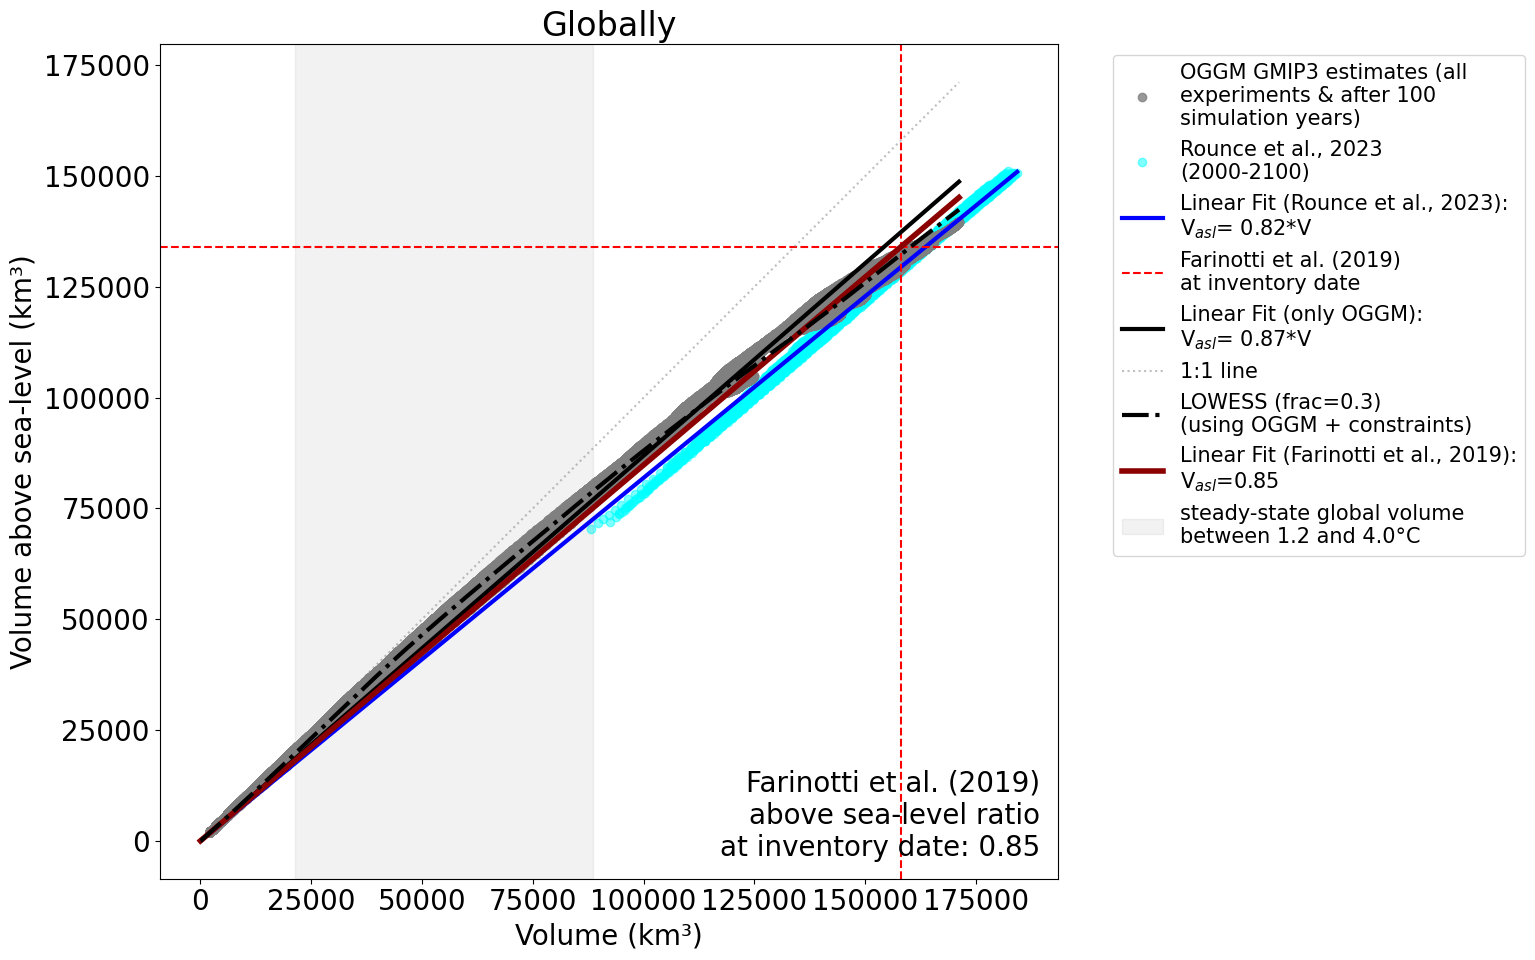

In [57]:
pd_slr_oggm_all_global = pd_slr_oggm_all_reg.loc[pd_slr_oggm_all_reg.year <=2000].groupby(['gcm','period','ssp', 'year']).sum()
assert np.all((pd_slr_oggm_all_global.rgi_reg == 190).values)
pd_slr_oggm_all_global

pd_slr_oggm_all_global = pd_slr_oggm_all_global.reset_index()
pd_slr_oggm_all_global_ss = pd_slr_oggm_all_global.loc[pd_slr_oggm_all_global.year>=1900].groupby(['gcm','period','ssp']).mean()

# don't take the first 100 years 
pd_slr_oggm_all_global = pd_slr_oggm_all_global.loc[pd_slr_oggm_all_global.year>=50] #.groupby(['gcm','period','ssp']).mean()
plt.rcParams.update({'font.size': 20})
j = 0
fig, axs = plt.subplots(1,1,figsize=(20,10))
#axs = axs.flatten()
vol_itmix_m3_reg = df_itmix['vol_itmix_m3'].sum()
vol_bsl_itmix_m3 = df_itmix['vol_bsl_itmix_m3'].sum()
below_sl_ratio = vol_bsl_itmix_m3/vol_itmix_m3_reg
print(rgi_reg,below_sl_ratio)
pd_slr_oggm_reg_sel = pd_slr_oggm_all_global # pd_slr_oggm_reg.loc[pd_slr_oggm_reg.rgi_reg == rgi_reg]
x = pd_slr_oggm_reg_sel.volume_km3.values
y = pd_slr_oggm_reg_sel.volume_km3.values - pd_slr_oggm_reg_sel.volume_km3_bsl.values

ax = axs #[j]
ax.plot(x,y, 'o', color='grey',
        label='OGGM GMIP3 estimates (all\nexperiments & after 100\nsimulation years)', alpha = 0.8, zorder=2)


##########################################
ds_rounce = xr.open_dataset('/home/www/lschuster/rounce_2023_data/Global_reg_allvns_50sets_2000_2100-rcps.nc')
ds_rounce = ds_rounce.sum(dim='region')

x_rounce = ds_rounce.reg_mass_annual/900 / 1e9  # kg /m3
y_rounce = (ds_rounce.reg_mass_annual/900 - ds_rounce.reg_mass_bsl_annual/900)/1e9

plt.plot(x_rounce.values.squeeze().flatten(),
         y_rounce.values.squeeze().flatten(), 'o', label='Rounce et al., 2023\n(2000-2100)', color='cyan', alpha =0.5, zorder = 1)

# Perform linear fit with forced intercept at zero
slope = np.dot(x_rounce.values.squeeze().flatten(), 
              y_rounce.values.squeeze().flatten()) / np.dot(x_rounce.values.squeeze().flatten(), x_rounce.values.squeeze().flatten())
_x = np.arange(0,x_rounce.values.squeeze().flatten().max(),1)
fit = _x*slope #+ #intercept
#fit[_x-fit<0] = 0 # below sea level should be above zero 
#fit[fit<0] = 0 # if above sea level is below zero -> set it equal tabove sea level should be above zero 

plt.plot(_x, fit, color='blue', label=f'Linear Fit (Rounce et al., 2023):\n'+r'V$_{asl}$'+f'= {slope:0.2f}*V', lw=3)
plt.legend()


#######################################
ax.axvline(vol_itmix_m3_reg/1e9, color = 'red', ls= '--')
ax.axhline(vol_itmix_m3_reg/1e9- vol_bsl_itmix_m3/1e9, color = 'red', ls= '--', label='Farinotti et al. (2019)\nat inventory date')

# Performing linear regression
#slope, intercept = np.polyfit(x, y, 1)
#_x = np.arange(0,x.max(),0.1)
# Perform linear fit with forced intercept at zero
slope = np.dot(x, y) / np.dot(x, x)
_x = np.arange(0,x.max(),1)
fit = _x*slope #+ #intercept
#fit[_x-fit<0] = 0 # below sea level should be above zero 
#fit[fit<0] = 0 # if above sea level is below zero -> set it equal tabove sea level should be above zero 

ax.plot(_x, fit, color='black', label=f'Linear Fit (only OGGM):\n'+r'V$_{asl}$'+f'= {slope:0.2f}*V', lw=3)

ax.set_xlabel(f'Volume (km³)')
ax.set_ylabel(f'Volume above sea-level (km³)')


#farinotti_intercept= (vol_itmix_m3_reg/1e9- vol_bsl_itmix_m3/1e9)-  vol_itmix_m3_reg/1e9*slope
#fit_f = _x*slope + farinotti_intercept
#fit_f[_x-fit_f<0] = _x[_x-fit_f<0] # if below sea level would get below zero, set it instead to zero 
#fit_f[fit_f<0] = 0  # above sea level should be above zero 

#ax.plot(_x, fit_f, color='blue',
#         label=f'Linear Fit, rescaled to\nFarinotti et al., 2019:\n'+r'V$_{asl}$'+f'={slope:0.2f}*V +{farinotti_intercept:0.1f}\n'+r'(and V$_{bsl}$≥0 & V$_{asl}$≥0)', lw=3)
reg_name = d_reg_num_name_sh[rgi_reg]
reg_name = reg_name.replace('\n',' ')
ax.set_title('Globally')
ax.plot([min(y), max(x)], [min(y), max(x)], color='grey', linestyle=':', label='1:1 line', alpha = 0.5)

ax.set_aspect('equal', adjustable='box')
ax.text(0.98,0.02, 
        f'Farinotti et al. (2019)\nabove sea-level ratio\nat inventory date: {(1-below_sl_ratio).round(2)}', 
        va = 'bottom', ha='right',
        transform=ax.transAxes)
# Set xticks and yticks to be equal
#max_value = max(max(x), max(y))
#max_value = int(np.ceil(max_value))
#ax.set_xticks(range(max_value + 1))
#ax.set_yticks(range(max_value + 1))


lowess = True
y_f = (vol_itmix_m3_reg/1e9- vol_bsl_itmix_m3/1e9)
x_f = vol_itmix_m3_reg/1e9
if lowess:
    x_f = np.repeat(x_f, len(x))
    y_f = np.repeat(y_f, len(x))
    x_0 = np.repeat(0,len(x))
    y_0 = np.repeat(0,len(x))
    from moepy import lowess, eda
    df_quantiles = lowess.quantile_model(np.concatenate([x,#x_f,
                                                         x_0]),
                                         np.concatenate([y,#y_f,
                                                         y_0]),
                                         x_pred= _x,
                                         frac=0.3,
                                         num_fits=100, robust_iters=1,
                                         qs=[0.5])
    fit_lowess = df_quantiles[0.5]
    fit_lowess_x = df_quantiles.index
    fit_lowess[(fit_lowess_x-fit_lowess)<0] = fit_lowess_x[(fit_lowess_x-fit_lowess)<0]
    fit_lowess[fit_lowess<0] = 0
    ax.plot(fit_lowess_x, fit_lowess, label= 'LOWESS (frac=0.3)\n(using OGGM + constraints)', lw=3, ls = '-.', color='black', zorder=10)

else:
    ax.plot(fit_lowess_x, fit_lowess, label= 'LOWESS (frac=0.3)\n(using OGGM + constraints)', lw=3, ls = '-.', color='black', zorder=10)

    
plt.plot(_x, _x*(1-below_sl_ratio), color='darkred', lw=4, label=f'Linear Fit (Farinotti et al., 2019):\n'+r'V$_{asl}$' + f'={(1-below_sl_ratio).round(2)}' )
#ax.axvline(pd_vol_glob_m3/1e9, ls = '--', color='green')

plt.axvspan(pd_vol_glob_2020_m3*0.14/1e9, pd_vol_glob_2020_m3*0.58/1e9, color='grey', alpha = 0.1, label='steady-state global volume\nbetween 1.2 and 4.0°C')

ax.legend(loc='upper left', fontsize=15, bbox_to_anchor=(1.05,1))
plt.tight_layout()
plt.savefig('sl_test.png')

In [58]:
pd_vol_glob_2020_m3

152767463429916.1

In [59]:


def convert_rel_ice_2020_mm_slr(perc, frac = 0.85):
    #need to compute the volume at steady-state 
    vol_ss = perc/100 * pd_vol_glob_2020_m3
    # then compute volume difference  in m3
    vol_diff = pd_vol_glob_2020_m3 - vol_ss
    # above sea-level
    vol_asl_diff = frac* vol_diff
    # convert m3 into sea-level equivalent 
    #A_ocean = 3.625 * 10^8
    A_ocean = 3.625 * 10**8 * 1e6 #km2 -> m2 -> 1e6
    m_slr = (vol_asl_diff/A_ocean) *900/1028 # rhoice/rho_ocean
    mm_slr = m_slr * 1000
    return mm_slr

pd_lowess_vol_gmt = pd.read_csv('lowess_fits/fitted_lowess_best_frac_shift_years_rel_2020_101yr_avg_period_lowess_added_quantiles_added_current12deg_5000_Feb12_2024_ipcc_ar6.csv', index_col=[0])
pd_lowess_vol_gmt_glob = pd_lowess_vol_gmt.loc[pd_lowess_vol_gmt.region == 'All']
(convert_rel_ice_2020_mm_slr(pd_lowess_vol_gmt_glob.loc[3.0]['0.5']) - convert_rel_ice_2020_mm_slr(pd_lowess_vol_gmt_glob.loc[1.5]['0.5']))/15

6.352513209167034

*is the SLE mm ratio different ??*

In [60]:
convert_rel_ice_2020_mm_slr(pd_lowess_vol_gmt_glob.loc[3.0]['0.5'], frac= 0.85) / convert_rel_ice_2020_mm_slr(pd_lowess_vol_gmt_glob.loc[3.0]['0.5'], frac=1)

0.8499999999999999

- need to compute the volume at steady-state 
    - rel_ice_2020/100 * pd_vol_glob_2020_m3
- then compute volume difference 
    - vol_diff = pd_vol_glob_2020_m3 - rel_ice_2020/100 * pd_vol_glob_2020_
    
ρice = 900 kg m−3 , an ocean area of Aocean
= 3.625 × 108 km2 and a mean ocean density of ρocean = 1,028 kg m−3
(ref. 51 ), (2)

**around 6mm SL more for every tenth of a degree warming**

Text(0, 0.5, 'difference (lowess vs linear fit)\nrel. to 2020 volume')

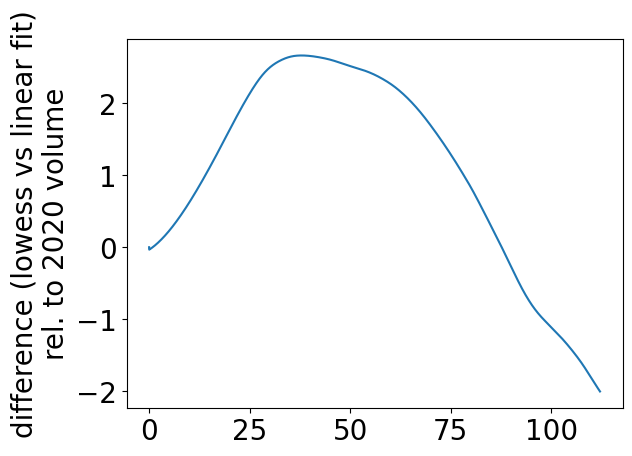

In [61]:
plt.plot(100*fit_lowess_x*1e9/pd_vol_glob_2020_m3, 100*(fit_lowess.values - fit_lowess_x*0.85)/(pd_vol_glob_2020_m3/1e9))
plt.ylabel('difference (lowess vs linear fit)\nrel. to 2020 volume')

**now plot directy the ratio**

In [62]:
ds_rounce = xr.open_dataset('/home/www/lschuster/rounce_2023_data/Global_reg_allvns_50sets_2000_2100-rcps.nc')

100-100*(ds_rounce.sum(dim='region').sel(year=2100)/ds_rounce.sum(dim='region').sel(year=2015)).reg_mass_annual.isel(scenario=0).median()

<xarray.DataArray 'reg_mass_annual' ()>
array(25.28450272)
Coordinates:
    Scenario  object 'RCP2.6'

In [63]:
ds_rounce.sum(dim='region').sel(year=2015)

<xarray.Dataset>
Dimensions:                      (time: 1212, scenario: 3, model: 10)
Coordinates:
  * time                         (time) datetime64[ns] 2000-01-01 ... 2100-12-01
    Climate_Model                (model) object ...
    Scenario                     (scenario) object ...
    year                         int64 2015
Dimensions without coordinates: scenario, model
Data variables:
    reg_mass_annual              (scenario, model) float64 1.534e+17 ... 1.59...
    reg_mass_bsl_annual          (scenario, model) float64 2.697e+16 ... 2.80...
    reg_area_annual              (scenario, model) float64 6.985e+11 ... 6.98...
    reg_melt_monthly             (scenario, model, time) float64 2.87e+13 ......
    reg_acc_monthly              (scenario, model, time) float64 4.277e+13 .....
    reg_refreeze_monthly         (scenario, model, time) float64 6.463e+11 .....
    reg_frontalablation_monthly  (scenario, model, time) float64 0.0 ... 6.13...

In [64]:
ds_rounce_rcps = xr.open_dataset('/home/www/lschuster/rounce_2023_data/Global_reg_allvns_50sets_2000_2100-rcps.nc')
ds_rounce_ssps = xr.open_dataset('/home/www/lschuster/rounce_2023_data/Global_reg_allvns_50sets_2000_2100-ssps.nc')

In [65]:
mass_2015 = ds_rounce_rcps.sum(dim='region', min_count=19).sel(year=2015)

In [66]:
mass_2100 = ds_rounce_rcps.sum(dim='region', min_count=19).sel(year=2100)

In [67]:
vol_diff = (mass_2015-mass_2100).reg_mass_annual/900
A_ocean = 3.625 * 10**8 * 1e6 #km2 -> m2 -> 1e6
m_slr = (vol_diff/A_ocean) *900/1028 # rhoice/rho_ocean
mm_slr = m_slr * 1000
mm_slr.median(dim='model')

<xarray.DataArray 'reg_mass_annual' (scenario: 3)>
array([103.07213602, 128.53744168, 180.11082358])
Coordinates:
    Scenario  (scenario) object 'RCP2.6' 'RCP4.5' 'RCP8.5'
Dimensions without coordinates: scenario

In [68]:
vol_diff = (mass_2015-mass_2100).reg_mass_annual/900 - (mass_2015-mass_2100).reg_mass_bsl_annual/900
A_ocean = 3.625 * 10**8 * 1e6 #km2 -> m2 -> 1e6
m_slr = (vol_diff/A_ocean) *900/1028 # rhoice/rho_ocean
mm_slr_asl = m_slr * 1000
mm_slr_asl.median(dim='model')

<xarray.DataArray (scenario: 3)>
array([ 87.50088148, 110.56799117, 155.74272454])
Coordinates:
    Scenario  (scenario) object 'RCP2.6' 'RCP4.5' 'RCP8.5'
Dimensions without coordinates: scenario

In [69]:
mm_slr_asl/mm_slr
# here the ratios are similar as estimated in drounce paper, but why is it then so different in the scatterplot???? 

<xarray.DataArray (scenario: 3, model: 10)>
array([[0.85158259, 0.83026369, 0.83685588, 0.83636998, 0.88368491,
        0.82520584, 0.81581032, 0.85900445, 0.8502945 , 0.8597026 ],
       [0.86194097, 0.84540365, 0.84556153, 0.84877067, 0.88205004,
        0.83793132, 0.84693135, 0.86592426, 0.85725584, 0.87027801],
       [0.86501388, 0.85594553, 0.83836639, 0.84869768, 0.88683272,
        0.86333629, 0.8691319 , 0.87325791, 0.87356256, 0.87338671]])
Coordinates:
    Climate_Model  (model) object 'CanESM2' 'CCSM4' ... 'MPI-ESM-LR' 'NorESM1-M'
    Scenario       (scenario) object 'RCP2.6' 'RCP4.5' 'RCP8.5'
Dimensions without coordinates: scenario, model

/tmp/ipykernel_443576/594151880.py:26: RuntimeWarning: invalid value encountered in divide
  plt.plot(_x, fit/_x, color='blue', label=f'Linear Fit (Rounce et al., 2023):\n'+r'V$_{asl}$'+f'= {slope:0.2f}*V', lw=3)


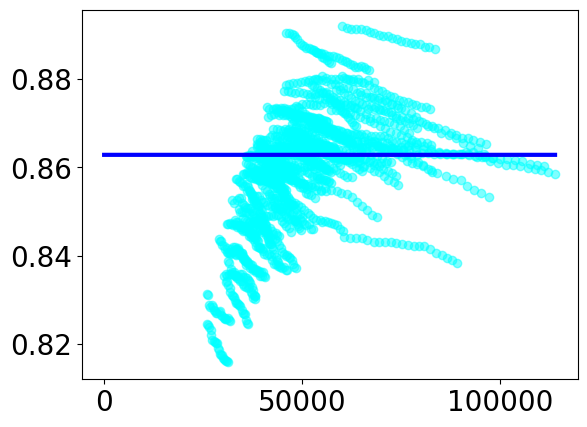

In [70]:
ds_rounce_rcps = xr.open_dataset('/home/www/lschuster/rounce_2023_data/Global_reg_allvns_50sets_2000_2100-rcps.nc')
ds_rounce_ssps = xr.open_dataset('/home/www/lschuster/rounce_2023_data/Global_reg_allvns_50sets_2000_2100-ssps.nc')
_x_rounce_l = []
_ratio_rounce_l = []
for ds_rounce in [ds_rounce_rcps, ds_rounce_ssps]: 
    ds_rounce = ds_rounce.sum(dim='region', min_count=19).sel(year=2015) -  ds_rounce.sum(dim='region', min_count=19).sel(year=slice(2080,2100))

    x_rounce = ds_rounce.reg_mass_annual/900 / 1e9  # kg /m3
    y_rounce = (ds_rounce.reg_mass_annual/900 - ds_rounce.reg_mass_bsl_annual/900)/1e9

    plt.plot(x_rounce.values.squeeze().flatten(),
             y_rounce.values.squeeze().flatten()/x_rounce.values.squeeze().flatten(), 'o', label='Rounce et al., 2023\n(2020-2101)', color='cyan', alpha =0.5, zorder = 1)
    _x_rounce_l.append(x_rounce.values.squeeze().flatten())
    _ratio_rounce_l.append(y_rounce.values.squeeze().flatten()/x_rounce.values.squeeze().flatten())

# Perform linear fit with forced intercept at zero
_ratio = np.concatenate(_ratio_rounce_l)
_x_s = np.concatenate(_x_rounce_l)
slope = np.dot(_x_s[~np.isnan(_ratio)], 
               _ratio[~np.isnan(_ratio)]*_x_s[~np.isnan(_ratio)]) / np.dot(_x_s[~np.isnan(_ratio)], _x_s[~np.isnan(_ratio)])
_x = np.arange(0,_x_s[~np.isnan(_ratio)].max(),1)
fit = _x*slope #+ #intercept
#fit[_x-fit<0] = 0 # below sea level should be above zero 
#fit[fit<0] = 0 # if above sea level is below zero -> set it equal tabove sea level should be above zero 

plt.plot(_x, fit/_x, color='blue', label=f'Linear Fit (Rounce et al., 2023):\n'+r'V$_{asl}$'+f'= {slope:0.2f}*V', lw=3)
#plt.legend()

In [71]:
pd_vol_glob_2020_m3/1e9

152767.4634299161

19 0.15193551737209102


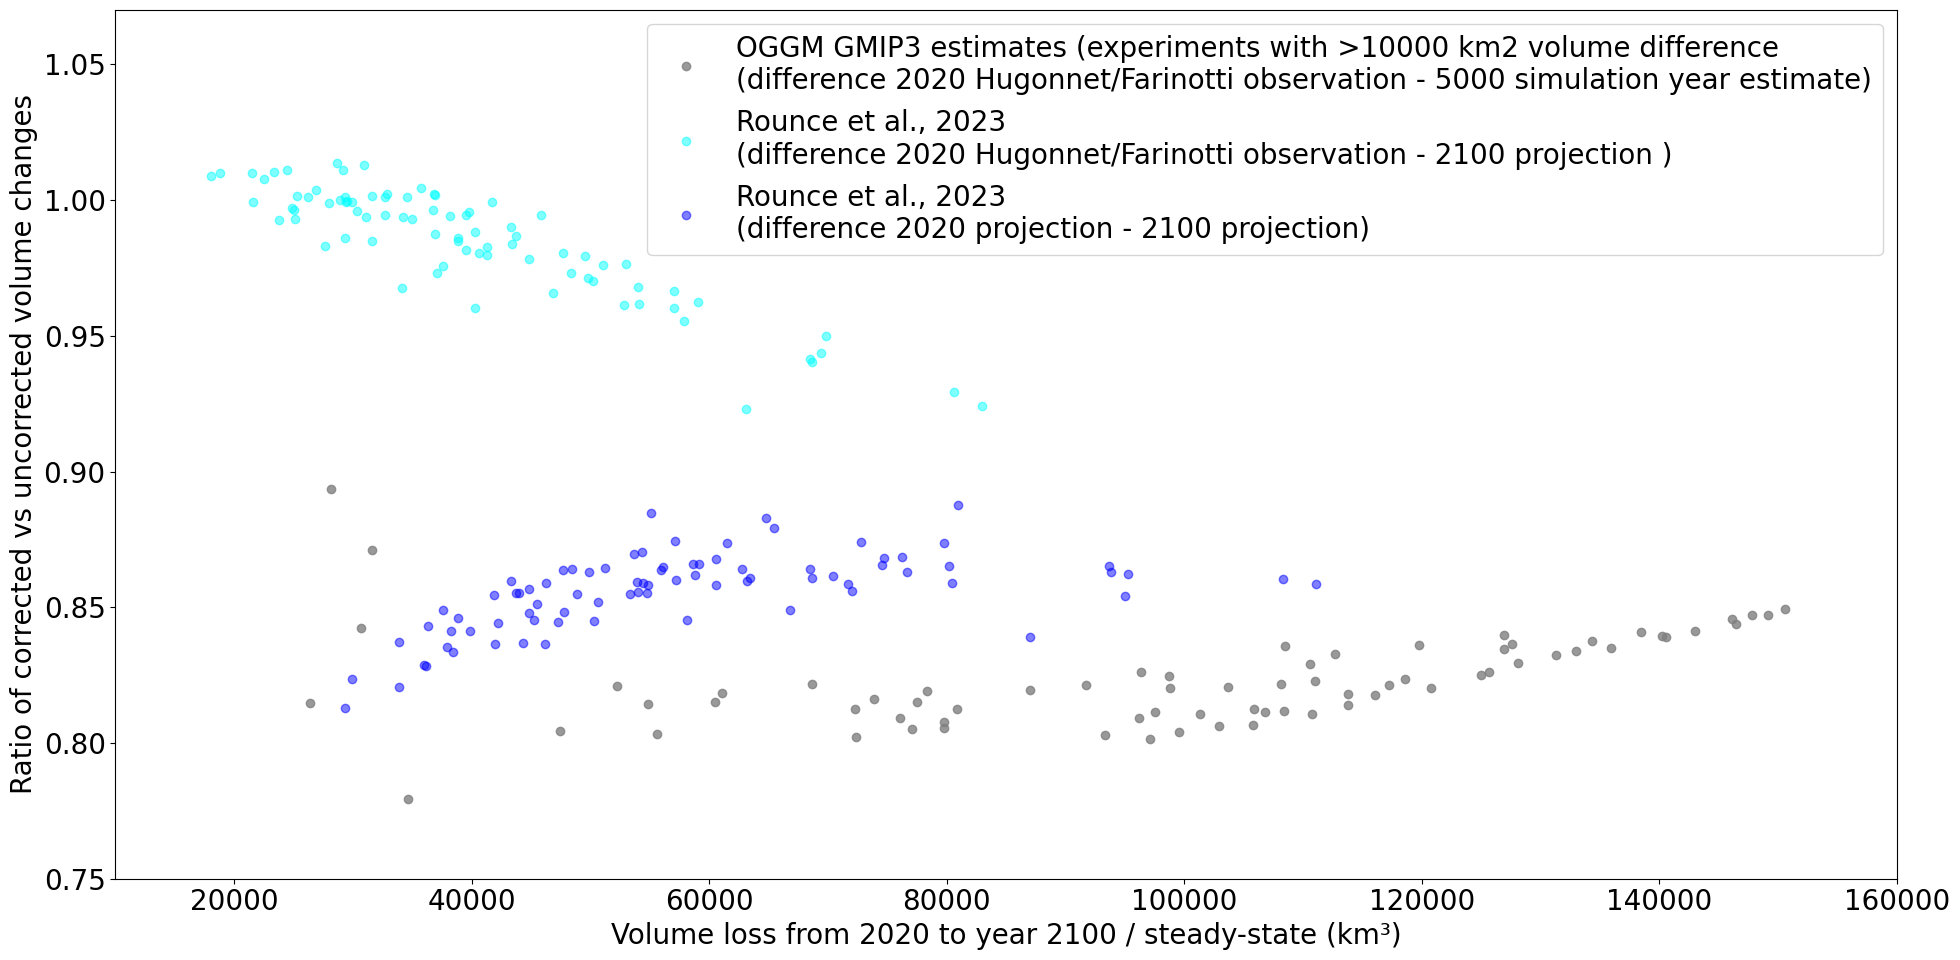

In [72]:
plt.rcParams.update({'font.size': 20})
j = 0
fig, axs = plt.subplots(1,1,figsize=(20,10))
#axs = axs.flatten()
vol_itmix_m3_reg = df_itmix['vol_itmix_m3'].sum()
vol_bsl_itmix_m3 = df_itmix['vol_bsl_itmix_m3'].sum()
below_sl_ratio = vol_bsl_itmix_m3/vol_itmix_m3_reg
print(rgi_reg,below_sl_ratio)
pd_slr_oggm_reg_sel = pd_slr_oggm_all_global_ss # pd_slr_oggm_reg.loc[pd_slr_oggm_reg.rgi_reg == rgi_reg]
x = pd_slr_oggm_reg_sel.volume_km3.values
y = pd_slr_oggm_reg_sel.volume_km3.values - pd_slr_oggm_reg_sel.volume_km3_bsl.values
pd_vol_glob_2020_km3_asl = pd_vol_glob_2020_m3*0.85/1e9
pd_vol_glob_2020_km3 = pd_vol_glob_2020_m3/1e9

ax = axs #[j]
ax.plot(pd_vol_glob_2020_km3-x,(pd_vol_glob_2020_km3_asl-y)/(pd_vol_glob_2020_km3 - x), 'o', color='grey',
        label='OGGM GMIP3 estimates (experiments with >10000 km2 volume difference\n(difference 2020 Hugonnet/Farinotti observation - 5000 simulation year estimate)', alpha = 0.8, zorder=2)


##########################################
ds_rounce_rcps = xr.open_dataset('/home/www/lschuster/rounce_2023_data/Global_reg_allvns_50sets_2000_2100-rcps.nc')
ds_rounce_ssps = xr.open_dataset('/home/www/lschuster/rounce_2023_data/Global_reg_allvns_50sets_2000_2100-ssps.nc')
_x_rounce_l = []
_ratio_rounce_l = []
for j, _ds_rounce in enumerate([ds_rounce_rcps, ds_rounce_ssps]): 
    ds_rounce = _ds_rounce.sum(dim='region', min_count=19).sel(year=2100)
    ds_rounce_2020 = _ds_rounce.sum(dim='region', min_count=19).sel(year=2020)

    x_rounce = pd_vol_glob_2020_m3/1e9 - ds_rounce.reg_mass_annual/900/1e9  # kg /m3 - 
    y_rounce =  pd_vol_glob_2020_m3*0.85/1e9 - (ds_rounce.reg_mass_annual/900 - ds_rounce.reg_mass_bsl_annual/900)/1e9 

    plt.plot(x_rounce.values.squeeze().flatten(),
             y_rounce.values.squeeze().flatten()/x_rounce.values.squeeze().flatten(), 'o', label='Rounce et al., 2023\n(difference 2020 Hugonnet/Farinotti observation - 2100 projection )', color='cyan', alpha =0.5, zorder = 1)
    
    
    x_rounce_b = ds_rounce_2020.reg_mass_annual/900/1e9 - ds_rounce.reg_mass_annual/900 / 1e9  # kg /m3 - 
    y_rounce_b = (ds_rounce_2020.reg_mass_annual/900/1e9-ds_rounce_2020.reg_mass_bsl_annual/900/1e9) - (ds_rounce.reg_mass_annual/900 - ds_rounce.reg_mass_bsl_annual/900)/1e9 

    plt.plot(x_rounce_b.values.squeeze().flatten(),
             y_rounce_b.values.squeeze().flatten()/x_rounce_b.values.squeeze().flatten(), 'o', label='Rounce et al., 2023\n(difference 2020 projection - 2100 projection)', color='blue', alpha =0.5, zorder = 1)
    
    
    _x_rounce_l.append(x_rounce.values.squeeze().flatten())
    _ratio_rounce_l.append(y_rounce.values.squeeze().flatten()/x_rounce.values.squeeze().flatten())
    if j == 0:
        plt.legend()

# Perform linear fit with forced intercept at zero
_ratio = np.concatenate(_ratio_rounce_l)
_x_s = np.concatenate(_x_rounce_l)
slope = np.dot(_x_s[~np.isnan(_ratio)], 
               _ratio[~np.isnan(_ratio)]*_x_s[~np.isnan(_ratio)]) / np.dot(_x_s[~np.isnan(_ratio)], _x_s[~np.isnan(_ratio)])
_x = np.arange(0,_x_s[~np.isnan(_ratio)].max(),1)
fit = _x*slope #+ #intercept
#fit[_x-fit<0] = 0 # below sea level should be above zero 
#fit[fit<0] = 0 # if above sea level is below zero -> set it equal tabove sea level should be above zero 

#plt.plot(_x, fit/_x, color='blue', label=f'Linear Fit (Rounce et al., 2023):\n'+r'V$_{asl}$'+f'= {slope:0.2f}*V', lw=3)


plt.ylim([0.75,1.07])
plt.xlim([10000, 160000])
plt.ylabel('Ratio of corrected vs uncorrected volume changes')
plt.xlabel('Volume loss from 2020 to year 2100 / steady-state (km³)')
plt.tight_layout()
plt.savefig('ratio_vol_difference.png')
#plt.legend()

In [73]:
x_rounce_b

<xarray.DataArray 'reg_mass_annual' (scenario: 5, model: 12)>
array([[            nan,             nan,             nan,
         54384.49800196,  50311.21059875,             nan,
         33897.3162441 ,             nan,             nan,
                    nan,  41998.35770667,             nan],
       [ 46158.43547602,  55956.48576248,  53967.0109185 ,
         60564.4240133 ,  54758.16618881,  39846.08651241,
         38442.90772334,  36293.80919014,  38268.44111233,
         35959.63417946,  47256.3130795 ,  41883.30321776],
       [ 54853.91499279,  62736.23316752,  63177.68180852,
         76243.92835585,  74555.1169763 ,  48884.64055117,
         44809.02463367,  43996.23756611,  43689.36273398,
         42172.8012516 ,  57181.43672435,  48417.36181141],
       [ 68628.22452232,  74719.9721967 ,  70413.36785283,
         93698.75608175,  93819.834374  ,  63402.18034005,
         53888.42021351,  51191.54310182,  49899.94592563,
         50626.98459054,  68491.64300907,  57124.66120059],
       [ 76687.87240701,  95230.4550109 ,  95040.20893912,
        111097.67559812, 108286.41159617,  71686.06221617,
         60572.09628677,  58652.73761309,  56087.36658621,
         53368.25841971,  80471.13881872,  65427.79021286]])
Coordinates:
    Climate_Model  (model) object 'BCC-CSM2-MR' 'CESM2' ... 'NorESM2-MM'
    Scenario       (scenario) object 'SSP1-1.9' 'SSP1-2.6' ... 'SSP5-8.5'
Dimensions without coordinates: scenario, model

/tmp/ipykernel_443576/391893350.py:15: RuntimeWarning: invalid value encountered in divide
  ax.plot(_x, fit/_x, color='black', label=f'Linear Fit (only OGGM):\n'+r'V$_{asl}$'+f'= {slope:0.2f}*V', lw=3)
100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.19s/it]
/tmp/ipykernel_443576/391893350.py:73: RuntimeWarning: invalid value encountered in divide
  plt.plot(_x, _x*(1-below_sl_ratio)/_x, color='darkred', lw=4, label=f'Linear Fit (Farinotti et al., 2019):\n'+r'V$_{asl}$' + f'={(1-below_sl_ratio).round(2)}' )


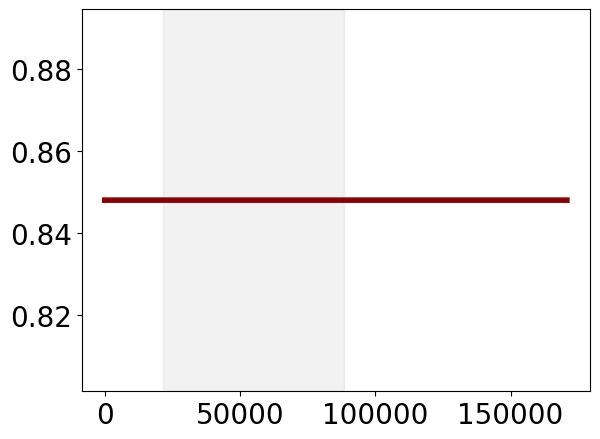

In [74]:



#######################################
ax.axvline(vol_itmix_m3_reg/1e9, color = 'red', ls= '--')
ax.axhline((vol_itmix_m3_reg/1e9- vol_bsl_itmix_m3/1e9)/(vol_itmix_m3_reg/1e9), color = 'red', ls= '--', label='Farinotti et al. (2019)\nat inventory date')

# Performing linear regression
#slope, intercept = np.polyfit(x, y, 1)
#_x = np.arange(0,x.max(),0.1)
# Perform linear fit with forced intercept at zero
slope = np.dot(x, y) / np.dot(x, x)
_x = np.arange(0,x.max(),1)
fit = _x*slope #+ #intercept
#fit[_x-fit<0] = 0 # below sea level should be above zero 
#fit[fit<0] = 0 # if above sea level is below zero -> set it equal tabove sea level should be above zero 

ax.plot(_x, fit/_x, color='black', label=f'Linear Fit (only OGGM):\n'+r'V$_{asl}$'+f'= {slope:0.2f}*V', lw=3)

ax.set_xlabel(f'Volume (km³)')
ax.set_ylabel(f'Ratio (above sea-level vs total)')


#farinotti_intercept= (vol_itmix_m3_reg/1e9- vol_bsl_itmix_m3/1e9)-  vol_itmix_m3_reg/1e9*slope
#fit_f = _x*slope + farinotti_intercept
#fit_f[_x-fit_f<0] = _x[_x-fit_f<0] # if below sea level would get below zero, set it instead to zero 
#fit_f[fit_f<0] = 0  # above sea level should be above zero 

#ax.plot(_x, fit_f, color='blue',
#         label=f'Linear Fit, rescaled to\nFarinotti et al., 2019:\n'+r'V$_{asl}$'+f'={slope:0.2f}*V +{farinotti_intercept:0.1f}\n'+r'(and V$_{bsl}$≥0 & V$_{asl}$≥0)', lw=3)
reg_name = d_reg_num_name_sh[rgi_reg]
reg_name = reg_name.replace('\n',' ')
ax.set_title('Globally')
ax.axhline(1, color='grey', linestyle=':', label='ratio of 1', alpha = 0.5)

#ax.set_aspect('equal', adjustable='box')
#ax.text(0.98,0.02, 
#        f'Farinotti et al. (2019)\nabove sea-level ratio\nat inventory date: {(1-below_sl_ratio).round(2)}', 
#        va = 'bottom', ha='right',
#        transform=ax.transAxes)
# Set xticks and yticks to be equal
#max_value = max(max(x), max(y))
#max_value = int(np.ceil(max_value))
#ax.set_xticks(range(max_value + 1))
#ax.set_yticks(range(max_value + 1))


lowess = True
y_f = (vol_itmix_m3_reg/1e9- vol_bsl_itmix_m3/1e9)
x_f = vol_itmix_m3_reg/1e9
_x_l = np.arange(1000,x.max(),100)

if lowess:
    x_f = np.repeat(x_f, len(x))
    y_f = np.repeat(y_f, len(x))/x_f
    x_0 = np.repeat(0,len(x))
    y_0 = np.repeat(1,len(x))
    from moepy import lowess, eda
    df_quantiles = lowess.quantile_model(np.concatenate([x,#x_f,
                                                         x_0]),
                                         np.concatenate([y/x,#y_f,
                                                         y_0]),
                                         x_pred= _x_l,
                                         frac=0.7,
                                         num_fits=200, robust_iters=1,
                                         qs=[0.5])
    fit_lowess = df_quantiles[0.5]
    fit_lowess_x = _x_l #df_quantiles.index
    #fit_lowess[(fit_lowess_x-fit_lowess)<0] = fit_lowess_x[(fit_lowess_x-fit_lowess)<0]
    #fit_lowess[fit_lowess<0] = 0
    ax.plot(fit_lowess_x, fit_lowess, label= 'LOWESS (frac=0.7)\n(using OGGM + constraints)', lw=3, ls = '-.', color='black', zorder=10)

    #ax.plot(fit_lowess_x, fit_lowess, label= 'LOWESS (frac=0.3)\n(using OGGM + constraints)', lw=3, ls = '-.', color='black', zorder=10)

    
plt.plot(_x, _x*(1-below_sl_ratio)/_x, color='darkred', lw=4, label=f'Linear Fit (Farinotti et al., 2019):\n'+r'V$_{asl}$' + f'={(1-below_sl_ratio).round(2)}' )
#ax.axvline(pd_vol_glob_m3/1e9, ls = '--', color='green')

plt.axvspan(pd_vol_glob_2020_m3*0.14/1e9, pd_vol_glob_2020_m3*0.58/1e9, color='grey', alpha = 0.1, label='steady-state global volume\nbetween 1.2 and 4.0°C')




ax.legend(loc='upper left', fontsize=15, bbox_to_anchor=(1.05,1))
plt.tight_layout()
plt.savefig('sl_test_ratio_only_ss.png')

**Absolute ratio vs volume** 

19 0.15193551737209102


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.13s/it]
/tmp/ipykernel_443576/2746420098.py:171: RuntimeWarning: invalid value encountered in divide
  plt.plot(_x, _x*(1-below_sl_ratio)/_x, color='darkred', lw=4, label=f'constant ratio (Farinotti et al., 2019):\n'+r'V$_{asl}$' + f'={(1-below_sl_ratio).round(2)}' )
100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.15s/it]


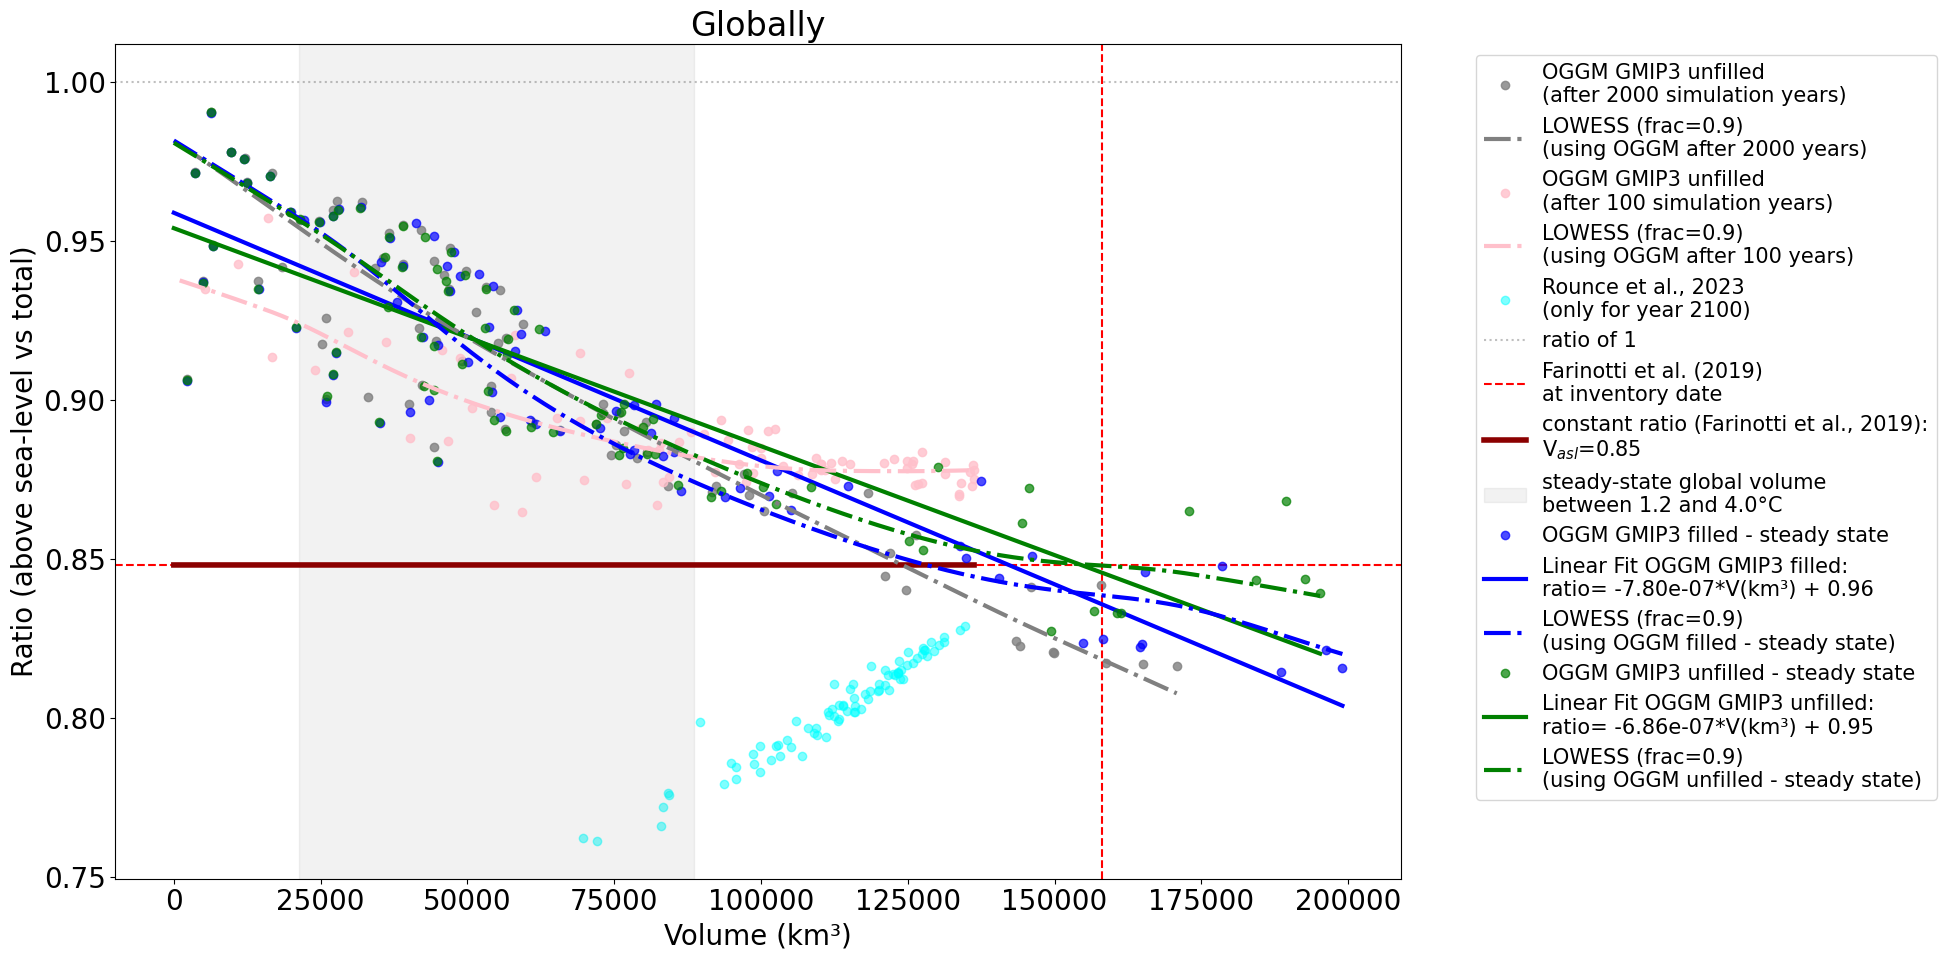

In [75]:
plt.rcParams.update({'font.size': 20})
j = 0
fig, axs = plt.subplots(1,1,figsize=(20,10))
#axs = axs.flatten()
vol_itmix_m3_reg = df_itmix['vol_itmix_m3'].sum()
vol_bsl_itmix_m3 = df_itmix['vol_bsl_itmix_m3'].sum()
below_sl_ratio = vol_bsl_itmix_m3/vol_itmix_m3_reg
print(rgi_reg,below_sl_ratio)

### oGGM after 2000 years 
pd_slr_oggm_reg_sel = pd_slr_oggm_all_global_ss # pd_slr_oggm_reg.loc[pd_slr_oggm_reg.rgi_reg == rgi_reg]
x = pd_slr_oggm_reg_sel.volume_km3.values
y = pd_slr_oggm_reg_sel.volume_km3.values - pd_slr_oggm_reg_sel.volume_km3_bsl.values

ax = axs #[j]
ax.plot(x,y/x, 'o', color='grey',
        label='OGGM GMIP3 unfilled\n(after 2000 simulation years)', alpha = 0.8, zorder=2)


y_f = (vol_itmix_m3_reg/1e9- vol_bsl_itmix_m3/1e9)
x_f = vol_itmix_m3_reg/1e9
_x_l = np.arange(1000,x.max(),100)
x_f = np.repeat(x_f, 10)
y_f = np.repeat(y_f, 10)/x_f
x_0 = np.repeat(0,len(x))
y_0 = np.repeat(1,len(x))
df_quantiles = lowess.quantile_model(np.concatenate([x,#x_f,
                                                    ]), #, x_0]),
                                     np.concatenate([y/x]),#y_f,
                                                    # y_0]),
                                     x_pred= _x_l,
                                     frac=0.9,
                                     num_fits=200, robust_iters=1,
                                     qs=[0.5])
fit_lowess = df_quantiles[0.5]
fit_lowess_x = _x_l #df_quantiles.index
#fit_lowess[(fit_lowess_x-fit_lowess)<0] = fit_lowess_x[(fit_lowess_x-fit_lowess)<0]
#fit_lowess[fit_lowess<0] = 0
ax.plot(fit_lowess_x, fit_lowess, label= 'LOWESS (frac=0.9)\n(using OGGM after 2000 years)', lw=3, ls = '-.', color='grey', zorder=10)


#### OGGM after 100 simulation years
pd_slr_oggm_reg_sel = pd_slr_oggm_all_global.loc[pd_slr_oggm_all_global.year == 100] # pd_slr_oggm_reg.loc[pd_slr_oggm_reg.rgi_reg == rgi_reg]
x = pd_slr_oggm_reg_sel.volume_km3.values
y = pd_slr_oggm_reg_sel.volume_km3.values - pd_slr_oggm_reg_sel.volume_km3_bsl.values

ax = axs #[j]
ax.plot(x,y/x, 'o', color='pink',
        label='OGGM GMIP3 unfilled\n(after 100 simulation years)', alpha = 0.8, zorder=2)


y_f = (vol_itmix_m3_reg/1e9- vol_bsl_itmix_m3/1e9)
x_f = vol_itmix_m3_reg/1e9
_x_l = np.arange(1000,x.max(),100)
x_f = np.repeat(x_f, 10)
y_f = np.repeat(y_f, 10)/x_f
x_0 = np.repeat(0,len(x))
y_0 = np.repeat(1,len(x))
df_quantiles = lowess.quantile_model(np.concatenate([x,#x_f,
                                                    ]), #, x_0]),
                                     np.concatenate([y/x]),#y_f,
                                                    # y_0]),
                                     x_pred= _x_l,
                                     frac=0.9,
                                     num_fits=200, robust_iters=1,
                                     qs=[0.5])
fit_lowess = df_quantiles[0.5]
fit_lowess_x = _x_l #df_quantiles.index
#fit_lowess[(fit_lowess_x-fit_lowess)<0] = fit_lowess_x[(fit_lowess_x-fit_lowess)<0]
#fit_lowess[fit_lowess<0] = 0
ax.plot(fit_lowess_x, fit_lowess, label= 'LOWESS (frac=0.9)\n(using OGGM after 100 years)', lw=3, ls = '-.', color='pink', zorder=10)

##########################################
ds_rounce_rcps = xr.open_dataset('/home/www/lschuster/rounce_2023_data/Global_reg_allvns_50sets_2000_2100-rcps.nc')
ds_rounce_ssps = xr.open_dataset('/home/www/lschuster/rounce_2023_data/Global_reg_allvns_50sets_2000_2100-ssps.nc')
_x_rounce_l = []
_ratio_rounce_l = []
for j,ds_rounce in enumerate([ds_rounce_rcps, ds_rounce_ssps]): 
    ds_rounce = ds_rounce.sum(dim='region', min_count=19).sel(year=2100)

    x_rounce = ds_rounce.reg_mass_annual/900 / 1e9  # kg /m3
    y_rounce = (ds_rounce.reg_mass_annual/900 - ds_rounce.reg_mass_bsl_annual/900)/1e9
    if j ==0: 
        plt.plot(x_rounce.values.squeeze().flatten(),
                 y_rounce.values.squeeze().flatten()/x_rounce.values.squeeze().flatten(), 'o', label='Rounce et al., 2023\n(only for year 2100)', color='cyan', alpha =0.5, zorder = 1)
    else:
        plt.plot(x_rounce.values.squeeze().flatten(),
                 y_rounce.values.squeeze().flatten()/x_rounce.values.squeeze().flatten(), 'o', #label='Rounce et al., 2023\n(2020-2101)', 
                         color='cyan', alpha =0.5, zorder = 1)
    _x_rounce_l.append(x_rounce.values.squeeze().flatten())
    _ratio_rounce_l.append(y_rounce.values.squeeze().flatten()/x_rounce.values.squeeze().flatten())

# Perform linear fit with forced intercept at zero
_ratio = np.concatenate(_ratio_rounce_l)
_x_s = np.concatenate(_x_rounce_l)
slope = np.dot(_x_s[~np.isnan(_ratio)], 
               _ratio[~np.isnan(_ratio)]*_x_s[~np.isnan(_ratio)]) / np.dot(_x_s[~np.isnan(_ratio)], _x_s[~np.isnan(_ratio)])
_x = np.arange(0,_x_s[~np.isnan(_ratio)].max(),1)
fit = _x*slope #+ #intercept
#fit[_x-fit<0] = 0 # below sea level should be above zero 
#fit[fit<0] = 0 # if above sea level is below zero -> set it equal tabove sea level should be above zero 

#plt.plot(_x, fit/_x, color='blue', label=f'Linear Fit (Rounce et al., 2023):\n'+r'V$_{asl}$'+f'= {slope:0.2f}*V', lw=3)
plt.legend()


#######################################

# Performing linear regression
#slope, intercept = np.polyfit(x, y, 1)
#_x = np.arange(0,x.max(),0.1)
# Perform linear fit with forced intercept at zero
slope = np.dot(x, y) / np.dot(x, x)
_x = np.arange(0,x.max(),1)
fit = _x*slope #+ #intercept
#fit[_x-fit<0] = 0 # below sea level should be above zero 
#fit[fit<0] = 0 # if above sea level is below zero -> set it equal tabove sea level should be above zero 

#ax.plot(_x, fit/_x, color='black', label=f'Linear Fit (only OGGM):\n'+r'V$_{asl}$'+f'= {slope:0.2f}*V', lw=3)

ax.set_xlabel(f'Volume (km³)')
ax.set_ylabel(f'Ratio (above sea-level vs total)')


#farinotti_intercept= (vol_itmix_m3_reg/1e9- vol_bsl_itmix_m3/1e9)-  vol_itmix_m3_reg/1e9*slope
#fit_f = _x*slope + farinotti_intercept
#fit_f[_x-fit_f<0] = _x[_x-fit_f<0] # if below sea level would get below zero, set it instead to zero 
#fit_f[fit_f<0] = 0  # above sea level should be above zero 

#ax.plot(_x, fit_f, color='blue',
#         label=f'Linear Fit, rescaled to\nFarinotti et al., 2019:\n'+r'V$_{asl}$'+f'={slope:0.2f}*V +{farinotti_intercept:0.1f}\n'+r'(and V$_{bsl}$≥0 & V$_{asl}$≥0)', lw=3)
reg_name = d_reg_num_name_sh[rgi_reg]
reg_name = reg_name.replace('\n',' ')
ax.set_title('Globally')
ax.axhline(1, color='grey', linestyle=':', label='ratio of 1', alpha = 0.5)

#ax.set_aspect('equal', adjustable='box')
#ax.text(0.98,0.02, 
#        f'Farinotti et al. (2019)\nabove sea-level ratio\nat inventory date: {(1-below_sl_ratio).round(2)}', 
#        va = 'bottom', ha='right',
#        transform=ax.transAxes)
# Set xticks and yticks to be equal
#max_value = max(max(x), max(y))
#max_value = int(np.ceil(max_value))
#ax.set_xticks(range(max_value + 1))
#ax.set_yticks(range(max_value + 1))


oggm_2000_lowess = False
if oggm_2000_lowess:  
    df_quantiles_two = lowess.quantile_model(np.concatenate([x,x_f,
                                                         x_0]),
                                         np.concatenate([y/x,y_f,
                                                         y_0]),
                                         x_pred= _x_l,
                                         frac=0.9,
                                         num_fits=500, robust_iters=2,
                                         qs=[0.5])
    fit_lowess_two = df_quantiles_two[0.5]
    fit_lowess_x = _x_l #df_quantiles.index
    #fit_lowess[(fit_lowess_x-fit_lowess)<0] = fit_lowess_x[(fit_lowess_x-fit_lowess)<0]
    #fit_lowess[fit_lowess<0] = 0
    ax.plot(fit_lowess_x, fit_lowess_two, label= 'LOWESS (frac=0.9)\n(using OGGM  and Farinotti et al.,2019)', lw=3, ls = '-.', color='pink', zorder=10)
    
    
    #ax.plot(fit_lowess_x, fit_lowess, label= 'LOWESS (frac=0.3)\n(using OGGM + constraints)', lw=3, ls = '-.', color='black', zorder=10)

ax.axvline(vol_itmix_m3_reg/1e9, color = 'red', ls= '--')
ax.axhline((vol_itmix_m3_reg/1e9- vol_bsl_itmix_m3/1e9)/(vol_itmix_m3_reg/1e9), color = 'red', ls= '--', label='Farinotti et al. (2019)\nat inventory date')
    
plt.plot(_x, _x*(1-below_sl_ratio)/_x, color='darkred', lw=4, label=f'constant ratio (Farinotti et al., 2019):\n'+r'V$_{asl}$' + f'={(1-below_sl_ratio).round(2)}' )
#ax.axvline(pd_vol_glob_m3/1e9, ls = '--', color='green')

plt.axvspan(pd_vol_glob_2020_m3*0.14/1e9, pd_vol_glob_2020_m3*0.58/1e9, color='grey', alpha = 0.1, label='steady-state global volume\nbetween 1.2 and 4.0°C')

x = pd_oggm_v16_asl_bsl_global_ss.volume_m3/1e9
y = pd_oggm_v16_asl_bsl_global_ss.ratio_vol_asl_total
plt.plot(x, y, 'o', color='blue', label='OGGM GMIP3 filled - steady state',alpha = 0.7)
slope, intercept = np.polyfit(x, y, 1)
_x = np.arange(0,x.max(),1)
fit = _x*slope + intercept
fit[fit>1] = 1
fit[fit<0.7] = 0.7
plt.plot(_x, fit, color='blue', label=f'Linear Fit OGGM GMIP3 filled:\nratio= {slope:0.2e}*V(km³) + {intercept.round(3):0.2f}', lw=3)
from moepy import lowess, eda

df_quantiles = lowess.quantile_model(np.concatenate([x]),#x_f,
                                                     #x_0]),
                                     np.concatenate([y#y_f,
                                                    ]), #y_0]),
                                     x_pred= _x,
                                     frac=0.9,
                                     num_fits=200, robust_iters=1,
                                     qs=[0.5])
fit_lowess = df_quantiles[0.5]
fit_lowess_x = _x #df_quantiles.index
#fit_lowess[(fit_lowess_x-fit_lowess)<0] = fit_lowess_x[(fit_lowess_x-fit_lowess)<0]
#fit_lowess[fit_lowess<0] = 0
ax.plot(fit_lowess_x, fit_lowess, label= 'LOWESS (frac=0.9)\n(using OGGM filled - steady state)', lw=3, ls = '-.', color='blue', zorder=10)


###################unfilled
pd_slr_oggm_all_reg_ss_global['ratio_vol_asl_total'] = (pd_slr_oggm_all_reg_ss_global['volume_km3'] - pd_slr_oggm_all_reg_ss_global['volume_km3_bsl'])/pd_slr_oggm_all_reg_ss_global['volume_km3']
x = pd_slr_oggm_all_reg_ss_global.volume_km3#/1e9
y = pd_slr_oggm_all_reg_ss_global.ratio_vol_asl_total
plt.plot(x, y, 'o', color='green', label='OGGM GMIP3 unfilled - steady state',alpha = 0.7)
slope_unfilled, intercept_unfilled = np.polyfit(x, y, 1)
_x = np.arange(0,x.max(),1)
fit = _x*slope_unfilled + intercept_unfilled
fit[fit>1] = 1
fit[fit<0.7] = 0.7
plt.plot(_x, fit, color='green', label=f'Linear Fit OGGM GMIP3 unfilled:\nratio= {slope_unfilled:0.2e}*V(km³) + {intercept_unfilled.round(3):0.2f}', lw=3)


df_quantiles = lowess.quantile_model(np.concatenate([x]),#x_f,
                                                     #x_0]),
                                     np.concatenate([y,#y_f,
                                                    ]), #y_0]),
                                     x_pred= _x,
                                     frac=0.9,
                                     num_fits=200, robust_iters=1,
                                     qs=[0.5])
fit_lowess = df_quantiles[0.5]
fit_lowess_x = _x #df_quantiles.index
#fit_lowess[(fit_lowess_x-fit_lowess)<0] = fit_lowess_x[(fit_lowess_x-fit_lowess)<0]
#fit_lowess[fit_lowess<0] = 0
ax.plot(fit_lowess_x, fit_lowess, label= 'LOWESS (frac=0.9)\n(using OGGM unfilled - steady state)', lw=3, ls = '-.', color='green', zorder=10)
df_quantiles['volume_km3'] = _x.round(0).astype(int)
df_quantiles = df_quantiles.set_index('volume_km3')
df_quantiles.rename(columns={'0.5':'ratio_ss_volume_asl_total'})
df_quantiles.to_csv('OGGM_gmip3_unfilled_ratio_asl_total_volume.csv')

ax.legend(loc='upper left', fontsize=15, bbox_to_anchor=(1.05,1))
plt.tight_layout()
plt.savefig('sl_test_ratio_only_final_state.png')

**simpler plot for supplements**

19 0.15193551737209102
LinregressResult(slope=-7.622083219875667e-07, intercept=0.9540695779131954, rvalue=-0.8585714109349116, pvalue=2.4420306947314628e-24, stderr=5.153570154357327e-08, intercept_stderr=0.003907103833654578)
0.9383500925992415
0.8911916366573802
19 0.15193551737209102


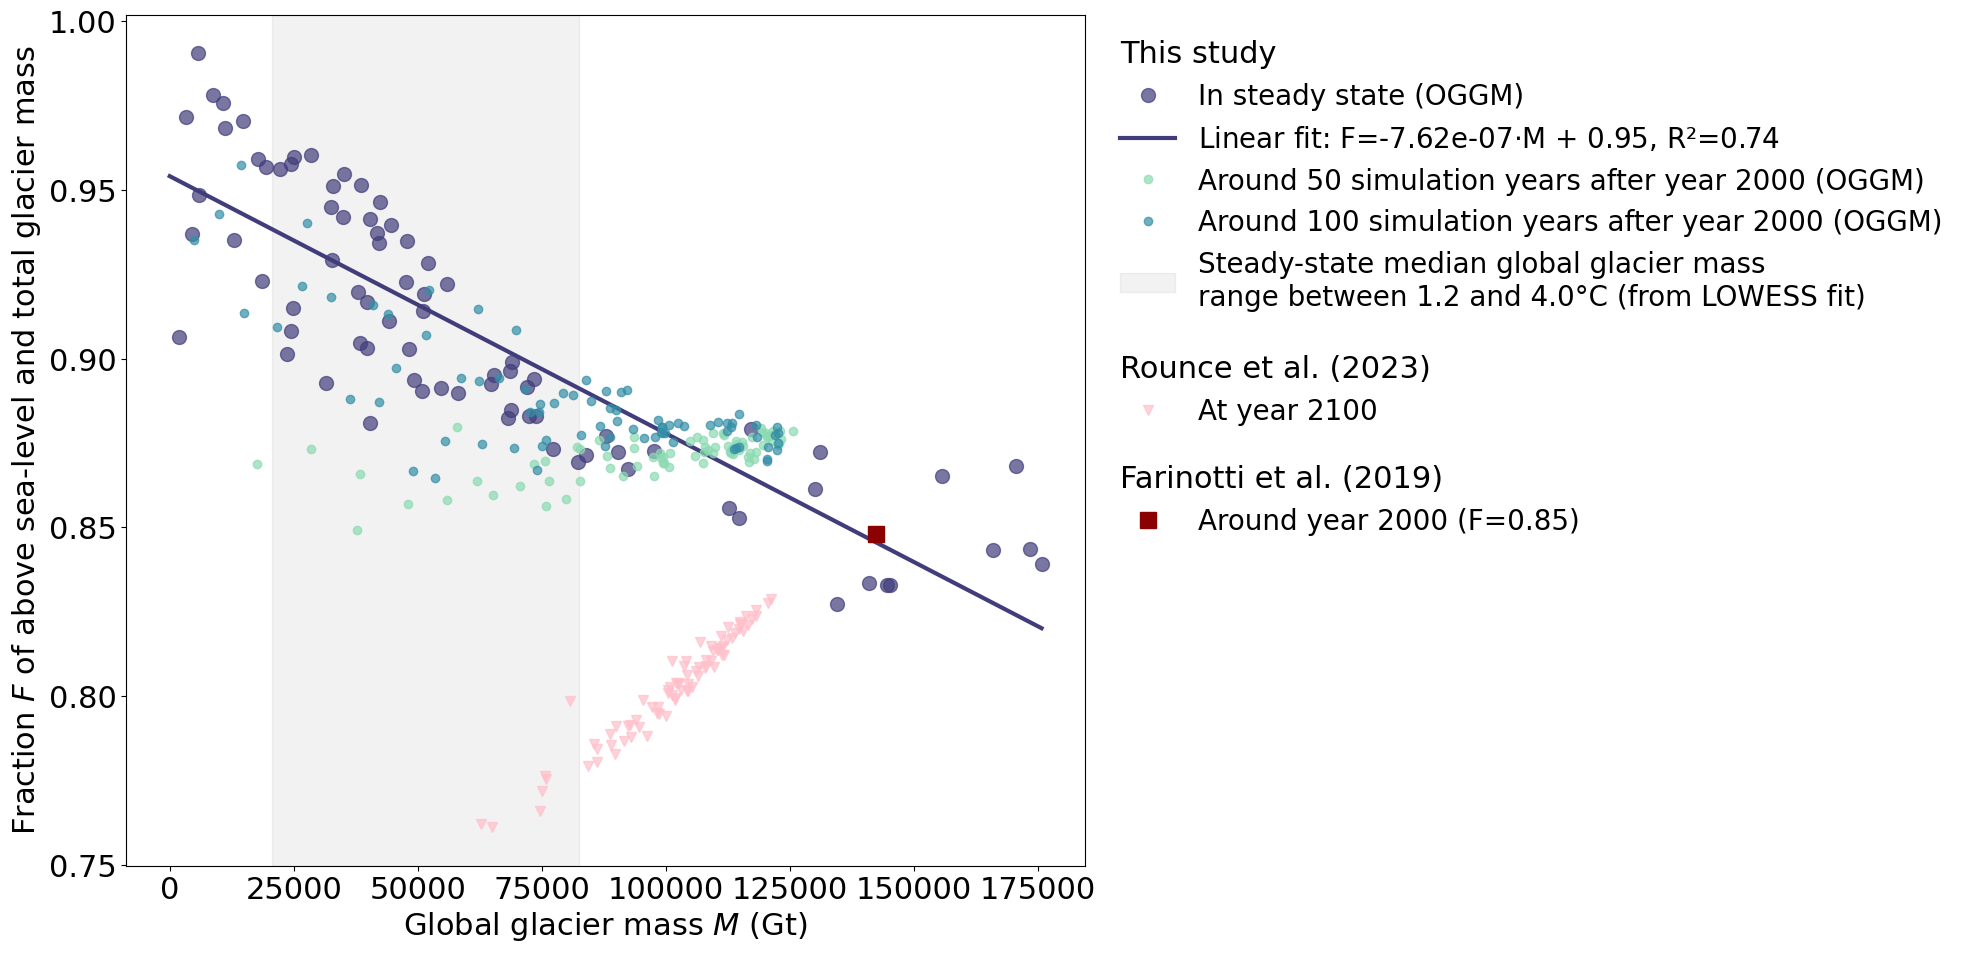

In [113]:
import scipy
import seaborn as sns

km3_to_gt = 900 * 1e-3# km3 -> Gt
m3_to_gt = 900 * 1e-12# km3 -> Gt


#### farinotti estimates 
vol_itmix_m3_reg = df_itmix['vol_itmix_m3'].sum()
vol_bsl_itmix_m3 = df_itmix['vol_bsl_itmix_m3'].sum()
below_sl_ratio = vol_bsl_itmix_m3/vol_itmix_m3_reg
y_farinotti = (vol_itmix_m3_reg- vol_bsl_itmix_m3)*m3_to_gt
x_farinotti = vol_itmix_m3_reg*m3_to_gt
print(rgi_reg,below_sl_ratio)

plot_lowess = False
plot_additional_stuff = False
from moepy import lowess, eda
from matplotlib.gridspec import GridSpec
plt.rcParams.update({'font.size': 22})
j = 0
#fig, axs = plt.subplots(1,1,figsize=(20,10))
fig = plt.figure(figsize=(20, 10))
gs = GridSpec(1, 2, width_ratios=[7.5, 2.5])  # 70% for the plot, 30% for the legend

# Create the main plot area
ax = fig.add_subplot(gs[0])
#ax = axs


###################unfilled OGGM 
pd_slr_oggm_all_reg_ss_global['ratio_vol_asl_total'] = (pd_slr_oggm_all_reg_ss_global['volume_km3'] - pd_slr_oggm_all_reg_ss_global['volume_km3_bsl'])/pd_slr_oggm_all_reg_ss_global['volume_km3']
x = pd_slr_oggm_all_reg_ss_global.volume_km3*km3_to_gt#/1e9
y = pd_slr_oggm_all_reg_ss_global.ratio_vol_asl_total
ax.plot(x, y, 'o', ms=10,
         color=sns.color_palette('mako')[-5], label='In steady state (OGGM)', # , this study
         alpha = 0.7) # unfilled
res = scipy.stats.linregress(x,y)

print(res)
slope_unfilled, intercept_unfilled, r, p, se = res
r2 = np.square(r)
_x = np.arange(0,x.max(),1)
fit = _x*slope_unfilled + intercept_unfilled
fit[fit>1] = 1
fit[fit<0.7] = 0.7
ax.plot(_x, fit, color=sns.color_palette('mako')[-5],
         label=f'Linear fit: F={slope_unfilled:0.2e}'+r'$\cdot$M + ' + f'{intercept_unfilled.round(3):0.2f}, R²={r2.round(2)}',
         lw=3)

if plot_lowess: 
    df_quantiles = lowess.quantile_model(np.concatenate([x]),#x_f,
                                                         #x_0]),
                                         np.concatenate([y,#y_f,
                                                        ]), #y_0]),
                                         x_pred= _x,
                                         frac=0.9,
                                         num_fits=200, robust_iters=1,
                                         qs=[0.5])
    fit_lowess = df_quantiles[0.5]
    fit_lowess_x = _x #df_quantiles.index
    #fit_lowess[(fit_lowess_x-fit_lowess)<0] = fit_lowess_x[(fit_lowess_x-fit_lowess)<0]
    #fit_lowess[fit_lowess<0] = 0
    ax.plot(fit_lowess_x, fit_lowess, label= 'LOWESS (frac=0.9)\n(using OGGM unfilled - steady state)', lw=3, ls = '-.', color='green', zorder=10)

# get these estimates better from the upper plot ...
#df_quantiles['volume_km3'] = _x.round(0).astype(int)
#df_quantiles = df_quantiles.set_index('volume_km3')
#df_quantiles.rename(columns={'0.5':'ratio_ss_volume_asl_total'})
#df_quantiles.to_csv('OGGM_gmip3_unfilled_ratio_asl_total_volume.csv')




if plot_additional_stuff:
    ### oGGM after 2000 years 
    pd_slr_oggm_reg_sel = pd_slr_oggm_all_global_ss # pd_slr_oggm_reg.loc[pd_slr_oggm_reg.rgi_reg == rgi_reg]
    x = pd_slr_oggm_reg_sel.volume_km3.values*km3_to_gt
    y = (pd_slr_oggm_reg_sel.volume_km3.values - pd_slr_oggm_reg_sel.volume_km3_bsl.values)*km3_to_gt

    ax = axs #[j]
    ax.plot(x,y/x, 'o', color='grey',
            label='OGGM GMIP3 unfilled\n(after 2000 simulation years)', alpha = 0.8, zorder=2)



    _x_l = np.arange(1000,x.max(),100)
    x_f = np.repeat(x_farinotti, 10)
    y_f = np.repeat(y_farinotti, 10)/x_f
    x_0 = np.repeat(0,len(x))
    y_0 = np.repeat(1,len(x))
    if plot_lowess: 
        df_quantiles = lowess.quantile_model(np.concatenate([x,#x_f,
                                                            ]), #, x_0]),
                                             np.concatenate([y/x]),#y_f,
                                                            # y_0]),
                                             x_pred= _x_l,
                                             frac=0.9,
                                             num_fits=200, robust_iters=1,
                                             qs=[0.5])
        fit_lowess = df_quantiles[0.5]
        fit_lowess_x = _x_l #df_quantiles.index
        #fit_lowess[(fit_lowess_x-fit_lowess)<0] = fit_lowess_x[(fit_lowess_x-fit_lowess)<0]
        #fit_lowess[fit_lowess<0] = 0
        ax.plot(fit_lowess_x, fit_lowess, label= 'LOWESS (frac=0.9)\n(using OGGM after 2000 years)', lw=3, ls = '-.', color='grey', zorder=10)


#### OGGM after 50/100 simulation years
color_o = {0:sns.color_palette('mako')[-1],1:sns.color_palette('mako')[-3]}
for j, year in enumerate([50,100]):
    pd_slr_oggm_reg_sel = pd_slr_oggm_all_global.loc[pd_slr_oggm_all_global.year == year] # pd_slr_oggm_reg.loc[pd_slr_oggm_reg.rgi_reg == rgi_reg]
    x = pd_slr_oggm_reg_sel.volume_km3.values*km3_to_gt
    y = (pd_slr_oggm_reg_sel.volume_km3.values - pd_slr_oggm_reg_sel.volume_km3_bsl.values)*km3_to_gt

    ax.plot(x,y/x, 'o', color=color_o[j], ms=6,
            label=f'Around {year} simulation years after year 2000 (OGGM)', #, this study)',
            alpha = 0.7, zorder=2) # unfilled -> too much info 



    if plot_lowess: 
        _x_l = np.arange(1000,x.max(),100)
        x_f = np.repeat(x_farinotti, 10)
        y_f = np.repeat(y_farinotti, 10)/x_f
        x_0 = np.repeat(0,len(x))
        y_0 = np.repeat(1,len(x))
        df_quantiles = lowess.quantile_model(np.concatenate([x,#x_f,
                                                            ]), #, x_0]),
                                             np.concatenate([y/x]),#y_f,
                                                            # y_0]),
                                             x_pred= _x_l,
                                             frac=0.9,
                                             num_fits=200, robust_iters=1,
                                             qs=[0.5])
        fit_lowess = df_quantiles[0.5]
        fit_lowess_x = _x_l #df_quantiles.index
        #fit_lowess[(fit_lowess_x-fit_lowess)<0] = fit_lowess_x[(fit_lowess_x-fit_lowess)<0]
        #fit_lowess[fit_lowess<0] = 0
        ax.plot(fit_lowess_x, fit_lowess, label= f'LOWESS (frac=0.9)\n(using OGGM after {year} years)', 
                lw=3, ls = '-.', color=color_o[j], zorder=10)


    

ax.axvspan(pd_vol_glob_2020_m3*0.15*m3_to_gt, pd_vol_glob_2020_m3*0.60*m3_to_gt, color='grey', alpha = 0.1,
            label='Steady-state median global glacier mass\nrange between 1.2 and 4.0°C (from LOWESS fit)')

print(slope_unfilled*(pd_vol_glob_2020_m3*0.15*m3_to_gt)+ intercept_unfilled)
print(slope_unfilled*(pd_vol_glob_2020_m3*0.60*m3_to_gt)+ intercept_unfilled)

    
##########################################
ds_rounce_rcps = xr.open_dataset('/home/www/lschuster/rounce_2023_data/Global_reg_allvns_50sets_2000_2100-rcps.nc')
ds_rounce_ssps = xr.open_dataset('/home/www/lschuster/rounce_2023_data/Global_reg_allvns_50sets_2000_2100-ssps.nc')
_x_rounce_l = []
_ratio_rounce_l = []
for j,ds_rounce in enumerate([ds_rounce_rcps, ds_rounce_ssps]): 
    ds_rounce = ds_rounce.sum(dim='region', min_count=19).sel(year=2100)

    x_rounce = ds_rounce.reg_mass_annual *1e-12 ##/900 / 1e9  # kg /m3
    y_rounce = (ds_rounce.reg_mass_annual - ds_rounce.reg_mass_bsl_annual)*1e-12
    if j ==0: 
        ax.plot(x_rounce.values.squeeze().flatten(),
                 y_rounce.values.squeeze().flatten()/x_rounce.values.squeeze().flatten(), 'v',
                 ms=7,
                 label='At year 2100', #  (Rounce et al., 2023)
                 color='pink', alpha =0.7, zorder = 1)
    else:
        ax.plot(x_rounce.values.squeeze().flatten(),
                 y_rounce.values.squeeze().flatten()/x_rounce.values.squeeze().flatten(), 'v', #label='Rounce et al., 2023\n(2020-2101)', 
                         color='pink', alpha =0.7, zorder = 1, ms=7)
    _x_rounce_l.append(x_rounce.values.squeeze().flatten())
    _ratio_rounce_l.append(y_rounce.values.squeeze().flatten()/x_rounce.values.squeeze().flatten())

# Perform linear fit with forced intercept at zero
_ratio = np.concatenate(_ratio_rounce_l)
_x_s = np.concatenate(_x_rounce_l)
slope = np.dot(_x_s[~np.isnan(_ratio)], 
               _ratio[~np.isnan(_ratio)]*_x_s[~np.isnan(_ratio)]) / np.dot(_x_s[~np.isnan(_ratio)], _x_s[~np.isnan(_ratio)])
_x = np.arange(0,_x_s[~np.isnan(_ratio)].max(),1)
fit = _x*slope #+ #intercept
#fit[_x-fit<0] = 0 # below sea level should be above zero 
#fit[fit<0] = 0 # if above sea level is below zero -> set it equal tabove sea level should be above zero 

#plt.plot(_x, fit/_x, color='blue', label=f'Linear Fit (Rounce et al., 2023):\n'+r'V$_{asl}$'+f'= {slope:0.2f}*V', lw=3)


#######################################

# Performing linear regression
#slope, intercept = np.polyfit(x, y, 1)
#_x = np.arange(0,x.max(),0.1)
# Perform linear fit with forced intercept at zero
slope = np.dot(x, y) / np.dot(x, x)
_x = np.arange(0,x.max(),1)
fit = _x*slope #+ #intercept
#fit[_x-fit<0] = 0 # below sea level should be above zero 
#fit[fit<0] = 0 # if above sea level is below zero -> set it equal tabove sea level should be above zero 

#ax.plot(_x, fit/_x, color='black', label=f'Linear Fit (only OGGM):\n'+r'V$_{asl}$'+f'= {slope:0.2f}*V', lw=3)

ax.set_xlabel(f'Global glacier mass $M$ (Gt)')
ax.set_ylabel(r'Fraction $F$ of above sea-level and total glacier mass')


#farinotti_intercept= (vol_itmix_m3_reg/1e9- vol_bsl_itmix_m3/1e9)-  vol_itmix_m3_reg/1e9*slope
#fit_f = _x*slope + farinotti_intercept
#fit_f[_x-fit_f<0] = _x[_x-fit_f<0] # if below sea level would get below zero, set it instead to zero 
#fit_f[fit_f<0] = 0  # above sea level should be above zero 

#ax.plot(_x, fit_f, color='blue',
#         label=f'Linear Fit, rescaled to\nFarinotti et al., 2019:\n'+r'V$_{asl}$'+f'={slope:0.2f}*V +{farinotti_intercept:0.1f}\n'+r'(and V$_{bsl}$≥0 & V$_{asl}$≥0)', lw=3)
reg_name = d_reg_num_name_sh[rgi_reg]
reg_name = reg_name.replace('\n',' ')
#ax.set_title('Globally')
#ax.axhline(1, color='grey', linestyle=':', label='ratio of 1', alpha = 0.5)

#ax.set_aspect('equal', adjustable='box')
#ax.text(0.98,0.02, 
#        f'Farinotti et al. (2019)\nabove sea-level ratio\nat inventory date: {(1-below_sl_ratio).round(2)}', 
#        va = 'bottom', ha='right',
#        transform=ax.transAxes)
# Set xticks and yticks to be equal
#max_value = max(max(x), max(y))
#max_value = int(np.ceil(max_value))
#ax.set_xticks(range(max_value + 1))
#ax.set_yticks(range(max_value + 1))

oggm_2000_lowess = False
if oggm_2000_lowess:  
    df_quantiles_two = lowess.quantile_model(np.concatenate([x,x_f,
                                                         x_0]),
                                         np.concatenate([y/x,y_f,
                                                         y_0]),
                                         x_pred= _x_l,
                                         frac=0.9,
                                         num_fits=500, robust_iters=2,
                                         qs=[0.5])
    fit_lowess_two = df_quantiles_two[0.5]
    fit_lowess_x = _x_l #df_quantiles.index
    #fit_lowess[(fit_lowess_x-fit_lowess)<0] = fit_lowess_x[(fit_lowess_x-fit_lowess)<0]
    #fit_lowess[fit_lowess<0] = 0
    ax.plot(fit_lowess_x, fit_lowess_two, label= 'LOWESS (frac=0.9)\n(using OGGM and Farinotti et al.,2019)', lw=3, ls = '-.', color='pink', zorder=10)
    
    
    #ax.plot(fit_lowess_x, fit_lowess, label= 'LOWESS (frac=0.3)\n(using OGGM + constraints)', lw=3, ls = '-.', color='black', zorder=10)


if plot_additional_stuff:
    x = pd_oggm_v16_asl_bsl_global_ss.volume_m3 *m3_to_gt
    y = pd_oggm_v16_asl_bsl_global_ss.ratio_vol_asl_total
    ax.plot(x, y, 'o', color='blue', label='OGGM GMIP3 filled - steady state',alpha = 0.7)
    slope, intercept = np.polyfit(x, y, 1)
    _x = np.arange(0,x.max(),1)
    fit = _x*slope + intercept
    fit[fit>1] = 1
    fit[fit<0.7] = 0.7
    ax.plot(_x, fit, color='blue', label=f'Linear Fit OGGM GMIP3 filled:\nratio= {slope:0.2e}'+r'$\cdot$M(Gt) + ' + f'{intercept.round(3):0.2f}', lw=3)

    if plot_lowess: 
        df_quantiles = lowess.quantile_model(np.concatenate([x]),#x_f,
                                                             #x_0]),
                                             np.concatenate([y#y_f,
                                                            ]), #y_0]),
                                             x_pred= _x,
                                             frac=0.9,
                                             num_fits=200, robust_iters=1,
                                             qs=[0.5])
        fit_lowess = df_quantiles[0.5]
        fit_lowess_x = _x #df_quantiles.index
        #fit_lowess[(fit_lowess_x-fit_lowess)<0] = fit_lowess_x[(fit_lowess_x-fit_lowess)<0]
        #fit_lowess[fit_lowess<0] = 0
        ax.plot(fit_lowess_x, fit_lowess, label= 'LOWESS (frac=0.9)\n(using OGGM filled - steady state)', lw=3, ls = '-.', color='blue', zorder=10)


#### farinotti estimates 
vol_itmix_m3_reg = df_itmix['vol_itmix_m3'].sum()
vol_bsl_itmix_m3 = df_itmix['vol_bsl_itmix_m3'].sum()
below_sl_ratio = vol_bsl_itmix_m3/vol_itmix_m3_reg
y_farinotti = (vol_itmix_m3_reg- vol_bsl_itmix_m3)*m3_to_gt
x_farinotti = vol_itmix_m3_reg*m3_to_gt
print(rgi_reg,below_sl_ratio)

ax.plot(x_farinotti, y_farinotti/x_farinotti, 's', ms=12,color='darkred',
        label='Around year 2000 (F=0.85)') # FARINOTTI et al., 2019
#ax.axvline(x_farinotti, color = 'red', ls= '--',  label='Farinotti et al. (2019)\nat inventory date' )
#ax.axhline(y_farinotti/x_farinotti, color='darkred', lw=4, label=f'constant ratio of {(1-below_sl_ratio).round(2)}\n(Farinotti et al., 2019)')
    
#plt.plot(_x, _x*(1-below_sl_ratio)/_x, color='darkred', lw=4, label=f'constant ratio (Farinotti et al., 2019):\n'+r'V$_{asl}$' + f'={(1-below_sl_ratio).round(2)}' )
#ax.axvline(pd_vol_glob_m3/1e9, ls = '--', color='green')
# 40 85
        

handles, labels = ax.get_legend_handles_labels()
#ax.legend(loc='upper left', fontsize=18, bbox_to_anchor=(1.02,1))

leg_this_study = ax.legend(handles[:5], labels[:5], title='This study', loc='upper left', 
                          fontsize=20, bbox_to_anchor=(1.01,1), frameon=False)
leg_rounce = ax.legend([handles[5]], [labels[5]], title='Rounce et al. (2023)', frameon=False,
                       loc='upper left', fontsize=20, bbox_to_anchor=(1.01,0.63))
leg_farinotti = ax.legend([handles[6]], [labels[6]], title='Farinotti et al. (2019)',loc='upper left', 
                          fontsize=20, bbox_to_anchor=(1.01,0.5), frameon=False)
leg_this_study._legend_box.align = "left"
leg_rounce._legend_box.align = "left"

leg_farinotti._legend_box.align = "left"
ax.add_artist(leg_this_study)
ax.add_artist(leg_rounce)
plt.tight_layout()
plt.savefig('sl_ratio_estimate_supplements_only_final_state.png')
plt.savefig('sl_ratio_estimate_supplements_only_final_state.pdf')

In [39]:
### copy this to 6_csv_tables... 
slope_unfilled = -6.859874897888118*1e-7 * 1e-9 #km3 to 
intercept_unfilled = 0.9540695779131956

### volume at farinotti et al. data

ratio_farinotti = 1- df_itmix.sum()['vol_bsl_itmix_m3']/df_itmix.sum()['vol_itmix_m3'] 
vol = df_itmix.sum()['vol_itmix_m3'] 

ratio = slope_unfilled*vol + intercept_unfilled 
if ratio <0.7:
    ratio = 0.7
print(ratio, ratio_farinotti)

np.testing.assert_allclose(ratio,ratio_farinotti, rtol=0.01) #

0.8455761299994473 0.848064482627909


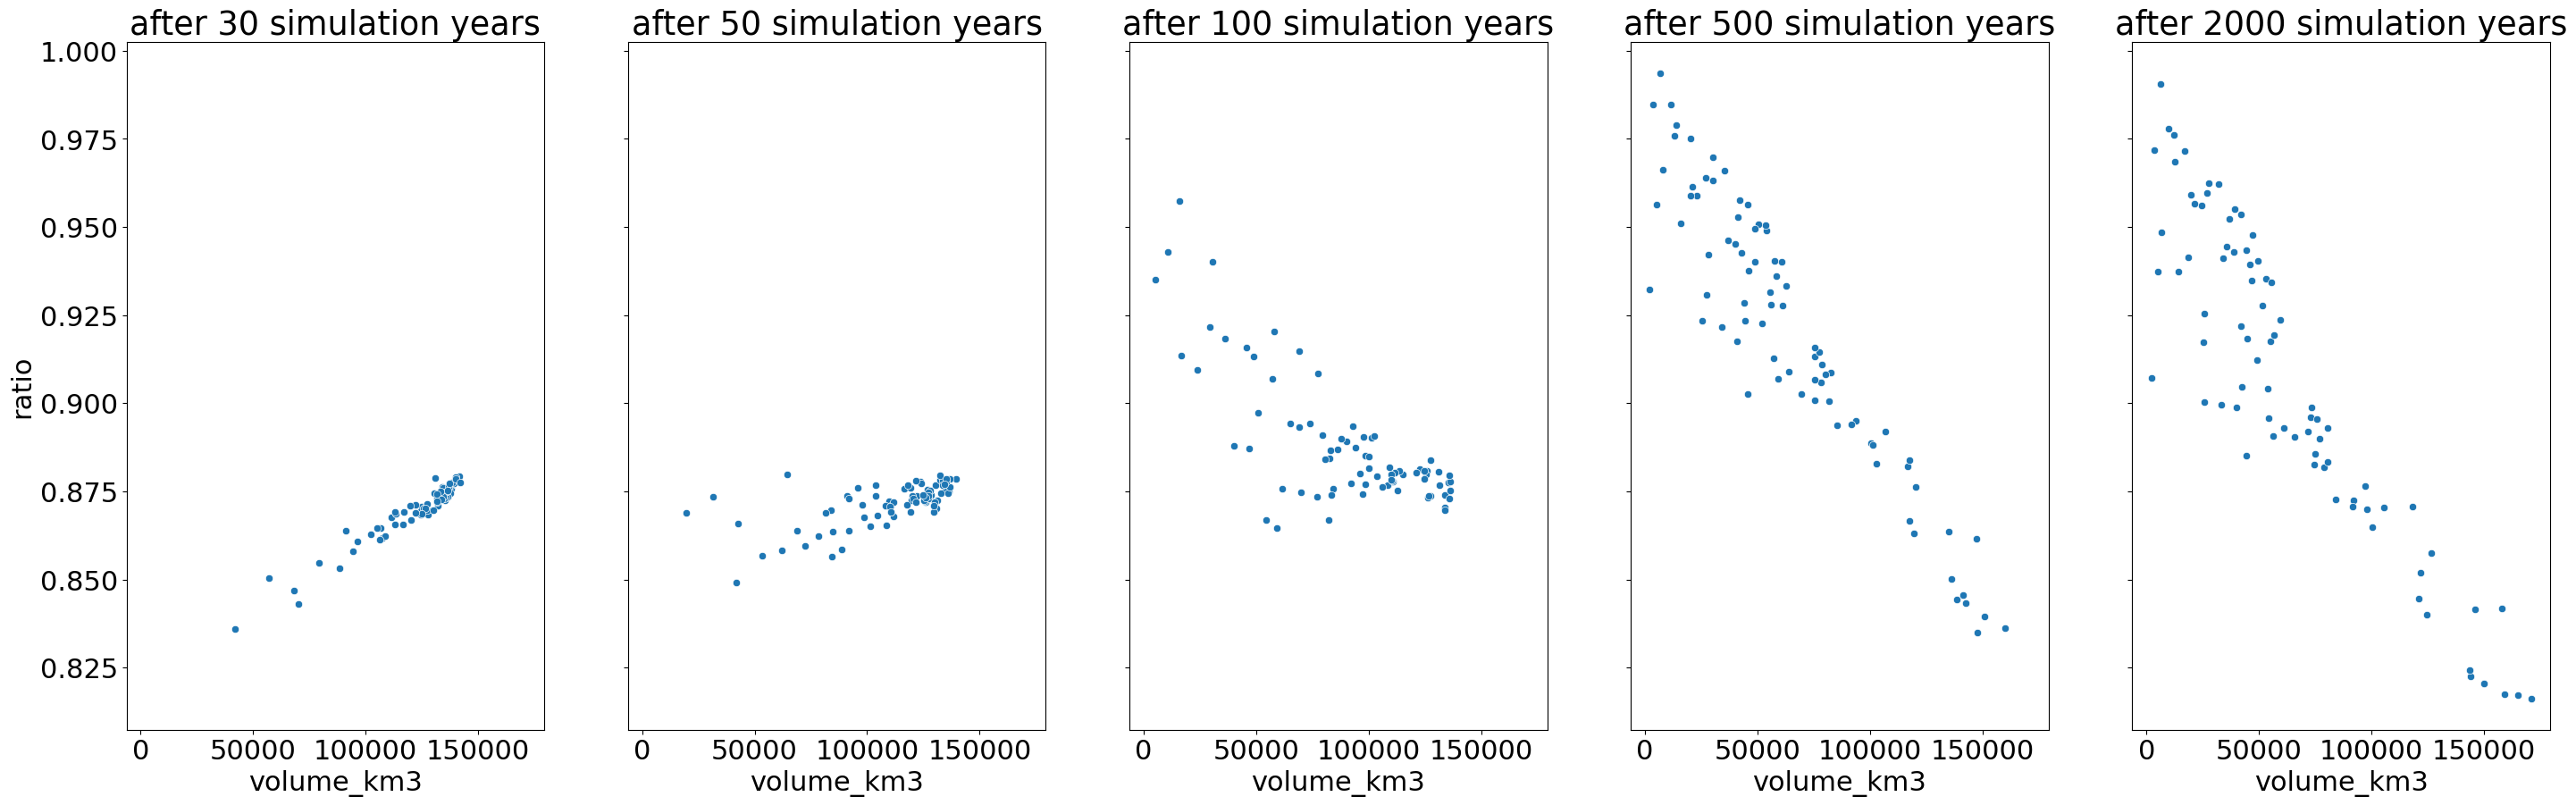

In [43]:
import seaborn as sns
pd_slr_oggm_reg_sel = pd_slr_oggm_all_reg.loc[pd_slr_oggm_all_reg.year <=2000].groupby(['gcm','period','ssp', 'year']).sum().reset_index()

pd_slr_oggm_reg_sel['ratio'] = (pd_slr_oggm_reg_sel['volume_km3']- pd_slr_oggm_reg_sel['volume_km3_bsl']) / pd_slr_oggm_reg_sel['volume_km3']
fig,axs = plt.subplots(1,5,figsize=(35,10), sharey=True, sharex=True)
sns.scatterplot(data=pd_slr_oggm_reg_sel.loc[pd_slr_oggm_reg_sel.year==30], x='volume_km3', y= 'ratio', ax = axs[0]) # palette='coolwarm')
axs[0].set_title('after 30 simulation years')


sns.scatterplot(data=pd_slr_oggm_reg_sel.loc[pd_slr_oggm_reg_sel.year==50], x='volume_km3', y= 'ratio', ax = axs[1]) # palette='coolwarm')
axs[1].set_title('after 50 simulation years')

sns.scatterplot(data=pd_slr_oggm_reg_sel.loc[pd_slr_oggm_reg_sel.year==100], x='volume_km3', y= 'ratio', ax = axs[2]) # palette='coolwarm')
axs[2].set_title('after 100 simulation years')

sns.scatterplot(data=pd_slr_oggm_reg_sel.loc[pd_slr_oggm_reg_sel.year==500], x='volume_km3', y= 'ratio', ax = axs[3]) # palette='coolwarm')
axs[3].set_title('after 500 simulation years')

axs[4].set_title('after 2000 simulation years')
sns.scatterplot(data=pd_slr_oggm_reg_sel.loc[pd_slr_oggm_reg_sel.year==2000], x='volume_km3', y= 'ratio', ax = axs[4]) # palette='coolwarm')
plt.savefig('above_sl_ratio_evolution_gmip3_oggm.png')

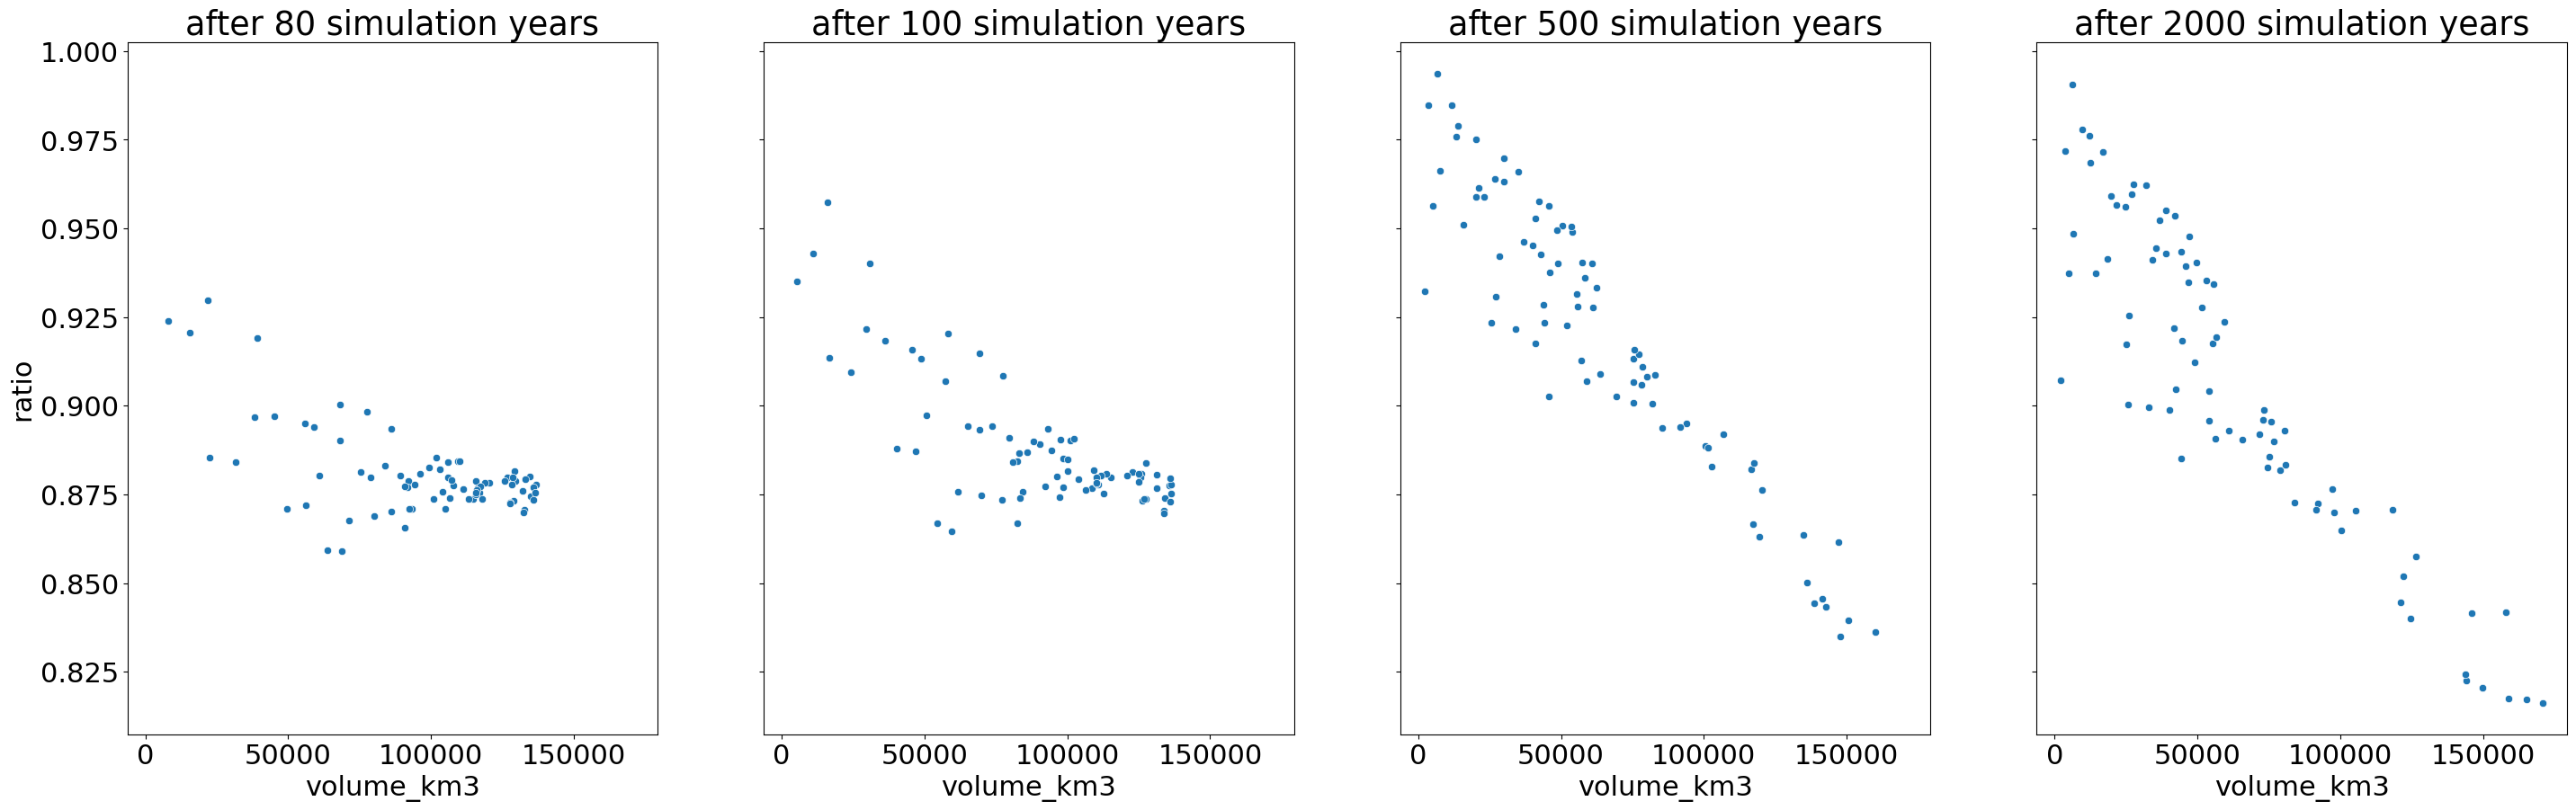

In [78]:
import seaborn as sns
pd_slr_oggm_reg_sel = pd_slr_oggm_all_reg.loc[pd_slr_oggm_all_reg.year <=2000].groupby(['gcm','period','ssp', 'year']).sum().reset_index()

pd_slr_oggm_reg_sel['ratio'] = (pd_slr_oggm_reg_sel['volume_km3']- pd_slr_oggm_reg_sel['volume_km3_bsl']) / pd_slr_oggm_reg_sel['volume_km3']
fig,axs = plt.subplots(1,4,figsize=(35,10), sharey=True, sharex=True)

sns.scatterplot(data=pd_slr_oggm_reg_sel.loc[pd_slr_oggm_reg_sel.year==80], x='volume_km3', y= 'ratio', ax = axs[0]) # palette='coolwarm')
axs[0].set_title('after 80 simulation years')

sns.scatterplot(data=pd_slr_oggm_reg_sel.loc[pd_slr_oggm_reg_sel.year==100], x='volume_km3', y= 'ratio', ax = axs[1]) # palette='coolwarm')
axs[1].set_title('after 100 simulation years')

sns.scatterplot(data=pd_slr_oggm_reg_sel.loc[pd_slr_oggm_reg_sel.year==500], x='volume_km3', y= 'ratio', ax = axs[2]) # palette='coolwarm')
axs[2].set_title('after 500 simulation years')

axs[3].set_title('after 2000 simulation years')
sns.scatterplot(data=pd_slr_oggm_reg_sel.loc[pd_slr_oggm_reg_sel.year==2000], x='volume_km3', y= 'ratio', ax = axs[3]) # palette='coolwarm')
plt.savefig('above_sl_ratio_evolution_gmip3_oggm.png')

19 0.15193551737209102


/tmp/ipykernel_3959837/820658382.py:127: RuntimeWarning: invalid value encountered in divide
  plt.plot(_x, _x*(1-below_sl_ratio)/_x, color='darkred', lw=4, label=f'Linear Fit (Farinotti et al., 2019):\n'+r'V$_{asl}$' + f'={(1-below_sl_ratio).round(2)}' )


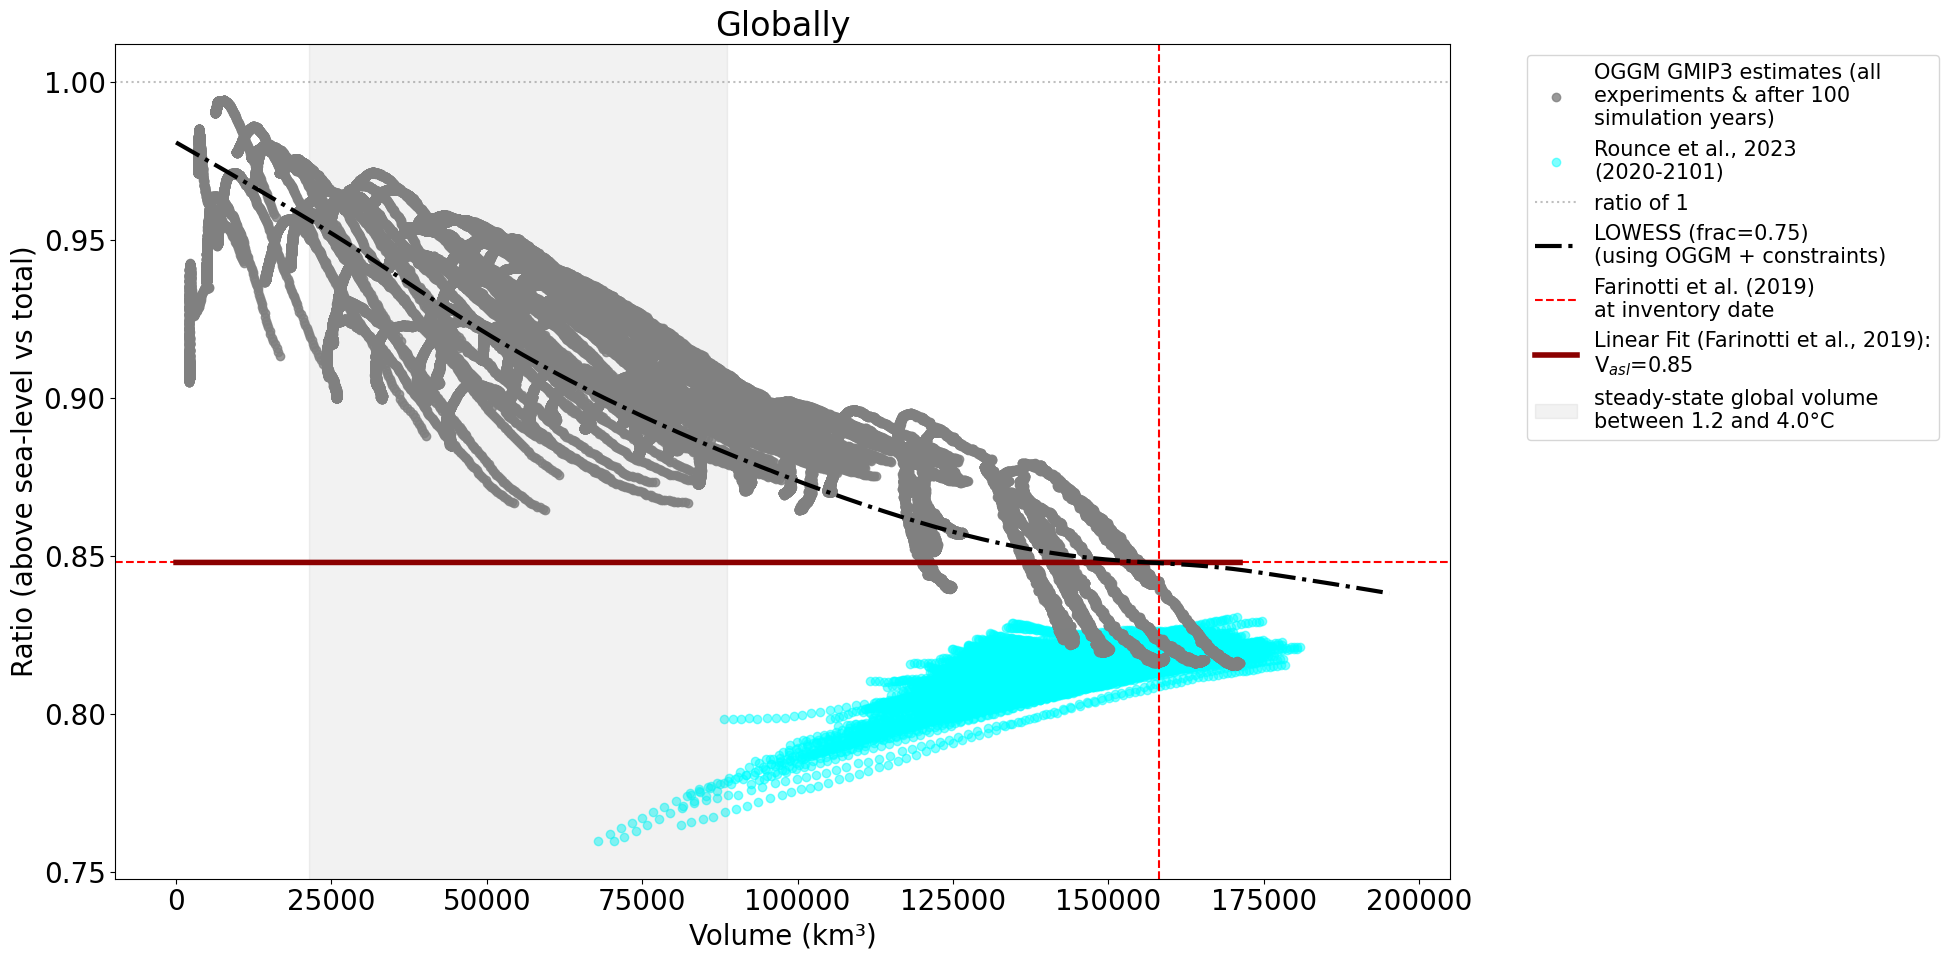

In [40]:
plt.rcParams.update({'font.size': 20})
j = 0
fig, axs = plt.subplots(1,1,figsize=(20,10))
#axs = axs.flatten()
vol_itmix_m3_reg = df_itmix['vol_itmix_m3'].sum()
vol_bsl_itmix_m3 = df_itmix['vol_bsl_itmix_m3'].sum()
below_sl_ratio = vol_bsl_itmix_m3/vol_itmix_m3_reg
print(rgi_reg,below_sl_ratio)
pd_slr_oggm_reg_sel = pd_slr_oggm_all_global # pd_slr_oggm_reg.loc[pd_slr_oggm_reg.rgi_reg == rgi_reg]
x = pd_slr_oggm_reg_sel.volume_km3.values
y = pd_slr_oggm_reg_sel.volume_km3.values - pd_slr_oggm_reg_sel.volume_km3_bsl.values

ax = axs #[j]
ax.plot(x,y/x, 'o', color='grey',
        label='OGGM GMIP3 estimates (all\nexperiments & after 100\nsimulation years)', alpha = 0.8, zorder=2)


##########################################
ds_rounce_rcps = xr.open_dataset('/home/www/lschuster/rounce_2023_data/Global_reg_allvns_50sets_2000_2100-rcps.nc')
ds_rounce_ssps = xr.open_dataset('/home/www/lschuster/rounce_2023_data/Global_reg_allvns_50sets_2000_2100-ssps.nc')
_x_rounce_l = []
_ratio_rounce_l = []
for j,ds_rounce in enumerate([ds_rounce_rcps, ds_rounce_ssps]): 
    ds_rounce = ds_rounce.sum(dim='region', min_count=19).sel(year=slice(2020,2102))

    x_rounce = ds_rounce.reg_mass_annual/900 / 1e9  # kg /m3
    y_rounce = (ds_rounce.reg_mass_annual/900 - ds_rounce.reg_mass_bsl_annual/900)/1e9
    if j == 0: 
        plt.plot(x_rounce.values.squeeze().flatten(),
                 y_rounce.values.squeeze().flatten()/x_rounce.values.squeeze().flatten(), 'o', label='Rounce et al., 2023\n(2020-2101)', 
                 color='cyan', alpha =0.5, zorder = 1)
    else:
        plt.plot(x_rounce.values.squeeze().flatten(),
                 y_rounce.values.squeeze().flatten()/x_rounce.values.squeeze().flatten(), 'o', #label='Rounce et al., 2023\n(2020-2101)', 
                 color='cyan', alpha =0.5, zorder = 1)
    _x_rounce_l.append(x_rounce.values.squeeze().flatten())
    _ratio_rounce_l.append(y_rounce.values.squeeze().flatten()/x_rounce.values.squeeze().flatten())

# Perform linear fit with forced intercept at zero
_ratio = np.concatenate(_ratio_rounce_l)
_x_s = np.concatenate(_x_rounce_l)
slope = np.dot(_x_s[~np.isnan(_ratio)], 
               _ratio[~np.isnan(_ratio)]*_x_s[~np.isnan(_ratio)]) / np.dot(_x_s[~np.isnan(_ratio)], _x_s[~np.isnan(_ratio)])
_x = np.arange(0,_x_s[~np.isnan(_ratio)].max(),1)
fit = _x*slope #+ #intercept
#fit[_x-fit<0] = 0 # below sea level should be above zero 
#fit[fit<0] = 0 # if above sea level is below zero -> set it equal tabove sea level should be above zero 

#plt.plot(_x, fit/_x, color='blue', label=f'Linear fit (Rounce et al., 2023):\n'+r'V$_{asl}$'+f'= {slope:0.2f}*V', lw=3)
plt.legend()


#######################################



# Performing linear regression
#slope, intercept = np.polyfit(x, y, 1)
#_x = np.arange(0,x.max(),0.1)
# Perform linear fit with forced intercept at zero
slope = np.dot(x, y) / np.dot(x, x)
_x = np.arange(0,x.max(),1)
fit = _x*slope #+ #intercept
#fit[_x-fit<0] = 0 # below sea level should be above zero 
#fit[fit<0] = 0 # if above sea level is below zero -> set it equal tabove sea level should be above zero 

#ax.plot(_x, fit/_x, color='black', label=f'Linear fit (only OGGM):\n'+r'V$_{asl}$'+f'= {slope:0.2f}*V', lw=3)

ax.set_xlabel(f'Volume (km³)')
ax.set_ylabel(f'Ratio (above sea-level vs total)')


#farinotti_intercept= (vol_itmix_m3_reg/1e9- vol_bsl_itmix_m3/1e9)-  vol_itmix_m3_reg/1e9*slope
#fit_f = _x*slope + farinotti_intercept
#fit_f[_x-fit_f<0] = _x[_x-fit_f<0] # if below sea level would get below zero, set it instead to zero 
#fit_f[fit_f<0] = 0  # above sea level should be above zero 

#ax.plot(_x, fit_f, color='blue',
#         label=f'Linear Fit, rescaled to\nFarinotti et al., 2019:\n'+r'V$_{asl}$'+f'={slope:0.2f}*V +{farinotti_intercept:0.1f}\n'+r'(and V$_{bsl}$≥0 & V$_{asl}$≥0)', lw=3)
reg_name = d_reg_num_name_sh[rgi_reg]
reg_name = reg_name.replace('\n',' ')
ax.set_title('Globally')
ax.axhline(1, color='grey', linestyle=':', label='ratio of 1', alpha = 0.5)

#ax.set_aspect('equal', adjustable='box')
#ax.text(0.98,0.02, 
#        f'Farinotti et al. (2019)\nabove sea-level ratio\nat inventory date: {(1-below_sl_ratio).round(2)}', 
#        va = 'bottom', ha='right',
#        transform=ax.transAxes)
# Set xticks and yticks to be equal
#max_value = max(max(x), max(y))
#max_value = int(np.ceil(max_value))
#ax.set_xticks(range(max_value + 1))
#ax.set_yticks(range(max_value + 1))


lowess = False
y_f = (vol_itmix_m3_reg/1e9- vol_bsl_itmix_m3/1e9)
x_f = vol_itmix_m3_reg/1e9
_x_l = np.arange(1000,x.max(),100)

if lowess:
    x_f = np.repeat(x_f, len(x))
    y_f = np.repeat(y_f, len(x))/x_f
    x_0 = np.repeat(0,len(x))
    y_0 = np.repeat(1,len(x))
    from moepy import lowess, eda
    df_quantiles = lowess.quantile_model(np.concatenate([x,#x_f,
                                                         x_0]),
                                         np.concatenate([y/x,#y_f,
                                                         y_0]),
                                         x_pred= _x_l,
                                         frac=0.75,
                                         num_fits=200, robust_iters=1,
                                         qs=[0.5])
    fit_lowess = df_quantiles[0.5]
    fit_lowess_x = _x_l #df_quantiles.index
    #fit_lowess[(fit_lowess_x-fit_lowess)<0] = fit_lowess_x[(fit_lowess_x-fit_lowess)<0]
    #fit_lowess[fit_lowess<0] = 0
    ax.plot(fit_lowess_x, fit_lowess, label= 'LOWESS (frac=0.75)\n(using OGGM + constraints)', lw=3, ls = '-.', color='black', zorder=10)
else:
    ax.plot(fit_lowess_x, fit_lowess, label= 'LOWESS (frac=0.75)\n(using OGGM + constraints)', lw=3, ls = '-.', color='black', zorder=10)

    #ax.plot(fit_lowess_x, fit_lowess, label= 'LOWESS (frac=0.3)\n(using OGGM + constraints)', lw=3, ls = '-.', color='black', zorder=10)
ax.axvline(vol_itmix_m3_reg/1e9, color = 'red', ls= '--')
ax.axhline((vol_itmix_m3_reg/1e9- vol_bsl_itmix_m3/1e9)/(vol_itmix_m3_reg/1e9), color = 'red', ls= '--', label='Farinotti et al. (2019)\nat inventory date')
plt.plot(_x, _x*(1-below_sl_ratio)/_x, color='darkred', lw=4, label=f'Linear Fit (Farinotti et al., 2019):\n'+r'V$_{asl}$' + f'={(1-below_sl_ratio).round(2)}' )
    
#ax.axvline(pd_vol_glob_m3/1e9, ls = '--', color='green')

plt.axvspan(pd_vol_glob_2020_m3*0.14/1e9, pd_vol_glob_2020_m3*0.58/1e9, color='grey', alpha = 0.1, label='steady-state global volume\nbetween 1.2 and 4.0°C')

ax.legend(loc='upper left', fontsize=15, bbox_to_anchor=(1.05,1))
plt.tight_layout()
plt.savefig('sl_test_ratio.png')

**OLD???**

In [ ]:
periods_f = ['2021-2040', '2041-2060', '2061-2080', '2081-2100']
# use only average over last 100 years (or could instead do the fit over all years as well)... 
volume_l = []
volume_bsl_l = []
import matplotlib.pyplot as plt
for ssp in ['ssp126','ssp370','ssp585']: 
    for period in periods_f:
        with xr.open_dataset(f'/home/www/lschuster/runs_glacierMIP3_oggm_v16/output/RGI19/gfdl-esm4_{ssp}_{period}.nc') as ds:
            dst = ds.sel(time=slice(4900,5000)).load().mean(dim='time').sum(dim='rgi_id')
        plt.plot(dst.volume/1e9, dst.volume_bsl/1e9, 'o', color='k')
    volume_l.append(dst.volume/1e9)
    volume_bsl_l.append(dst.volume_bsl/1e9)
ssp = 'historical'
periods_h = ['1851-1870', '1901-1920', '1951-1970', '1995-2014']
for period in periods_h:
    with xr.open_dataset(f'/home/www/lschuster/runs_glacierMIP3_oggm_v16/output/RGI19/gfdl-esm4_{ssp}_{period}.nc') as ds:
        dst = ds.sel(time=slice(4900,5000)).load().mean(dim='time').sum(dim='rgi_id')
    plt.plot(dst.volume/1e9, dst.volume_bsl/1e9, 'o', color='k')
    volume_l.append(dst.volume/1e9)
    volume_bsl_l.append(dst.volume_bsl/1e9)
    
plt.plot(np.array(volume_l), np.array(volume_bsl_l), 'o', color='k')
    
x = np.array(volume_l)
y = np.array(volume_bsl_l)
# Performing linear regression
slope, intercept = np.polyfit(x, y, 1)
_x = np.arange(0,x.max(),1)
fit = _x*slope + intercept
fit[fit<0] = 0

plt.plot(_x, fit, color='red', label=f'Linear Fit: V_bsl = {slope:0.2f}*V {intercept:0.1f}\n(if negative, V_bsl=0)', lw=3)

plt.xlabel('RGI 19 volume (km³)')
plt.ylabel('RGI 19 volume below sea-level (km³)')
plt.axvline(vol_itmix_m3_reg/1e9)
plt.axhline(vol_bsl_itmix_m3/1e9)
plt.title('Steady-state RGI19 volume of OGGM v1.6.1')

plt.legend()

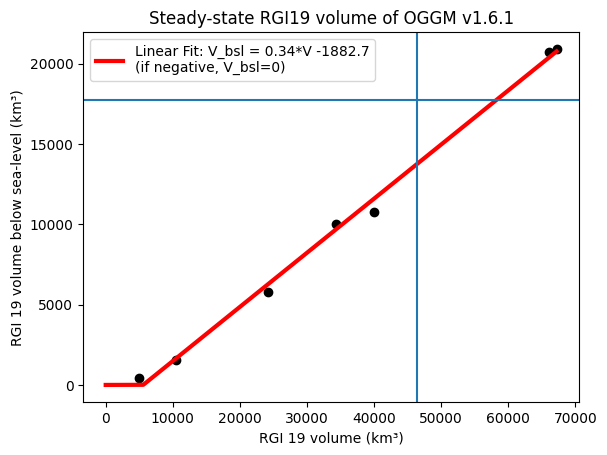

**fit over all years**

In [37]:
rgi_regs_bsl = []
for rgi_r in rgi_regs:
    if df_itmix.loc[df_itmix.rgi_region ==rgi_r]['vol_bsl_itmix_m3'].sum()>0:
        print(rgi_r, df_itmix.loc[df_itmix.rgi_region ==rgi_r]['vol_bsl_itmix_m3'].sum())
        rgi_regs_bsl.append(rgi_r)

01 1077419209097.3424
02 141287597.65625
03 1510514544606.145
04 118486012506.77226
05 1779488717821.3918
06 8049951813.812256
07 331362170072.89294
09 1402044179715.9492
10 616556414.2227173
17 38433929686.98531
19 17763048040791.7


In [184]:
np.concatenate(rgi_reg_l)

array(['01', '01', '01', ..., '19', '19', '19'], dtype='<U2')

In [169]:
rgi_reg_l = []

for rgi_reg in rgi_regs_bsl:
    gcms = ['gfdl-esm4', 'ipsl-cm6a-lr', 'mpi-esm1-2-hr', 'mri-esm2-0', 'ukesm1-0-ll' ]
    periods_f = ['2021-2040', '2041-2060', '2061-2080', '2081-2100']
    for gcm in gcms: 
        for ssp in ['ssp126','ssp370','ssp585']: 
            for period in periods_f:
                with xr.open_dataset(f'/home/www/lschuster/runs_glacierMIP3_oggm_v16/output/RGI{rgi_reg}/{gcm}_{ssp}_{period}.nc') as ds:
                    dst = ds.volume# = ds[['volume','volume_bsl']].sum(dim='rgi_id')
                #plt.plot(dst.volume/1e9, dst.volume_bsl/1e9, 'o', color='k')
                repeat_yrs = len(dst.time)
                rgi_reg_l.append(np.repeat(rgi_reg,repeat_yrs))

        ssp = 'historical'
        periods_h = ['1851-1870', '1901-1920', '1951-1970', '1995-2014']
        for period in periods_h:
            with xr.open_dataset(f'/home/www/lschuster/runs_glacierMIP3_oggm_v16/output/RGI{rgi_reg}/{gcm}_{ssp}_{period}.nc') as ds:
                dst = ds.volume #[['volume','volume_bsl']].sum(dim='rgi_id')
            repeat_yrs = len(dst.time)
            #plt.plot(dst.volume/1e9, dst.volume_bsl/1e9, 'o', color='k')
            rgi_reg_l.append(np.repeat(rgi_reg,repeat_yrs))
        print(gcm, rgi_reg)

gfdl-esm4 01
ipsl-cm6a-lr 01
mpi-esm1-2-hr 01
mri-esm2-0 01
ukesm1-0-ll 01
gfdl-esm4 02
ipsl-cm6a-lr 02
mpi-esm1-2-hr 02
mri-esm2-0 02
ukesm1-0-ll 02
gfdl-esm4 03
ipsl-cm6a-lr 03
mpi-esm1-2-hr 03
mri-esm2-0 03
ukesm1-0-ll 03
gfdl-esm4 04
ipsl-cm6a-lr 04
mpi-esm1-2-hr 04
mri-esm2-0 04
ukesm1-0-ll 04
gfdl-esm4 05
ipsl-cm6a-lr 05
mpi-esm1-2-hr 05
mri-esm2-0 05
ukesm1-0-ll 05
gfdl-esm4 06
ipsl-cm6a-lr 06
mpi-esm1-2-hr 06
mri-esm2-0 06
ukesm1-0-ll 06
gfdl-esm4 07
ipsl-cm6a-lr 07
mpi-esm1-2-hr 07
mri-esm2-0 07
ukesm1-0-ll 07
gfdl-esm4 09
ipsl-cm6a-lr 09
mpi-esm1-2-hr 09
mri-esm2-0 09
ukesm1-0-ll 09
gfdl-esm4 10
ipsl-cm6a-lr 10
mpi-esm1-2-hr 10
mri-esm2-0 10
ukesm1-0-ll 10
gfdl-esm4 17
ipsl-cm6a-lr 17
mpi-esm1-2-hr 17
mri-esm2-0 17
ukesm1-0-ll 17
gfdl-esm4 19
ipsl-cm6a-lr 19
mpi-esm1-2-hr 19
mri-esm2-0 19
ukesm1-0-ll 19


In [137]:
pd_slr_oggm_all_reg

volume_km3  volume_km3_bsl          gcm         ssp     period  \
0         18639.326       891.76340    gfdl-esm4      ssp126  2021-2040   
1         18457.550       892.11865    gfdl-esm4      ssp126  2021-2040   
2         18300.988       892.07416    gfdl-esm4      ssp126  2021-2040   
3         18189.406       891.98120    gfdl-esm4      ssp126  2021-2040   
4         17946.040       891.53900    gfdl-esm4      ssp126  2021-2040   
...             ...             ...          ...         ...        ...   
5201515   34315.465      9055.26800  ukesm1-0-ll  historical  1995-2014   
5201516   34336.860      9055.43600  ukesm1-0-ll  historical  1995-2014   
5201517   34324.496      9052.81700  ukesm1-0-ll  historical  1995-2014   
5201518   34336.720      9052.27700  ukesm1-0-ll  historical  1995-2014   
5201519   34377.766      9061.83000  ukesm1-0-ll  historical  1995-2014   

         rgi_reg  year  
0              1     0  
1              1     1  
2              1     2  
3              1     3  
4              1     4  
...          ...   ...  
5201515       19  4996  
5201516       19  4997  
5201517       19  4998  
5201518       19  4999  
5201519       19  5000  

[5201520 rows x 7 columns]

volume_km3  volume_km3_bsl  rgi_reg
gcm         period    ssp        year                                        
gfdl-esm4   1851-1870 historical 0     139401.959919    16844.008585      190
                                 1     139379.788850    16951.255629      190
                                 2     139366.001447    16992.202300      190
                                 3     139329.016492    17021.974407      190
                                 4     139366.226372    17048.769161      190
...                                              ...             ...      ...
ukesm1-0-ll 2081-2100 ssp585     1996    2147.745211      201.862319      190
                                 1997    2144.739544      201.841789      190
                                 1998    2158.643491      201.949151      190
                                 1999    2173.617602      202.058179      190
                                 2000    2178.448185      202.154845      190

[160080 rows x 3 columns]

the most interesting part is between 60 and 10% rel. to 2020

6.352513209167034

In [213]:
convert_rel_ice_2020_mm_slr(0)*0.019

5.958607489477607

Text(0, 0.5, 'difference (lowess vs linear fit)\nrel. to 2020 volume')

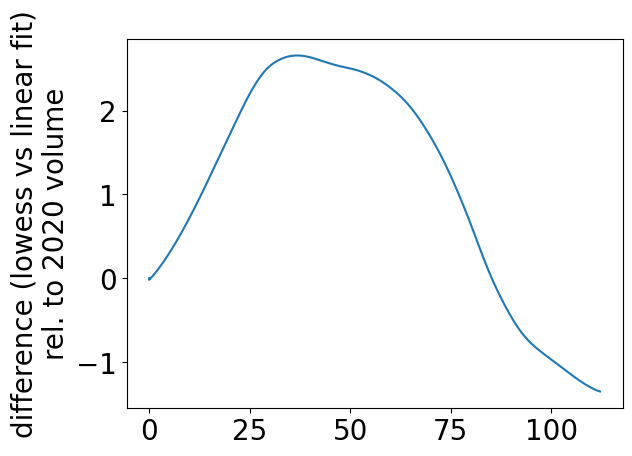

In [229]:
ds_rounce.sel(year=slice(2070,2102))

<xarray.Dataset>
Dimensions:                      (time: 1212, scenario: 3, model: 10, year: 32)
Coordinates:
  * time                         (time) datetime64[ns] 2000-01-01 ... 2100-12-01
    Climate_Model                (model) object 'CanESM2' ... 'NorESM1-M'
    Scenario                     (scenario) object 'RCP2.6' 'RCP4.5' 'RCP8.5'
  * year                         (year) int64 2070 2071 2072 ... 2099 2100 2101
Dimensions without coordinates: scenario, model
Data variables:
    reg_mass_annual              (scenario, model, year) float64 1.235e+17 .....
    reg_mass_bsl_annual          (scenario, model, year) float64 2.284e+16 .....
    reg_area_annual              (scenario, model, year) float64 5.872e+11 .....
    reg_melt_monthly             (scenario, model, time) float64 2.87e+13 ......
    reg_acc_monthly              (scenario, model, time) float64 4.277e+13 .....
    reg_refreeze_monthly         (scenario, model, time) float64 6.463e+11 .....
    reg_frontalablation_monthly  (scenario, model, time) float64 0.0 ... 6.13...

/tmp/ipykernel_3955804/3925439831.py:36: RuntimeWarning: invalid value encountered in divide
  plt.plot(_x, fit/_x, color='blue', label=f'Linear Fit (Rounce et al., 2023):\n'+r'V$_{asl}$'+f'= {slope:0.2f}*V', lw=3)
/tmp/ipykernel_3955804/3925439831.py:54: RuntimeWarning: invalid value encountered in divide
  ax.plot(_x, fit/_x, color='black', label=f'Linear Fit (only OGGM):\n'+r'V$_{asl}$'+f'= {slope:0.2f}*V', lw=3)


19 0.15193551737209102


  0%|                                                     | 0/1 [00:00<?, ?it/s]/home/users/lschuster/.local/lib/python3.10/site-packages/moepy/lowess.py:38: RuntimeWarning: divide by zero encountered in divide
  dist_to_weights = lambda dist, dist_threshold=1: (1 - ((np.abs(dist)/dist_threshold).clip(0, 1) ** 3)) ** 3
/home/users/lschuster/.local/lib/python3.10/site-packages/moepy/lowess.py:38: RuntimeWarning: invalid value encountered in divide
  dist_to_weights = lambda dist, dist_threshold=1: (1 - ((np.abs(dist)/dist_threshold).clip(0, 1) ** 3)) ** 3
  0%|                                                     | 0/1 [05:55<?, ?it/s]

KeyboardInterrupt



Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7f44bbb32290> (for post_execute):



KeyboardInterrupt



Error in callback <function flush_figures at 0x7f44bbb320e0> (for post_execute):



KeyboardInterrupt



In [249]:
fit_lowess_x

array([0.00000e+00, 1.00000e+00, 2.00000e+00, ..., 1.71198e+05,
       1.71199e+05, 1.71200e+05])

In [246]:
np.concatenate([y/x,                            y_0])

array([0.87397275, 0.87396409, 0.87391083, ..., 1.        , 1.        ,
       1.        ])

In [243]:
_x

array([0.00000e+00, 1.00000e+00, 2.00000e+00, ..., 1.71198e+05,
       1.71199e+05, 1.71200e+05])

In [ ]:
plt.rcParams.update({'font.size': 20})
j = 0
fig, axs = plt.subplots(1,1,figsize=(12,10))
#axs = axs.flatten()
vol_itmix_m3_reg = df_itmix['vol_itmix_m3'].sum()
vol_bsl_itmix_m3 = df_itmix['vol_bsl_itmix_m3'].sum()
below_sl_ratio = vol_bsl_itmix_m3/vol_itmix_m3_reg
print(rgi_reg,below_sl_ratio)
pd_slr_oggm_reg_sel = pd_slr_oggm_all_global # pd_slr_oggm_reg.loc[pd_slr_oggm_reg.rgi_reg == rgi_reg]
x = pd_slr_oggm_reg_sel.volume_km3.values
y = pd_slr_oggm_reg_sel.volume_km3.values - pd_slr_oggm_reg_sel.volume_km3_bsl.values

ax = axs #[j]
ax.plot(x,y, 'o', color='grey',
        label='OGGM GMIP3 estimates (all\nexperiments & after 100\nsimulation years)', alpha = 0.8)


##########################################
ds_rounce = xr.open_dataset('/home/www/lschuster/rounce_2023_data/Global_reg_allvns_50sets_2000_2100-rcps.nc')
ds_rounce = ds_rounce.sum(dim='region').sel(year = 2100)

x_rounce = ds_rounce.reg_mass_annual/900 / 1e9  # kg /m3
y_rounce = (ds_rounce.reg_mass_annual/900 - ds_rounce.reg_mass_bsl_annual/900)/1e9

plt.plot(x_rounce.values.squeeze().flatten(),
         y_rounce.values.squeeze().flatten(), 'o', label='Rounce et al., 2023\n(2000-2100)', color='cyan', alpha =0.8)

# Perform linear fit with forced intercept at zero
slope = np.dot(x_rounce.values.squeeze().flatten(), 
              y_rounce.values.squeeze().flatten()) / np.dot(x_rounce.values.squeeze().flatten(), x_rounce.values.squeeze().flatten())
_x = np.arange(0,x_rounce.values.squeeze().flatten().max(),1)
fit = _x*slope #+ #intercept
#fit[_x-fit<0] = 0 # below sea level should be above zero 
#fit[fit<0] = 0 # if above sea level is below zero -> set it equal tabove sea level should be above zero 

plt.plot(_x, fit, color='blue', label=f'Linear Fit (Rounce et al., 2023):\n'+r'V$_{asl}$'+f'= {slope:0.2f}*V', lw=3)
plt.legend()


#######################################
ax.axvline(vol_itmix_m3_reg/1e9, color = 'red', ls= '--')
ax.axhline(vol_itmix_m3_reg/1e9- vol_bsl_itmix_m3/1e9, color = 'red', ls= '--', label='Farinotti et al. (2019)\nat inventory date')

# Performing linear regression
#slope, intercept = np.polyfit(x, y, 1)
#_x = np.arange(0,x.max(),0.1)
# Perform linear fit with forced intercept at zero
slope = np.dot(x, y) / np.dot(x, x)
_x = np.arange(0,x.max(),1)
fit = _x*slope #+ #intercept
#fit[_x-fit<0] = 0 # below sea level should be above zero 
#fit[fit<0] = 0 # if above sea level is below zero -> set it equal tabove sea level should be above zero 

ax.plot(_x, fit, color='black', label=f'Linear Fit (only OGGM):\n'+r'V$_{asl}$'+f'= {slope:0.2f}*V', lw=3)

ax.set_xlabel(f'Volume (km³)')
ax.set_ylabel(f'Volume above sea-level (km³)')


#farinotti_intercept= (vol_itmix_m3_reg/1e9- vol_bsl_itmix_m3/1e9)-  vol_itmix_m3_reg/1e9*slope
#fit_f = _x*slope + farinotti_intercept
#fit_f[_x-fit_f<0] = _x[_x-fit_f<0] # if below sea level would get below zero, set it instead to zero 
#fit_f[fit_f<0] = 0  # above sea level should be above zero 

#ax.plot(_x, fit_f, color='blue',
#         label=f'Linear Fit, rescaled to\nFarinotti et al., 2019:\n'+r'V$_{asl}$'+f'={slope:0.2f}*V +{farinotti_intercept:0.1f}\n'+r'(and V$_{bsl}$≥0 & V$_{asl}$≥0)', lw=3)
reg_name = d_reg_num_name_sh[rgi_reg]
reg_name = reg_name.replace('\n',' ')
ax.set_title('Globally')
ax.plot([min(y), max(x)], [min(y), max(x)], color='grey', linestyle=':', label='1:1 line', alpha = 0.5)

ax.set_aspect('equal', adjustable='box')
ax.text(0.98,0.02, 
        f'Farinotti et al. (2019)\nabove sea-level ratio\nat inventory date: {(1-below_sl_ratio).round(2)}', 
        va = 'bottom', ha='right',
        transform=ax.transAxes)
# Set xticks and yticks to be equal
#max_value = max(max(x), max(y))
#max_value = int(np.ceil(max_value))
#ax.set_xticks(range(max_value + 1))
#ax.set_yticks(range(max_value + 1))


lowess = False
y_f = (vol_itmix_m3_reg/1e9- vol_bsl_itmix_m3/1e9)
x_f = vol_itmix_m3_reg/1e9
if lowess:
    x_f = np.repeat(x_f, len(x))
    y_f = np.repeat(y_f, len(x))
    x_0 = np.repeat(0,len(x))
    y_0 = np.repeat(0,len(x))
    from moepy import lowess, eda
    df_quantiles = lowess.quantile_model(np.concatenate([x,x_f,x_0]),
                                         np.concatenate([y,y_f,y_0]),
                                         x_pred= _x,
                                         frac=0.5,
                                         num_fits=100, robust_iters=1,
                                         qs=[0.5])
    fit_lowess = df_quantiles[0.5]
    fit_lowess_x = df_quantiles.index
    fit_lowess[(fit_lowess_x-fit_lowess)<0] = fit_lowess_x[(fit_lowess_x-fit_lowess)<0]
    fit_lowess[fit_lowess<0] = 0
    ax.plot(fit_lowess_x, fit_lowess, label= 'LOWESS (frac=0.5)\n(+constraints)', lw=3, color='red')
else:
    plt.plot(_x, _x*(1-below_sl_ratio), color='darkred', lw=4, label=r'Linear Fit (Farinotti et al., 2019):\nV$_{asl}$' + f'={(1-below_sl_ratio).round(2)}' )
ax.legend(loc='upper left', fontsize=15, bbox_to_anchor=(1.05,1))

In [35]:
pd_slr_oggm_reg['year'] = np.NaN

for r in rgi_regsnp.arange(1,20,1): 
    if len(pd_slr_oggm_reg.loc[pd_slr_oggm_reg.rgi_reg==r])/5001 == 80:
        pd_slr_oggm_reg.loc[pd_slr_oggm_reg.rgi_reg==r,'year'] = np.tile(np.arange(0,5001,1),80)
    elif len(pd_slr_oggm_reg.loc[pd_slr_oggm_reg.rgi_reg==r])/2001 == 80:
        pd_slr_oggm_reg.loc[pd_slr_oggm_reg.rgi_reg==r,'year'] = np.tile(np.arange(0,2001,1),80)
    else:
        print(r,'problem', len(pd_slr_oggm_reg.loc[pd_slr_oggm_reg.rgi_reg==r])/2001)
        

8 problem 0.0
11 problem 0.0
12 problem 0.0
13 problem 0.0
14 problem 0.0
15 problem 0.0
16 problem 0.0
18 problem 0.0


In [18]:
pd_slr_oggm_global

volume_km3  volume_km3_bsl  rgi_reg
gcm         period    ssp                                              
gfdl-esm4   1851-1870 historical  6.736161e+08    1.237873e+08   379083
            1901-1920 historical  4.837402e+08    6.756736e+07   379083
            1951-1970 historical  6.540438e+08    1.222888e+08   379083
            1995-2014 historical  4.642335e+08    6.324735e+07   379083
            2021-2040 ssp126      3.568295e+08    3.853690e+07   379083
...                                        ...             ...      ...
ukesm1-0-ll 2061-2080 ssp370      3.894863e+07    2.548910e+06   379083
                      ssp585      2.920428e+07    2.265527e+06   379083
            2081-2100 ssp126      1.318230e+08    1.352332e+07   379083
                      ssp370      2.171564e+07    1.128468e+06   379083
                      ssp585      1.392787e+07    1.496503e+06   379083

[80 rows x 3 columns]

01 0.05677064010470419


100%|████████████████████████████████████████████| 1/1 [02:18<00:00, 138.41s/it]


02 0.00013497247436306616


100%|█████████████████████████████████████████████| 1/1 [00:41<00:00, 41.52s/it]


03 0.05331620812425334


100%|████████████████████████████████████████████| 1/1 [02:42<00:00, 162.84s/it]


04 0.01375930847615673


100%|████████████████████████████████████████████| 1/1 [02:32<00:00, 152.49s/it]


05 0.1134007725958386


100%|████████████████████████████████████████████| 1/1 [02:23<00:00, 143.32s/it]


06 0.0021355072781992683


100%|████████████████████████████████████████████| 1/1 [02:13<00:00, 133.87s/it]


07 0.044356823776368466


100%|████████████████████████████████████████████| 1/1 [02:41<00:00, 161.44s/it]


09 0.09576659051192914


100%|████████████████████████████████████████████| 1/1 [02:21<00:00, 141.90s/it]


10 0.00454081117502465


100%|█████████████████████████████████████████████| 1/1 [00:33<00:00, 33.89s/it]


17 0.007197609460601714


100%|████████████████████████████████████████████| 1/1 [02:16<00:00, 136.09s/it]


19 0.3822794222352941


100%|████████████████████████████████████████████| 1/1 [02:48<00:00, 168.81s/it]


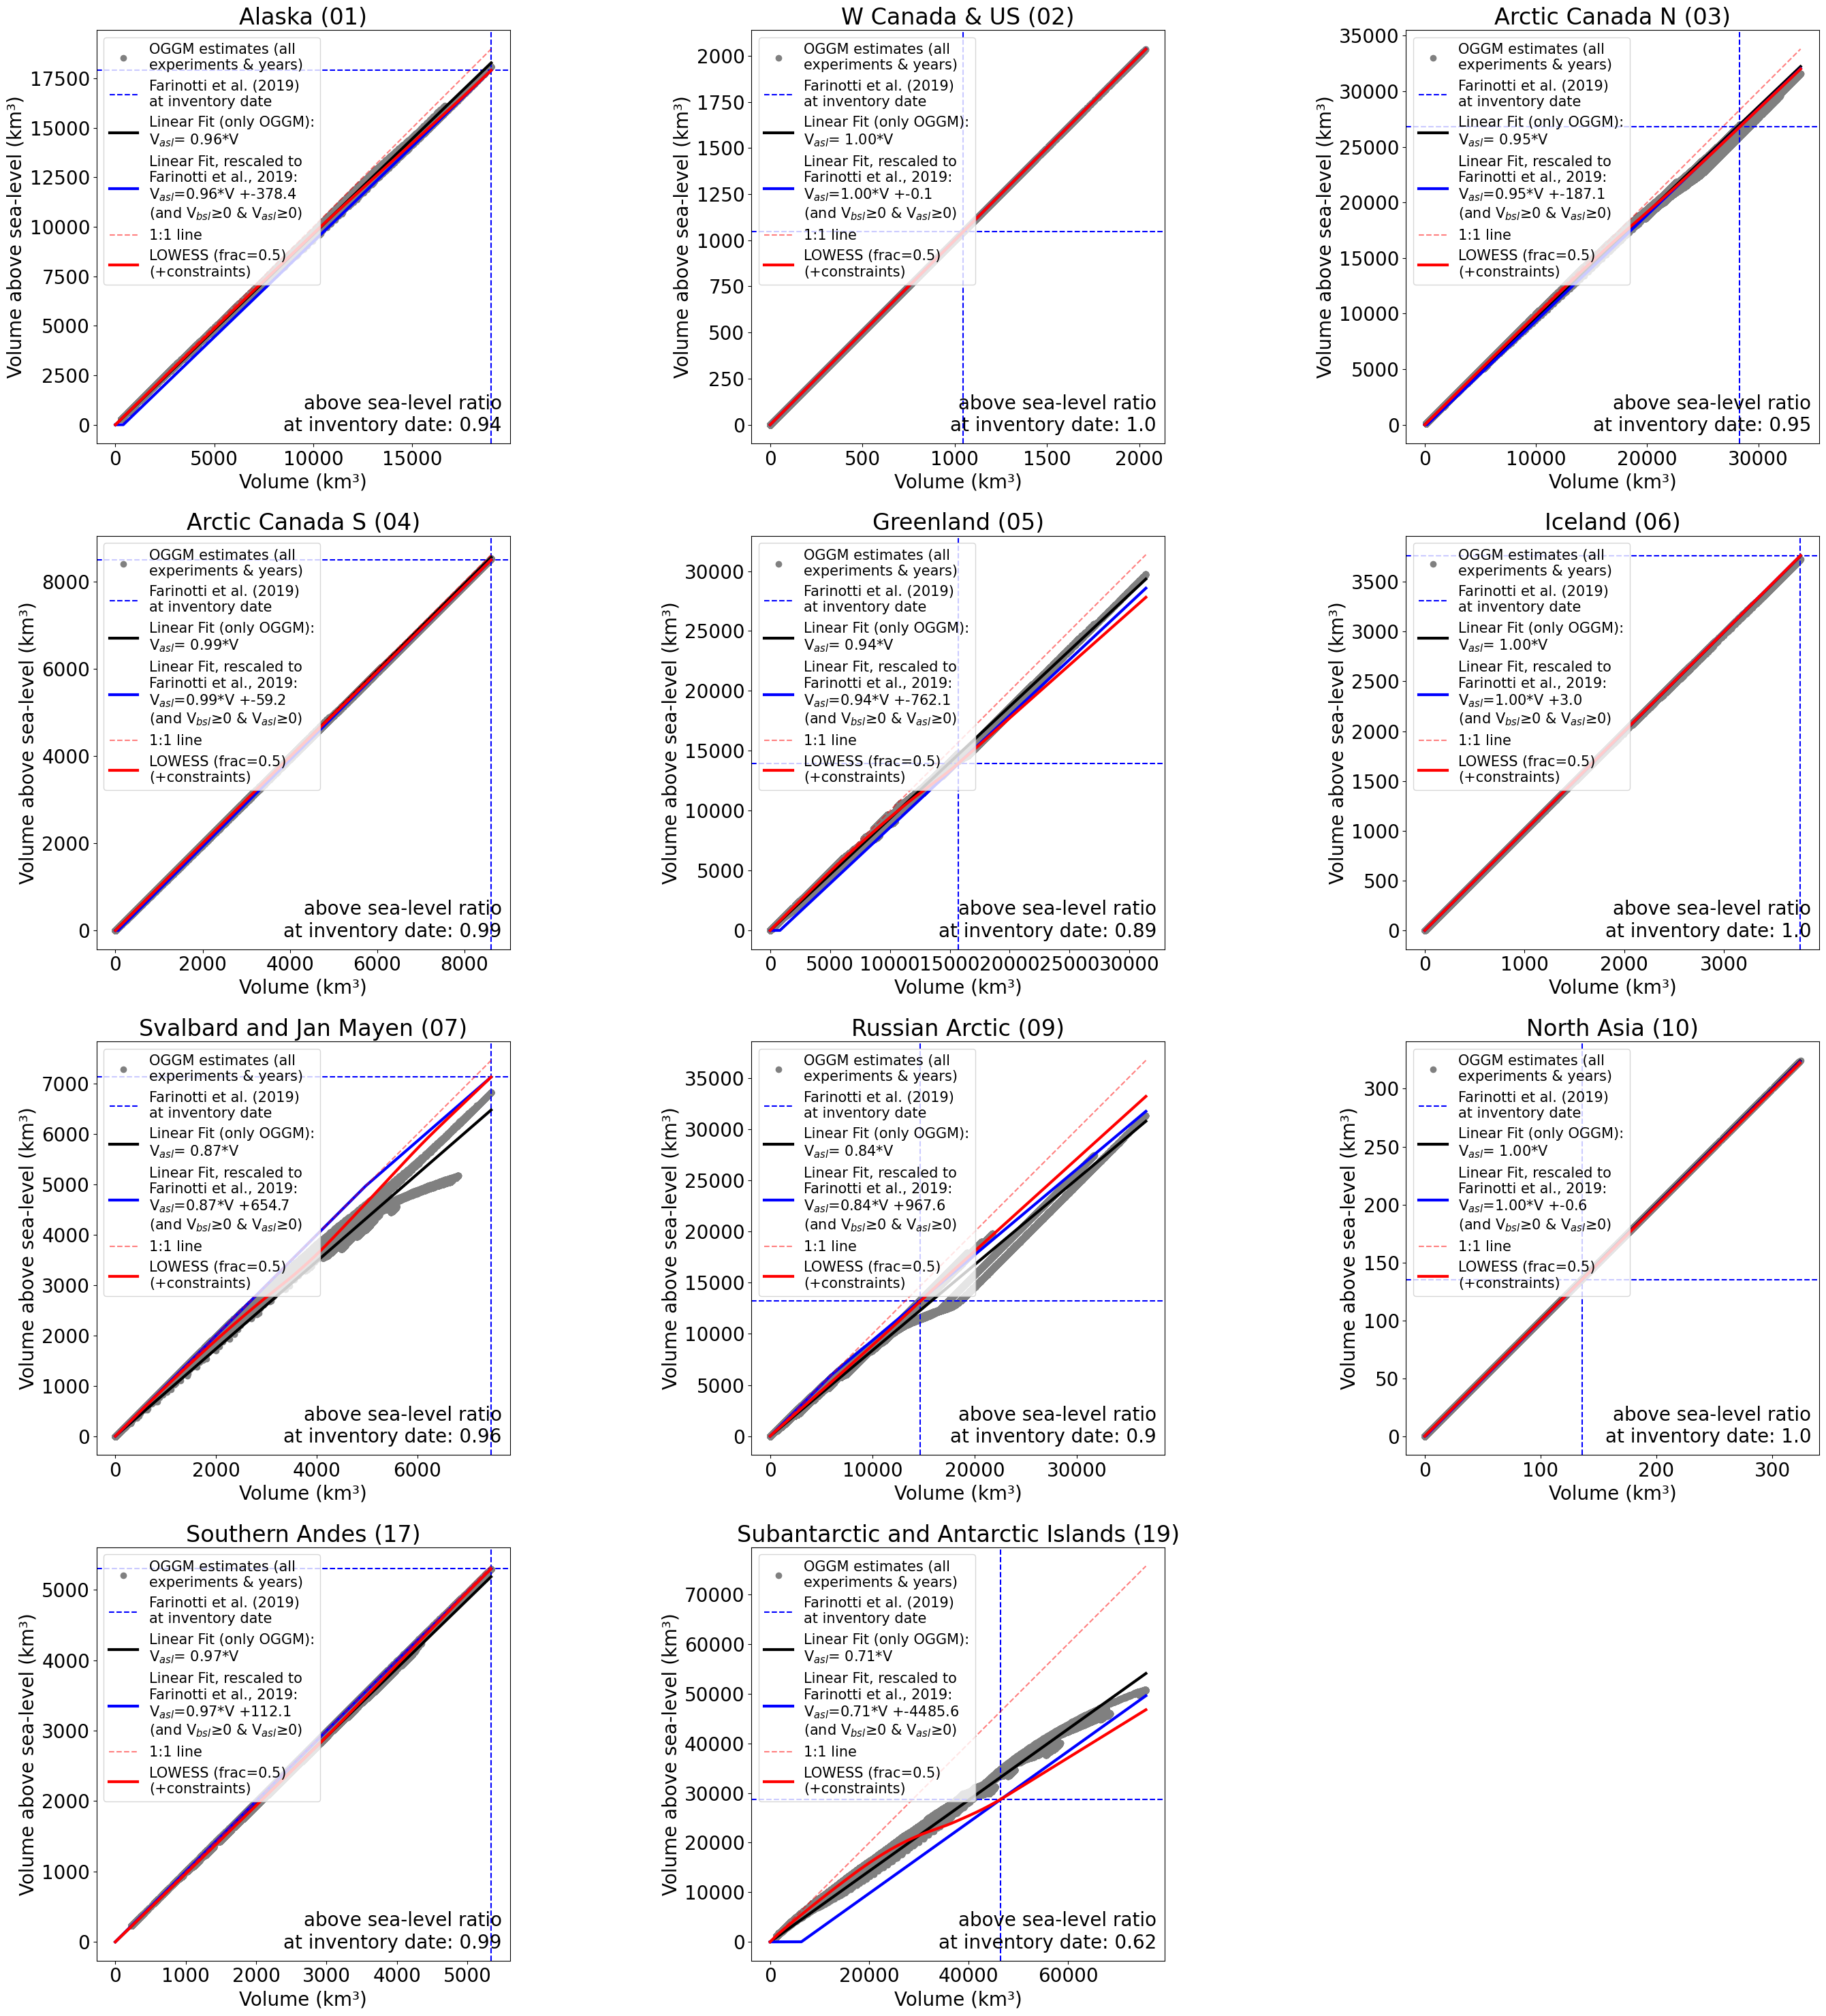

In [264]:
# NO OGGM intercept 
plt.rcParams.update({'font.size': 20})
fig, axs = plt.subplots(4,3,figsize=(30,30))
axs = axs.flatten()
for j,rgi_reg in enumerate(rgi_regs_bsl):
    vol_itmix_m3_reg = df_itmix.loc[df_itmix.rgi_region == rgi_reg]['vol_itmix_m3'].sum()
    vol_bsl_itmix_m3 = df_itmix.loc[df_itmix.rgi_region == rgi_reg]['vol_bsl_itmix_m3'].sum()
    below_sl_ratio = vol_bsl_itmix_m3/vol_itmix_m3_reg
    print(rgi_reg,below_sl_ratio)
    pd_slr_oggm_reg_sel = pd_slr_oggm_reg.loc[pd_slr_oggm_reg.rgi_reg == rgi_reg]
    x = pd_slr_oggm_reg_sel.volume_km3.values
    y = pd_slr_oggm_reg_sel.volume_km3.values - pd_slr_oggm_reg_sel.volume_km3_bsl.values
    
    ax = axs[j]
    ax.plot(x,y, 'o', color='grey',
            label='OGGM estimates (all\nexperiments & years)')
    
    ax.axvline(vol_itmix_m3_reg/1e9, color = 'blue', ls= '--')
    ax.axhline(vol_itmix_m3_reg/1e9- vol_bsl_itmix_m3/1e9, color = 'blue', ls= '--', label='Farinotti et al. (2019)\nat inventory date')
    
    # Performing linear regression
    #slope, intercept = np.polyfit(x, y, 1)
    #_x = np.arange(0,x.max(),0.1)
    # Perform linear fit with forced intercept at zero
    slope = np.dot(x, y) / np.dot(x, x)
    _x = np.arange(0,x.max(),1)
    fit = _x*slope #+ #intercept
    #fit[_x-fit<0] = 0 # below sea level should be above zero 
    #fit[fit<0] = 0 # if above sea level is below zero -> set it equal tabove sea level should be above zero 

    ax.plot(_x, fit, color='black', label=f'Linear Fit (only OGGM):\n'+r'V$_{asl}$'+f'= {slope:0.2f}*V', lw=3)

    ax.set_xlabel(f'Volume (km³)')
    ax.set_ylabel(f'Volume above sea-level (km³)')
    

    farinotti_intercept= (vol_itmix_m3_reg/1e9- vol_bsl_itmix_m3/1e9)-  vol_itmix_m3_reg/1e9*slope
    fit_f = _x*slope + farinotti_intercept
    fit_f[_x-fit_f<0] = _x[_x-fit_f<0] # if below sea level would get below zero, set it instead to zero 
    fit_f[fit_f<0] = 0  # above sea level should be above zero 

    ax.plot(_x, fit_f, color='blue',
             label=f'Linear Fit, rescaled to\nFarinotti et al., 2019:\n'+r'V$_{asl}$'+f'={slope:0.2f}*V +{farinotti_intercept:0.1f}\n'+r'(and V$_{bsl}$≥0 & V$_{asl}$≥0)', lw=3)
    reg_name = d_reg_num_name_sh[rgi_reg]
    reg_name = reg_name.replace('\n',' ')
    ax.set_title(f'{reg_name} ({rgi_reg})')
    ax.plot([min(y), max(x)], [min(y), max(x)], color='red', linestyle='--', label='1:1 line', alpha = 0.5)
    
    ax.set_aspect('equal', adjustable='box')
    ax.text(0.98,0.02, 
            f'above sea-level ratio\nat inventory date: {(1-below_sl_ratio).round(2)}', 
            va = 'bottom', ha='right',
            transform=ax.transAxes)
    # Set xticks and yticks to be equal
    #max_value = max(max(x), max(y))
    #max_value = int(np.ceil(max_value))
    #ax.set_xticks(range(max_value + 1))
    #ax.set_yticks(range(max_value + 1))
    
    y_f = (vol_itmix_m3_reg/1e9- vol_bsl_itmix_m3/1e9)
    x_f = vol_itmix_m3_reg/1e9
    x_f = np.repeat(x_f, len(x))
    y_f = np.repeat(y_f, len(x))
    x_0 = np.repeat(0,len(x))
    y_0 = np.repeat(0,len(x))
    from moepy import lowess, eda
    df_quantiles = lowess.quantile_model(np.concatenate([x,x_f,x_0]),
                                         np.concatenate([y,y_f,y_0]),
                                         x_pred= _x,
                                         frac=0.5,
                                         num_fits=100, robust_iters=1,
                                         qs=[0.5])
    fit_lowess = df_quantiles[0.5]
    fit_lowess_x = df_quantiles.index
    fit_lowess[(fit_lowess_x-fit_lowess)<0] = fit_lowess_x[(fit_lowess_x-fit_lowess)<0]
    fit_lowess[fit_lowess<0] = 0
    ax.plot(fit_lowess_x, fit_lowess, label= 'LOWESS (frac=0.5)\n(+constraints)', lw=3, color='red')
    ax.legend(loc='upper left', fontsize=15)

    
plt.delaxes(axs[-1])
plt.tight_layout()
plt.savefig('figures/5_slr_estimates/above_vs_volume_ratio_fits_no_intercept.png')

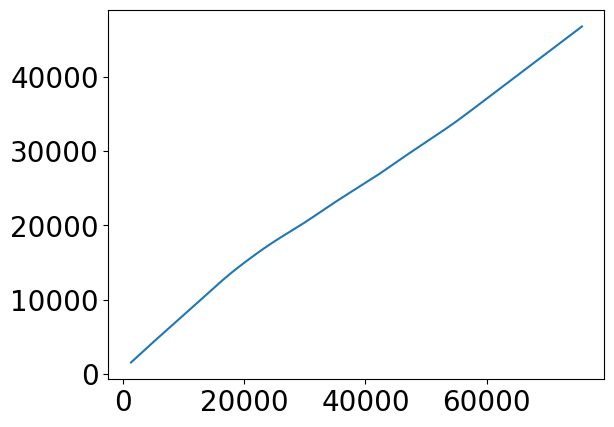

01 0.05677064010470419
02 0.00013497247436306616
03 0.05331620812425334
04 0.01375930847615673
05 0.1134007725958386
06 0.0021355072781992683
07 0.044356823776368466
09 0.09576659051192914
10 0.00454081117502465
17 0.007197609460601714
19 0.3822794222352941


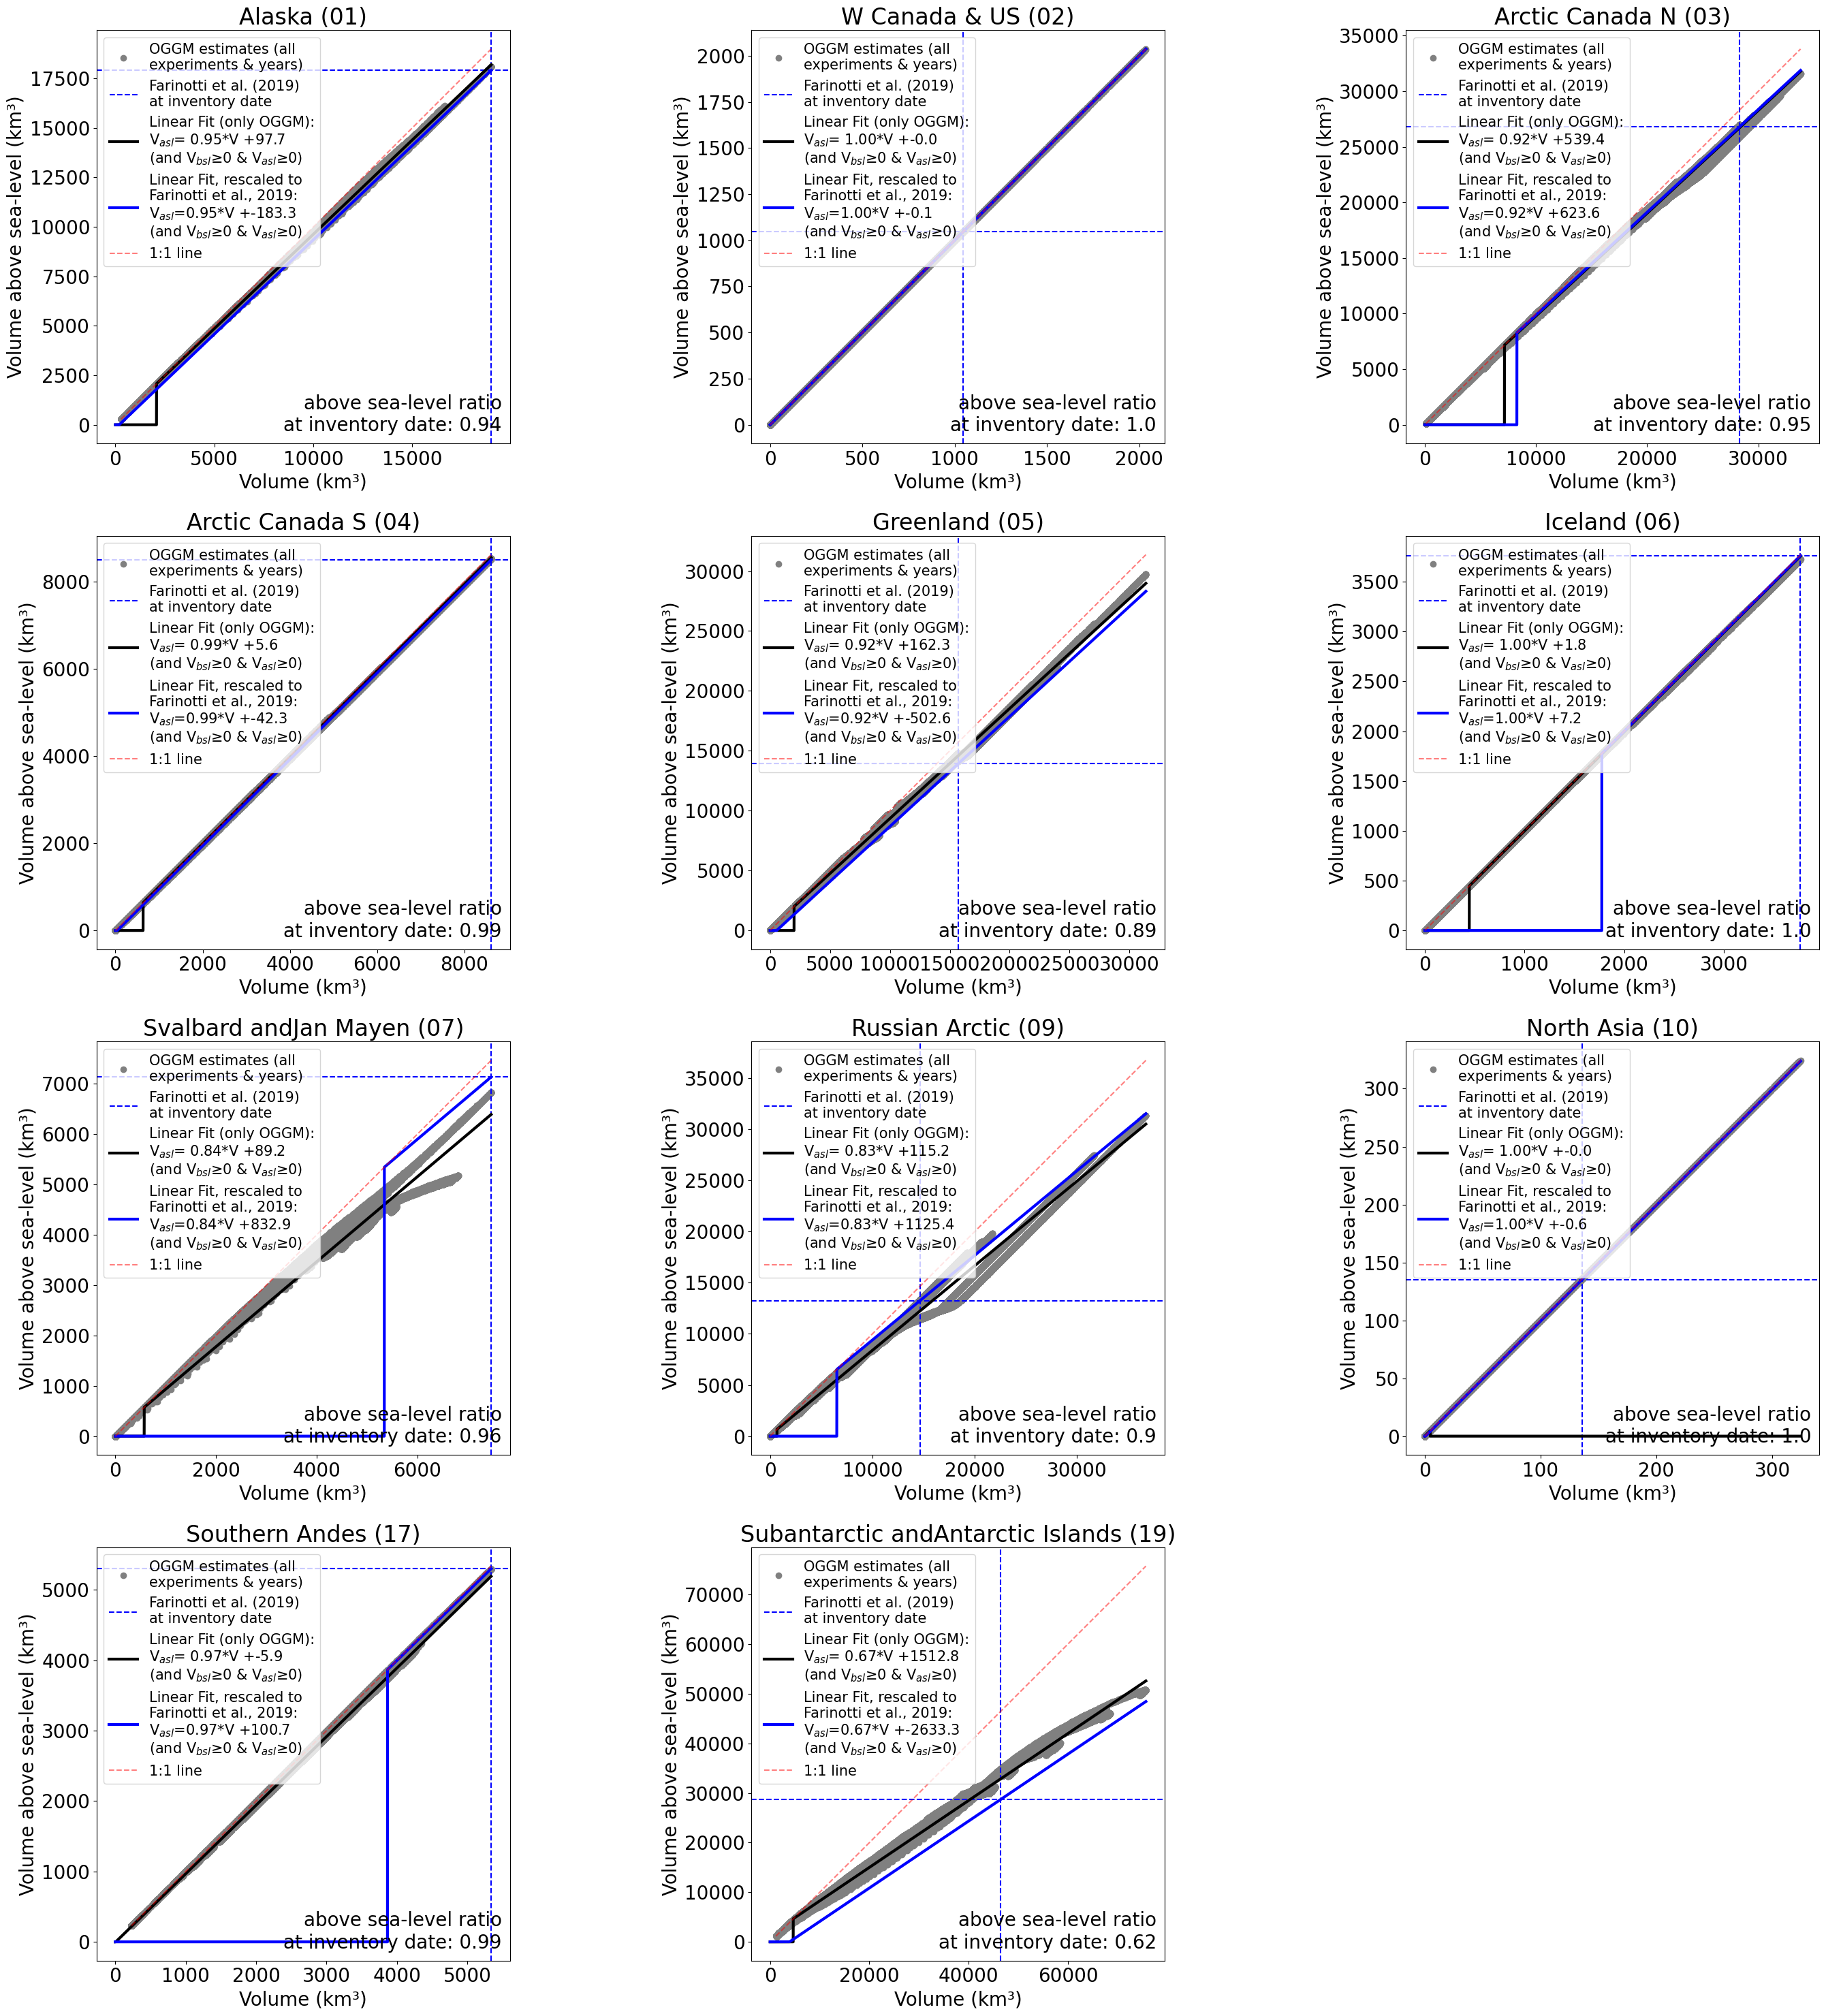

In [227]:
plt.rcParams.update({'font.size': 20})
fig, axs = plt.subplots(4,3,figsize=(30,30))
axs = axs.flatten()
for j,rgi_reg in enumerate(rgi_regs_bsl):
    vol_itmix_m3_reg = df_itmix.loc[df_itmix.rgi_region == rgi_reg]['vol_itmix_m3'].sum()
    vol_bsl_itmix_m3 = df_itmix.loc[df_itmix.rgi_region == rgi_reg]['vol_bsl_itmix_m3'].sum()
    below_sl_ratio = vol_bsl_itmix_m3/vol_itmix_m3_reg
    print(rgi_reg,below_sl_ratio)
    pd_slr_oggm_reg_sel = pd_slr_oggm_reg.loc[pd_slr_oggm_reg.rgi_reg == rgi_reg]
    x = pd_slr_oggm_reg_sel.volume_km3.values
    y = pd_slr_oggm_reg_sel.volume_km3.values - pd_slr_oggm_reg_sel.volume_km3_bsl.values
    
    ax = axs[j]
    ax.plot(x,y, 'o', color='grey',
            label='OGGM estimates (all\nexperiments & years)')
    
    ax.axvline(vol_itmix_m3_reg/1e9, color = 'blue', ls= '--')
    ax.axhline(vol_itmix_m3_reg/1e9- vol_bsl_itmix_m3/1e9, color = 'blue', ls= '--', label='Farinotti et al. (2019)\nat inventory date')
    
    # Performing linear regression
    slope, intercept = np.polyfit(x, y, 1)
    _x = np.arange(0,x.max(),0.1)
    fit = _x*slope + intercept
    fit[_x-fit<0] = 0 # below sea level should be above zero 
    fit[fit<0] = 0 # if above sea level is below zero -> set it equal tabove sea level should be above zero 

    ax.plot(_x, fit, color='black', label=f'Linear Fit (only OGGM):\n'+r'V$_{asl}$'+f'= {slope:0.2f}*V +{intercept:0.1f}\n'+r'(and V$_{bsl}$≥0 & V$_{asl}$≥0)', lw=3)

    ax.set_xlabel(f'Volume (km³)')
    ax.set_ylabel(f'Volume above sea-level (km³)')
    

    farinotti_intercept= (vol_itmix_m3_reg/1e9- vol_bsl_itmix_m3/1e9)-  vol_itmix_m3_reg/1e9*slope
    fit_f = _x*slope + farinotti_intercept
    fit_f[_x-fit_f<0] = 0 # below sea level should be above zero 
    fit_f[fit_f<0] = 0  # above sea level should be above zero 

    ax.plot(_x, fit_f, color='blue',
             label=f'Linear Fit, rescaled to\nFarinotti et al., 2019:\n'+r'V$_{asl}$'+f'={slope:0.2f}*V +{farinotti_intercept:0.1f}\n'+r'(and V$_{bsl}$≥0 & V$_{asl}$≥0)', lw=3)
    reg_name = d_reg_num_name_sh[rgi_reg]
    reg_name = reg_name.replace('\n',' ')
    ax.set_title(f'{reg_name} ({rgi_reg})')
    ax.plot([min(y), max(x)], [min(y), max(x)], color='red', linestyle='--', label='1:1 line', alpha = 0.5)
    ax.legend(loc='upper left', fontsize=15)
    
    ax.set_aspect('equal', adjustable='box')
    ax.text(0.98,0.02, 
            f'above sea-level ratio\nat inventory date: {(1-below_sl_ratio).round(2)}', 
            va = 'bottom', ha='right',
            transform=ax.transAxes)
    # Set xticks and yticks to be equal
    #max_value = max(max(x), max(y))
    #max_value = int(np.ceil(max_value))
    #ax.set_xticks(range(max_value + 1))
    #ax.set_yticks(range(max_value + 1))
    
plt.delaxes(axs[-1])
plt.tight_layout()
plt.savefig('figures/5_slr_estimates/above_vs_volume_ratio_fits.png')

In [ ]:
range(max_value + 1)

01 0.05677064010470419
02 0.00013497247436306616
03 0.05331620812425334
04 0.01375930847615673
05 0.1134007725958386
06 0.0021355072781992683
07 0.044356823776368466
09 0.09576659051192914
10 0.00454081117502465
17 0.007197609460601714
19 0.3822794222352941


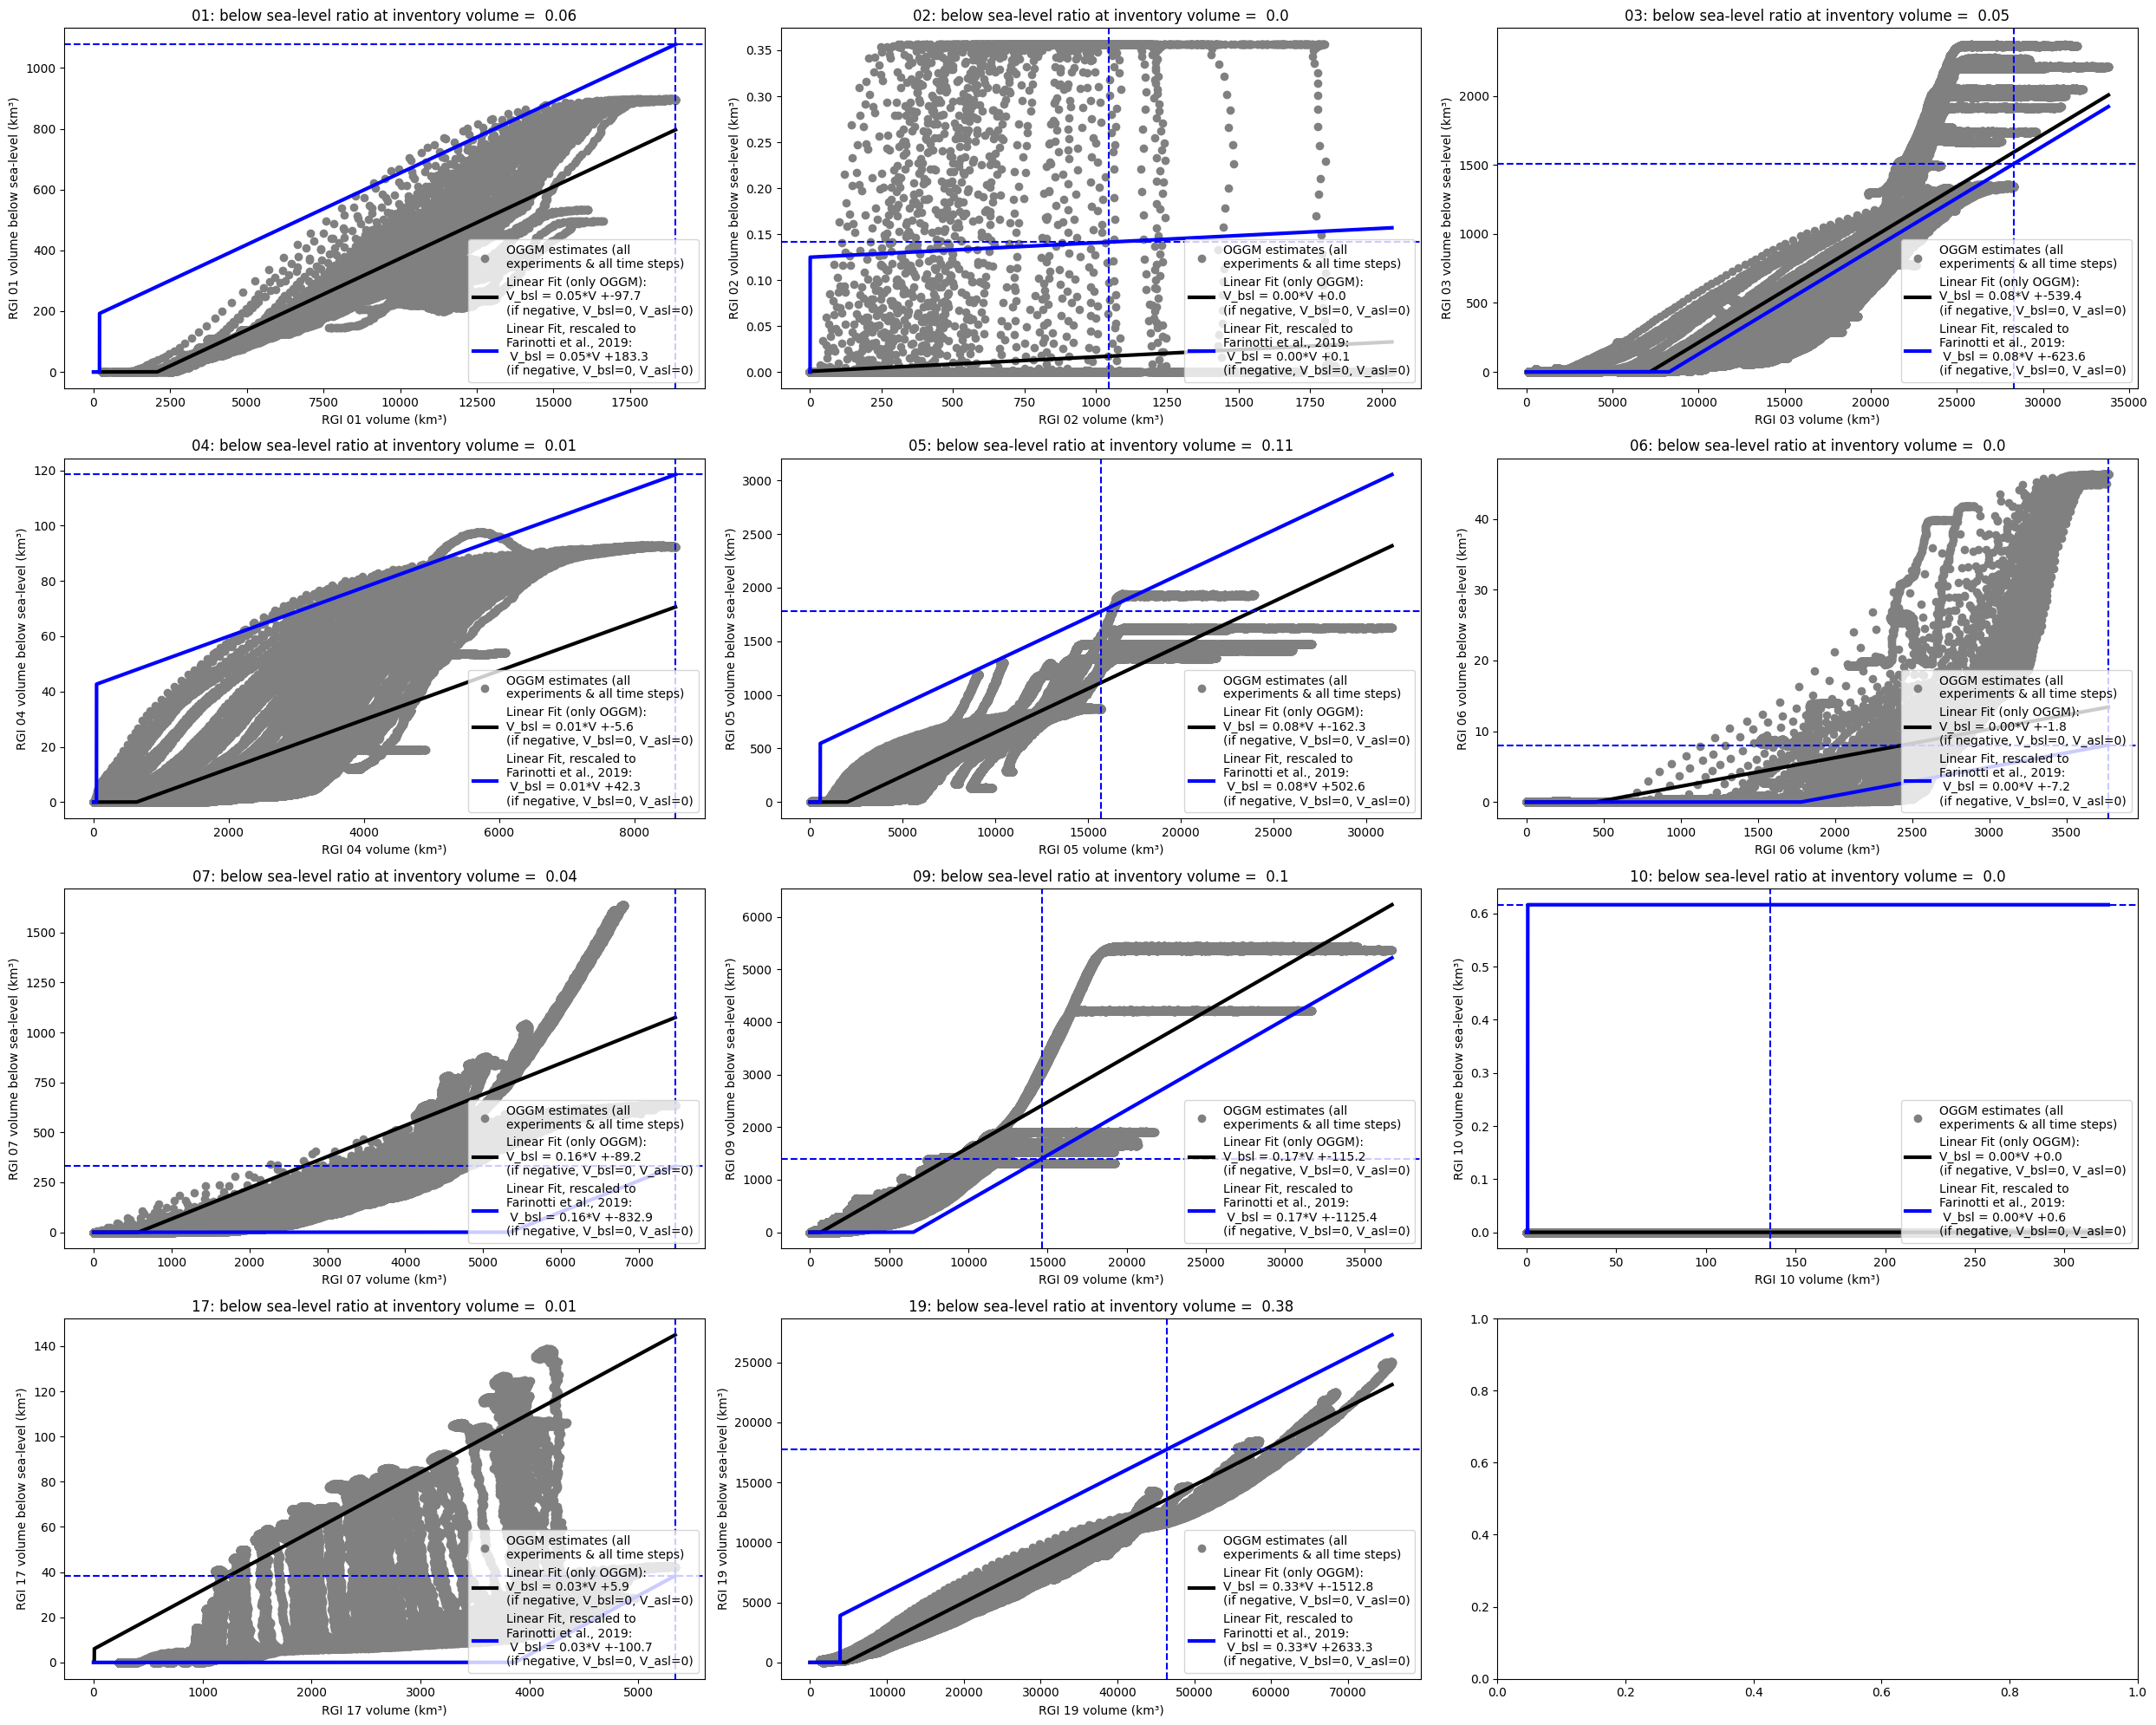

In [200]:
fig, axs = plt.subplots(4,3,figsize=(25,20))
axs = axs.flatten()
for j,rgi_reg in enumerate(rgi_regs_bsl):
    pd_slr_oggm_reg_sel = pd_slr_oggm_reg.loc[pd_slr_oggm_reg.rgi_reg == rgi_reg]
    x = pd_slr_oggm_reg_sel.volume_km3.values
    y = pd_slr_oggm_reg_sel.volume_km3_bsl.values
    
    ax = axs[j]
    ax.plot(x,y, 'o', color='grey',
            label='OGGM estimates (all\nexperiments & all time steps)')

    # Performing linear regression
    slope, intercept = np.polyfit(x, y, 1)
    _x = np.arange(0,x.max(),0.1)
    fit = _x*slope + intercept
    fit[_x-fit<0] = 0 # above sea level should be above zero 
    fit[fit<0] = 0 # below sea level should be above zero 

    ax.plot(_x, fit, color='black', label=f'Linear Fit (only OGGM):\nV_bsl = {slope:0.2f}*V +{intercept:0.1f}\n(if negative, V_bsl=0, V_asl=0)', lw=3)

    ax.set_xlabel(f'RGI {rgi_reg} volume (km³)')
    ax.set_ylabel(f'RGI {rgi_reg} volume below sea-level (km³)')
    
    vol_itmix_m3_reg = df_itmix.loc[df_itmix.rgi_region == rgi_reg]['vol_itmix_m3'].sum()
    vol_bsl_itmix_m3 = df_itmix.loc[df_itmix.rgi_region == rgi_reg]['vol_bsl_itmix_m3'].sum()
    below_sl_ratio = vol_bsl_itmix_m3/vol_itmix_m3_reg
    print(rgi_reg,below_sl_ratio)
    ax.axvline(vol_itmix_m3_reg/1e9, color = 'blue', ls= '--')
    ax.axhline(vol_bsl_itmix_m3/1e9, color = 'blue', ls= '--')
    ax.set_title(f'Steady-state {rgi_reg} volume of OGGM v1.6.1')


    farinotti_intercept= (vol_bsl_itmix_m3/1e9)-  vol_itmix_m3_reg/1e9*slope
    fit_f = _x*slope + farinotti_intercept
    fit_f[_x-fit_f<0] = 0 # below sea level should be above zero 
    fit_f[fit_f<0] = 0  # above sea level should be above zero 

    ax.plot(_x, fit_f, color='blue',
             label=f'Linear Fit, rescaled to\nFarinotti et al., 2019:\n V_bsl = {slope:0.2f}*V +{farinotti_intercept:0.1f}\n(if negative, V_bsl=0, V_asl=0)', lw=3)

    ax.set_title(f'{rgi_reg}: below sea-level ratio at inventory volume =  {below_sl_ratio.round(2)}')
    ax.legend(loc='lower right')
plt.tight_layout()
plt.savefig('figures/5_slr_estimates/below_vs_volume_ratio_fits.png')

In [173]:
pd_slr_oggm_reg

volume_km3  volume_km3_bsl          gcm         ssp     period  \
0         18639.326       891.76340    gfdl-esm4      ssp126  2021-2040   
1         18457.550       892.11865    gfdl-esm4      ssp126  2021-2040   
2         18300.988       892.07416    gfdl-esm4      ssp126  2021-2040   
3         18189.406       891.98120    gfdl-esm4      ssp126  2021-2040   
4         17946.040       891.53900    gfdl-esm4      ssp126  2021-2040   
...             ...             ...          ...         ...        ...   
3920875   34315.465      9055.26800  ukesm1-0-ll  historical  1995-2014   
3920876   34336.860      9055.43600  ukesm1-0-ll  historical  1995-2014   
3920877   34324.496      9052.81700  ukesm1-0-ll  historical  1995-2014   
3920878   34336.720      9052.27700  ukesm1-0-ll  historical  1995-2014   
3920879   34377.766      9061.83000  ukesm1-0-ll  historical  1995-2014   

         rgi_reg  
0              1  
1              1  
2              1  
3              1  
4              1  
...          ...  
3920875       19  
3920876       19  
3920877       19  
3920878       19  
3920879       19  

[3920880 rows x 6 columns]

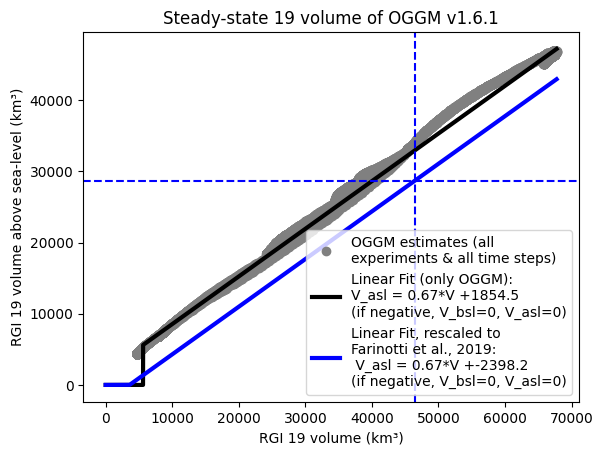

In [60]:
plt.plot(np.array(volume_l_t).flatten(), np.array(volume_l_t).flatten()-np.array(volume_bsl_l_t).flatten(), 'o', color='grey',
        label='OGGM estimates (all\nexperiments & all time steps)')
    
x = np.array(volume_l_t).flatten()
y = np.array(volume_l_t).flatten()-np.array(volume_bsl_l_t).flatten()
# Performing linear regression
slope, intercept = np.polyfit(x, y, 1)
_x = np.arange(0,x.max(),0.1)
fit = _x*slope + intercept
fit[_x-fit<0] = 0 # below sea level should be above zero 
fit[fit<0] = 0 # above sea level should be above zero 

plt.plot(_x, fit, color='black', label=f'Linear Fit (only OGGM):\nV_asl = {slope:0.2f}*V +{intercept:0.1f}\n(if negative, V_bsl=0, V_asl=0)', lw=3)

plt.xlabel(f'RGI {rgi_reg} volume (km³)')
plt.ylabel(f'RGI {rgi_reg} volume above sea-level (km³)')
plt.axvline(vol_itmix_m3_reg/1e9, color = 'blue', ls= '--')
plt.axhline(vol_itmix_m3_reg/1e9- vol_bsl_itmix_m3/1e9, color = 'blue', ls= '--')
plt.title(f'Steady-state {rgi_reg} volume of OGGM v1.6.1')


farinotti_intercept= (vol_itmix_m3_reg/1e9- vol_bsl_itmix_m3/1e9)-  vol_itmix_m3_reg/1e9*slope
fit_f = _x*slope + farinotti_intercept
fit_f[_x-fit_f<0] = 0 # below sea level should be above zero 
fit_f[fit_f<0] = 0  # above sea level should be above zero 

plt.plot(_x, fit_f, color='blue',
         label=f'Linear Fit, rescaled to\nFarinotti et al., 2019:\n V_asl = {slope:0.2f}*V +{farinotti_intercept:0.1f}\n(if negative, V_bsl=0, V_asl=0)', lw=3)


plt.legend(loc='lower right')

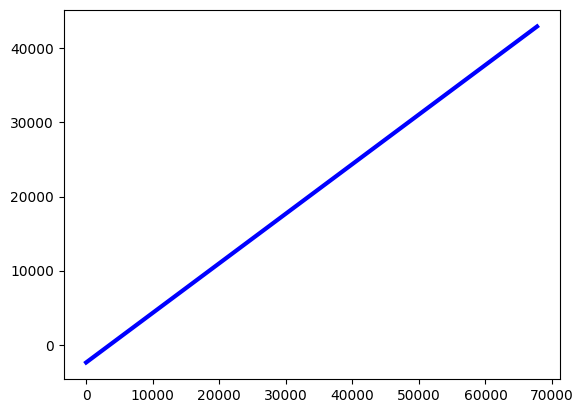

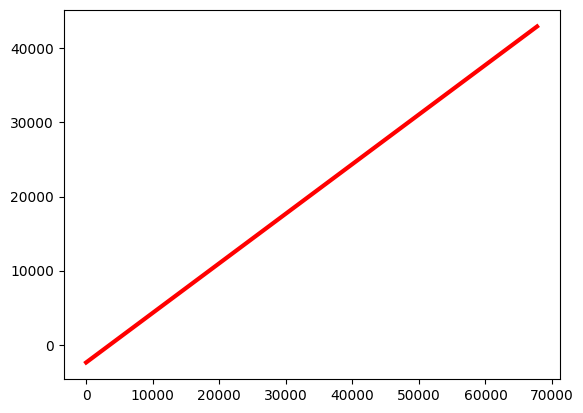